# This notebook does the 2-point and 3-point fits simultaneously

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import gvar as gv
import h5py
import lsqfit
import h5data_methods as h5_dm

In [3]:
import pickle

In [4]:
# Constants

#Physical constants
hbarc = 197.3 # MeV fm
a = 0.12

# Pion mass
mpi = 0.1885
#mpi = 0.2

# Plot constants
t_min_plt = 1
t_max_plt = 25

# Array of tsep values
tsep_vals = np.arange(3,13,1)
tsep_vals

array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

In [5]:
def Ei(n_selec, p):
    Ea = p['E0']
    for l in range(1, n_selec+1):
        Ea += p['dE{}'.format(l)]
        
    #print(Ea)
    return Ea

In [6]:
data = {}
data['2pt'] = h5_dm.get_2pt("a12m310_a_avg.h5")
data['2pt_SS'] = data['2pt'][:,:,0]
data['2pt_PS'] = data['2pt'][:,:,1]
data['3pt_A3'] = h5_dm.get_3pt("a12m310_a_avg.h5", "A3", 3, 13)
data['3pt_V4'] = h5_dm.get_3pt("a12m310_a_avg.h5", "V4", 3, 13)
data['FH_N_A3'] = h5_dm.get_FH("a12m310_a_fh.h5", "gA")
data['FH_N_V4'] = h5_dm.get_FH("a12m310_a_fh.h5", "gV")
data['FH_N'] = h5_dm.get_FH("a12m310_a_fh.h5", "all")


In [7]:
gv_avg_data = gv.BufferDict()
gv_avg_data = gv.dataset.avg_data(data)

# Calculate the ratio between 3-point and 2-point data, for both A3 and V4
gv_avg_data['C_ratio_A3'] = np.array([ [gv_avg_data['3pt_A3'][i][j]/gv_avg_data['2pt_SS'][i+tsep_vals[0]] for j in range(1, i+3)] for i in range(len(tsep_vals))])
gv_avg_data['Csum_A3'] = np.array([np.sum(gv_avg_data['3pt_A3'][i][1:i+3]) for i in range(len(tsep_vals))])
gv_avg_data['C^FH_A3'] = np.array([ (gv_avg_data['Csum_A3'][i + 1]/gv_avg_data['2pt_SS'][i + tsep_vals[0] + 1]) - (gv_avg_data['Csum_A3'][i]/gv_avg_data['2pt_SS'][i + tsep_vals[0]]) for i in range(len(tsep_vals)-1)])

gv_avg_data['C_ratio_V4'] = np.array([ [gv_avg_data['3pt_V4'][i][j]/gv_avg_data['2pt_SS'][i+tsep_vals[0]] for j in range(1, i+3)] for i in range(len(tsep_vals))])
gv_avg_data['Csum_V4'] = np.array([np.sum(gv_avg_data['3pt_V4'][i][1:i+3]) for i in range(len(tsep_vals))])
gv_avg_data['C^FH_V4'] = np.array([ (gv_avg_data['Csum_V4'][i + 1]/gv_avg_data['2pt_SS'][i + tsep_vals[0] + 1]) - (gv_avg_data['Csum_V4'][i]/gv_avg_data['2pt_SS'][i + tsep_vals[0]]) for i in range(len(tsep_vals)-1)])

# The A3 and V4 3-point and sum-subtracted samples are combined into arrays of (A3, V4) pairs 
gv_avg_data['3pt_combined'] = np.array([ [ [gv_avg_data['3pt_A3'][i][j], gv_avg_data['3pt_V4'][i][j]] for j in range(len(gv_avg_data['3pt_A3'][i]))] for i in range(len(gv_avg_data['3pt_A3']))])
gv_avg_data['C^FH_combined'] = np.transpose(np.append([gv_avg_data['C^FH_A3'],], [gv_avg_data['C^FH_V4'],], axis = 0))

gv_avg_data['2pt_meff'] = np.log(np.array([gv_avg_data['2pt'][j,:]/gv_avg_data['2pt'][j+1,:] for j in range(63)]))
gv_avg_data['2pt_SS_meff'] = np.log(np.array([gv_avg_data['2pt_SS'][j]/gv_avg_data['2pt_SS'][j+1] for j in range(63)]))
gv_avg_data['2pt_PS_meff'] = np.log(np.array([gv_avg_data['2pt_PS'][j]/gv_avg_data['2pt_PS'][j+1] for j in range(63)]))

gv_avg_data['2pt_zSeff'] = np.array([np.sqrt(np.exp(gv_avg_data['2pt_SS_meff'][t]*t)*gv_avg_data['2pt_SS'][t]) for t in range(63)])
gv_avg_data['2pt_zPeff'] = np.array([np.exp(gv_avg_data['2pt_PS_meff'][t]*t)*gv_avg_data['2pt_PS'][t]/gv_avg_data['2pt_zSeff'][t] for t in range(63)])


# Sum-subtract the Feynman-Hellman raw data to get a FH dataset
gv_avg_data['2pt_D'] = np.transpose(np.array([gv_avg_data['2pt_SS'], gv_avg_data['2pt_PS'], gv_avg_data['2pt_SS'], gv_avg_data['2pt_PS']]))
gv_avg_data['FH'] = np.roll(gv_avg_data['FH_N']/gv_avg_data['2pt_D'], -1, axis = 0) - gv_avg_data['FH_N']/gv_avg_data['2pt_D']

<ipython-input-7-2f60309b0160>:17: RuntimeWarning: invalid value encountered in log
  gv_avg_data['2pt_meff'] = np.log(np.array([gv_avg_data['2pt'][j,:]/gv_avg_data['2pt'][j+1,:] for j in range(63)]))
<ipython-input-7-2f60309b0160>:18: RuntimeWarning: invalid value encountered in log
  gv_avg_data['2pt_SS_meff'] = np.log(np.array([gv_avg_data['2pt_SS'][j]/gv_avg_data['2pt_SS'][j+1] for j in range(63)]))
<ipython-input-7-2f60309b0160>:19: RuntimeWarning: invalid value encountered in log
  gv_avg_data['2pt_PS_meff'] = np.log(np.array([gv_avg_data['2pt_PS'][j]/gv_avg_data['2pt_PS'][j+1] for j in range(63)]))
<ipython-input-7-2f60309b0160>:21: RuntimeWarning: invalid value encountered in sqrt
  gv_avg_data['2pt_zSeff'] = np.array([np.sqrt(np.exp(gv_avg_data['2pt_SS_meff'][t]*t)*gv_avg_data['2pt_SS'][t]) for t in range(63)])


In [8]:
np.shape(gv_avg_data['FH'])

(64, 4)

#### Define functions

In [9]:
def param_FH(p):
    sub_p = gv.BufferDict()
    sub_p['E0'] = p['E0']
    sub_p['Z0'] = p['Z0']
    
    for k in range(1, num_states_FH - 1):
        sub_p['Z{}'.format(k)] = p['Z{}'.format(k)]
        sub_p['log(dE{})'.format(k)] = p['log(dE{})'.format(k)]
        
    sub_p['Z{}'.format(num_states_FH - 1)] = p['Z_FHmax']
    sub_p['log(dE{})'.format(num_states_FH - 1)] = p['log(FH_dEmax)']
    
    for n in range(num_states_FH-1):
        for m in range(num_states_FH-1):
                
            sub_p['gA3_{0}{1}'.format(n, m)] = p['gA3_{0}{1}'.format(n, m)]
            sub_p['gV4_{0}{1}'.format(n, m)] = p['gV4_{0}{1}'.format(n, m)]
            
    for n in range(num_states_FH-1):
        sub_p['gA3_{0}{1}'.format(n, num_states_FH-1)] = p['gA3_{}FHmax'.format(n)]
        sub_p['gA3_{0}{1}'.format(num_states_FH-1, n)] = p['gA3_FHmax{}'.format(n)]
        sub_p['gV4_{0}{1}'.format(n, num_states_FH-1)] = p['gV4_{}FHmax'.format(n)]
        sub_p['gV4_{0}{1}'.format(num_states_FH-1, n)] = p['gV4_FHmax{}'.format(n)]
        
    sub_p['gA3_{0}{1}'.format(num_states_FH-1, num_states_FH-1)] = p['gA3_FHmaxFHmax']
    sub_p['gV4_{0}{1}'.format(num_states_FH-1, num_states_FH-1)] = p['gV4_FHmaxFHmax']
    
    return sub_p

def param_FHdata(p):
    sub_p = gv.BufferDict()
    sub_p['E0'] = p['E0']
    sub_p['Z0'] = p['Z0']
    sub_p['Ztilde0'] = p['Ztilde0']
    
    for k in range(1, num_states_FH - 1):
        sub_p['Z{}'.format(k)] = p['Z{}'.format(k)]
        sub_p['Ztilde{}'.format(k)] = p['Ztilde{}'.format(k)]
        sub_p['log(dE{})'.format(k)] = p['log(dE{})'.format(k)]
        
    sub_p['Z{}'.format(num_states_FH - 1)] = p['Z_FHmax']
    sub_p['Ztilde{}'.format(num_states_FH - 1)] = p['Ztilde_FHmax']
    sub_p['log(dE{})'.format(num_states_FH - 1)] = p['log(FH_dEmax)']
    
    for n in range(num_states_FH-1):
        for m in range(num_states_FH-1):
                
            sub_p['gA3_{0}{1}'.format(n, m)] = p['gA3_{0}{1}'.format(n, m)]
            sub_p['gV4_{0}{1}'.format(n, m)] = p['gV4_{0}{1}'.format(n, m)]
            
    for n in range(num_states_FH-1):
        sub_p['gA3_{0}{1}'.format(n, num_states_FH-1)] = p['gA3_{}FHmax'.format(n)]
        sub_p['gA3_{0}{1}'.format(num_states_FH-1, n)] = p['gA3_FHmax{}'.format(n)]
        sub_p['gV4_{0}{1}'.format(n, num_states_FH-1)] = p['gV4_{}FHmax'.format(n)]
        sub_p['gV4_{0}{1}'.format(num_states_FH-1, n)] = p['gV4_FHmax{}'.format(n)]
        
    sub_p['gA3_{0}{1}'.format(num_states_FH-1, num_states_FH-1)] = p['gA3_FHmaxFHmax']
    sub_p['gV4_{0}{1}'.format(num_states_FH-1, num_states_FH-1)] = p['gV4_FHmaxFHmax']
    
    for n in range(num_states_FH):
        sub_p['d_gA_ss_{}'.format(n)] = p['d_gA_ss_{}'.format(n)]
        sub_p['d_gA_ps_{}'.format(n)] = p['d_gA_ps_{}'.format(n)]
        sub_p['d_gV_ss_{}'.format(n)] = p['d_gV_ss_{}'.format(n)]
        sub_p['d_gV_ps_{}'.format(n)] = p['d_gV_ps_{}'.format(n)]
    
    return sub_p

#def param_FHdata(p):
    #sub_p = gv.BufferDict()
    #sub_p['E0'] = p['E0']
    #sub_p['Z0'] = p['Z0']
    #sub_p['Ztilde0'] = p['Ztilde0']
    
    #for k in range(1, num_states_FHdata - 1):
        #sub_p['Z{}'.format(k)] = p['Z{}'.format(k)]
        #sub_p['Ztilde{}'.format(k)] = p['Ztilde{}'.format(k)]
        #sub_p['log(dE{})'.format(k)] = p['log(dE{})'.format(k)]
        
    #sub_p['Z{}'.format(num_states_FHdata - 1)] = p['Z_FHdatamax']
    #sub_p['Ztilde{}'.format(num_states_FHdata - 1)] = p['Ztilde_FHdatamax']
    #sub_p['log(dE{})'.format(num_states_FHdata - 1)] = p['log(FHdata_dEmax)']
    
    #for n in range(num_states_FHdata-1):
        #for m in range(num_states_FHdata-1):
                
            #sub_p['gA3_{0}{1}'.format(n, m)] = p['gA3_{0}{1}'.format(n, m)]
            #sub_p['gV4_{0}{1}'.format(n, m)] = p['gV4_{0}{1}'.format(n, m)]
            
    #for n in range(num_states_FHdata-1):
        #sub_p['gA3_{0}{1}'.format(n, num_states_FHdata-1)] = p['gA3_{}FHdatamax'.format(n)]
        #sub_p['gA3_{0}{1}'.format(num_states_FHdata-1, n)] = p['gA3_FHdatamax{}'.format(n)]
        #sub_p['gV4_{0}{1}'.format(n, num_states_FHdata-1)] = p['gV4_{}FHdatamax'.format(n)]
        #sub_p['gV4_{0}{1}'.format(num_states_FHdata-1, n)] = p['gV4_FHdatamax{}'.format(n)]
        
    #sub_p['gA3_{0}{1}'.format(num_states_FHdata-1, num_states_FHdata-1)] = p['gA3_FHdatamaxFHdatamax']
    #sub_p['gV4_{0}{1}'.format(num_states_FHdata-1, num_states_FHdata-1)] = p['gV4_FHdatamaxFHdatamax']
    
    #for n in range(num_states_FHdata):
        #sub_p['d_gA_ss_{}'.format(n)] = p['d_gA_ss_{}'.format(n)]
        #sub_p['d_gA_ps_{}'.format(n)] = p['d_gA_ps_{}'.format(n)]
        #sub_p['d_gV_ss_{}'.format(n)] = p['d_gV_ss_{}'.format(n)]
        #sub_p['d_gV_ps_{}'.format(n)] = p['d_gV_ps_{}'.format(n)]
    
    #return sub_p

In [10]:
num_zs = 1 #Order number of the n's
# Log E: log of the energy.  
# P is point (in the context of )

def C_2pt(t, p):
    
    z = np.array([])
    ztilde = np.array([])
    E = np.array([])
    for i in range(num_zs):
        z = np.append(z, p['Z{}'.format(i)])
        ztilde = np.append(ztilde, p['Ztilde{}'.format(i)])
        E = np.append(E, Ei(i, p))
        
    
    sum_pp = sum([z[i]*z[i]*np.exp(-E[i]*t) for i in range(num_zs)])
    sum_ps = sum([z[i]*ztilde[i]*np.exp(-E[i]*t) for i in range(num_zs)])
    
    return np.transpose(np.array([[sum_pp], [sum_ps]]), axes=[2,0,1])

def C_2pt_SS(t, p):
    
    z = np.array([])
    E = np.array([])
    for i in range(num_zs):
        z = np.append(z, p['Z{}'.format(i)])
        E = np.append(E, Ei(i, p))
        
    
    sum_ss = sum([z[i]*z[i]*np.exp(-E[i]*t) for i in range(num_zs)])
    
    return np.array(sum_ss)

def C_2pt_PS(t, p):
    
    z = np.array([])
    ztilde = np.array([])
    E = np.array([])
    for i in range(num_zs):
        z = np.append(z, p['Z{}'.format(i)])
        ztilde = np.append(ztilde, p['Ztilde{}'.format(i)])
        E = np.append(E, Ei(i, p))
        
    #print("z: ", z)
    #print("ztilde: ", ztilde)
    
    sum_ps = sum([z[i]*ztilde[i]*np.exp(-E[i]*t) for i in range(num_zs)])
    
    return np.array(sum_ps)

In [30]:
# Precondition: t is a 1-D numpy array of 2-element array like objects t[i] = (t_sep, tau)
  
    
def C_3pt_A3(t, p):
    #tsep = np.array([np.array([t[i][j][0] for j in range(len(t[i]))]) for i in range(len(t))])
    #tau = np.array([np.array([t[i][j][1] for j in range(len(t[i]))]) for i in range(len(t))])
    tsep, tau = np.transpose(t)
    #print("tsep: ", tsep)
    #print("tau: ", tau)
    
    result = p['Z0']*p['gA3_00']*p['Z0']*np.exp(-p["E0"]*tsep)*np.exp(-(p["E0"] - p["E0"])*tau)
    
    n = 0
    m = 0
    
    if num_zs == 1:
        return result
    
    m += 1
    while n < num_zs:    
        En = Ei(n, p)
        Em = Ei(m, p) 
        result += p['Z{}'.format(n)]*p['gA3_{0}{1}'.format(n, m)]*p['Z{}'.format(m)]*np.exp(-En*tsep)*np.exp(-(Em - En)*tau)
        m += 1
        if m >= num_zs:
            m = 0
            n += 1
            
    #for n in range(num_zs):
        #for m in range(num_zs):
            #result += p['Z{}'.format(n)]*p['gA3_{0}{1}'.format(n, m)]*p['Z{}'.format(m)]*np.exp(-p["E{}".format(n)]*tsep)*np.exp(-(p["E{}".format(m)] - p["E{}".format(n)])*tau)
            # print out the dictionary indices which are called in this summation
            #print("n = ", n, "; m = ", m)
            #print('Z{}'.format(n), "*", 'gA3_{0}{1}'.format(n, m), "*", 'Z{}'.format(m), "*e^(-tsep*", "E{}".format(n), ")*e^(-tau*(", "E{}".format(m), "-", "E{}".format(n), ")")
            
    return result



def C_3pt_V4(t, p):
    #tsep = np.array([np.array([t[i][j][0] for j in range(len(t[i]))]) for i in range(len(t))])
    #tau = np.array([np.array([t[i][j][1] for j in range(len(t[i]))]) for i in range(len(t))])
    tsep, tau = np.transpose(t)
    #print("tsep: ", tsep)
    #print("tau: ", tau)
    
    result = p['Z0']*p['gV4_00']*p['Z0']*np.exp(-p["E0"]*tsep)*np.exp(-(p["E0"] - p["E0"])*tau)
    
    n = 0
    m = 0
    if num_zs == 1:
        return result
    
    m += 1
    while n < num_zs:
        En = Ei(n, p)
        Em = Ei(m, p)
        result += p['Z{}'.format(n)]*p['gV4_{0}{1}'.format(n, m)]*p['Z{}'.format(m)]*np.exp(-En*tsep)*np.exp(-(Em - En)*tau)
        m += 1
        if m >= num_zs:
            m = 0
            n += 1
    
    
    #for n in range(num_zs):
        #for m in range(num_zs):
            #result += p['Z{}'.format(n)]*p['gV4_{0}{1}'.format(n, m)]*p['Z{}'.format(m)]*np.exp(-p["E{}".format(n)]*tsep)*np.exp(-(p["E{}".format(m)] - p["E{}".format(n)])*tau)
            # print out the dictionary indices which are called in this summation
            #print("n = ", n, "; m = ", m)
            #print('Z{}'.format(n), "*", 'gV4_{0}{1}'.format(n, m), "*", 'Z{}'.format(m), "*e^(-tsep*", "E{}".format(n), ")*e^(-tau*(", "E{}".format(m), "-", "E{}".format(n), ")")
            
    return result

def C_3pt(t, p):
    A3 = C_3pt_A3(t, p)
    V4 = C_3pt_V4(t, p)
    
    return np.transpose(np.array([[A3], [V4]]), axes=[2,0,1])

In [31]:
num_states_FH = 1 # The number of states that the Feynman-Hellman and sum-subtraction uses

def C_2pt_SS_aux(t, p, n_local):
    
    z = np.array([])
    E = np.array([])
    for i in range(n_local):
        z = np.append(z, p['Z{}'.format(i)])
        E = np.append(E, Ei(i, p))
        
    
    sum_ss = sum([z[i]*z[i]*np.exp(-E[i]*t) for i in range(n_local)])
    
    return np.array(sum_ss)

def C_2pt_PS_aux(t, p, n_local):
    
    z = np.array([])
    ztilde = np.array([])
    E = np.array([])
    for i in range(n_local):
        z = np.append(z, p['Z{}'.format(i)])
        ztilde = np.append(ztilde, p['Ztilde{}'.format(i)])
        E = np.append(E, Ei(i, p))
        
    #print("z: ", z)
    #print("ztilde: ", ztilde)
    
    sum_ps = sum([z[i]*ztilde[i]*np.exp(-E[i]*t) for i in range(n_local)])
    
    return np.array(sum_ps)

def Csum_A3(t, p, n_local):
    result = 0
    for n in range(n_local):
        En = Ei(n, p)
        result += (t - 1) * p['Z{}'.format(n)]*p['gA3_{0}{1}'.format(n, n)]*p['Z{}'.format(n)]*np.exp(-En*t)
        for m in range(n_local):
            if n == m:
                continue
            else:
                Em = Ei(m, p)
                e_Delta_nm = np.exp((En - Em)/2.)
                e_Delta_mn = np.exp((Em - En)/2.)
                #print("n = ", n)
                #print("m = ", m)
                #print("En = ", En)
                #print("Em = ", Em)
                #print("e_Delta_nm = ", e_Delta_nm)
                #print("e_Delta_nm = ", e_Delta_mn)
                
                mn_ratio = (e_Delta_nm*np.exp(-En*t) - e_Delta_mn*np.exp(-Em*t))/(e_Delta_mn - e_Delta_nm)
                
                result += p['Z{}'.format(n)]*p['gA3_{0}{1}'.format(n, m)]*p['Z{}'.format(m)]*mn_ratio
                
    return result

def Csum_V4(t, p, n_local):
    result = 0
    for n in range(n_local):
        En = Ei(n, p)
        result += (t - 1) * p['Z{}'.format(n)]*p['gV4_{0}{1}'.format(n, n)]*p['Z{}'.format(n)]*np.exp(-En*t)
        for m in range(n_local):
            if n == m:
                continue
            else:
                Em = Ei(m, p)
                e_Delta_nm = np.exp((En - Em)/2.)
                e_Delta_mn = np.exp((Em - En)/2.)
                
                mn_ratio = (e_Delta_nm*np.exp(-En*t) - e_Delta_mn*np.exp(-Em*t))/(e_Delta_mn - e_Delta_nm)
                
                result += p['Z{}'.format(n)]*p['gV4_{0}{1}'.format(n, m)]*p['Z{}'.format(m)]*mn_ratio
                
    return result

def C_FH_A3(t, p):
    #p_FH = gv.BufferDict()
    #p_FH['E0'] = p['E0']
    
    #n = 0
    #while (n < num_states_FH):
        #p_FH['Z{}'.format(n)] = p['Z{}'.format(n)]
        #for m in range(num_states_FH):
            #p_FH['gA3_{0}{1}'.format(n, m)] = p['gA3_{0}{1}'.format(n, m)]
            
        #n += 1
        
    
    #nE = 0
    #while nE < num_states_FH - 2:
        #p_FH['log(dE{})'.format(nE)] = p['log(dE{})'.format(nE)]
        #nE += 1
        
    #p_FH['log(dE{})'.format(nE)] = p['log(FH_dEmax)']
    if(num_zs == num_states_FH):
        return (Csum_A3(t + 1, p, num_states_FH)/C_2pt_SS_aux(t + 1, p, num_states_FH)) - (Csum_A3(t, p, num_states_FH)/C_2pt_SS_aux(t, p, num_states_FH))

    else:
        return (Csum_A3(t + 1, param_FH(p), num_states_FH)/C_2pt_SS_aux(t + 1, param_FH(p), num_states_FH)) - (Csum_A3(t, param_FH(p), num_states_FH)/C_2pt_SS_aux(t, param_FH(p), num_states_FH))


def C_FH_V4(t, p):
    #p_FH = gv.BufferDict()
    #p_FH['E0'] = p['E0']
    
    #for n in range(num_states_FH):
        #p_FH['Z{}'.format(n)] = p['Z{}'.format(n)]
        #for m in range(num_states_FH):
            #p_FH['gV4_{0}{1}'.format(n, m)] = p['gV4_{0}{1}'.format(n, m)]
    
    #nE = 0s
    #while nE < num_states_FH - 2:
        #p_FH['log(dE{})'.format(nE)] = p['log(dE{})'.format(nE)]
        #nE += 1
        
    #p_FH['log(dE{})'.format(nE)] = p['log(FH_dEmax)']
    
    if(num_zs == num_states_FH):
        return (Csum_V4(t + 1, p, num_states_FH)/C_2pt_SS_aux(t + 1, p, num_states_FH)) - (Csum_V4(t, p, num_states_FH)/C_2pt_SS_aux(t, p, num_states_FH))

    else:
        return (Csum_V4(t + 1, param_FH(p), num_states_FH)/C_2pt_SS_aux(t + 1, param_FH(p), num_states_FH)) - (Csum_V4(t, param_FH(p), num_states_FH)/C_2pt_SS_aux(t, param_FH(p), num_states_FH))




def C_FH(t, p):
    return np.transpose(np.array([C_FH_A3(t, p), C_FH_V4(t, p)])) #, axes=[2,0,1]

In [32]:
#num_states_FHdata = 1
# Create new functions to fit the new Feynman-Hellman dataset to 
def Csum_A3_FHdata_ss(t, p, n_local):
    result = 0
    for n in range(n_local):
        En = Ei(n, p)
        result += ((t - 1) * p['Z{}'.format(n)]*p['gA3_{0}{1}'.format(n, n)]*p['Z{}'.format(n)] + p['d_gA_ss_{}'.format(n)])*np.exp(-En*t)
        for m in range(n_local):
            if n == m:
                continue
            else:
                Em = Ei(m, p)
                e_Delta_nm = np.exp((En - Em)/2.)
                e_Delta_mn = np.exp((Em - En)/2.)
                
                mn_ratio = (e_Delta_nm*np.exp(-En*t) - e_Delta_mn*np.exp(-Em*t))/(e_Delta_mn - e_Delta_nm)
                
                result += p['Z{}'.format(n)]*p['gA3_{0}{1}'.format(n, m)]*p['Z{}'.format(m)]*mn_ratio
                
    return result

def Csum_A3_FHdata_ps(t, p, n_local):
    result = 0
    for n in range(n_local):
        En = Ei(n, p)
        result += ((t - 1) * p['Z{}'.format(n)]*p['gA3_{0}{1}'.format(n, n)]*p['Ztilde{}'.format(n)] + p['d_gA_ps_{}'.format(n)])*np.exp(-En*t)
        for m in range(n_local):
            if n == m:
                continue
            else:
                Em = Ei(m, p)
                e_Delta_nm = np.exp((En - Em)/2.)
                e_Delta_mn = np.exp((Em - En)/2.)
                
                mn_ratio = (e_Delta_nm*np.exp(-En*t) - e_Delta_mn*np.exp(-Em*t))/(e_Delta_mn - e_Delta_nm)
                
                result += p['Z{}'.format(n)]*p['gA3_{0}{1}'.format(n, m)]*p['Ztilde{}'.format(m)]*mn_ratio
                
    return result

def Csum_V4_FHdata_ss(t, p, n_local):
    result = 0
    for n in range(n_local):
        En = Ei(n, p)
        result += ((t - 1) * p['Z{}'.format(n)]*p['gV4_{0}{1}'.format(n, n)]*p['Z{}'.format(n)] + p['d_gV_ss_{}'.format(n)])*np.exp(-En*t)
        for m in range(n_local):
            if n == m:
                continue
            else:
                Em = Ei(m, p)
                e_Delta_nm = np.exp((En - Em)/2.)
                e_Delta_mn = np.exp((Em - En)/2.)
                
                mn_ratio = (e_Delta_nm*np.exp(-En*t) - e_Delta_mn*np.exp(-Em*t))/(e_Delta_mn - e_Delta_nm)
                
                result += p['Z{}'.format(n)]*p['gV4_{0}{1}'.format(n, m)]*p['Z{}'.format(m)]*mn_ratio
                
    return result

def Csum_V4_FHdata_ps(t, p, n_local):
    result = 0
    for n in range(n_local):
        En = Ei(n, p)
        result += ((t - 1) * p['Z{}'.format(n)]*p['gV4_{0}{1}'.format(n, n)]*p['Ztilde{}'.format(n)] + p['d_gV_ps_{}'.format(n)])*np.exp(-En*t)
        for m in range(n_local):
            if n == m:
                continue
            else:
                Em = Ei(m, p)
                e_Delta_nm = np.exp((En - Em)/2.)
                e_Delta_mn = np.exp((Em - En)/2.)
                
                mn_ratio = (e_Delta_nm*np.exp(-En*t) - e_Delta_mn*np.exp(-Em*t))/(e_Delta_mn - e_Delta_nm)
                
                result += p['Z{}'.format(n)]*p['gV4_{0}{1}'.format(n, m)]*p['Ztilde{}'.format(m)]*mn_ratio
                
    return result

#def C_FHdata_A3_ss(t, p):
    #return (Csum_A3_FHdata_ss(t + 1, param_FHdata(p), num_states_FHdata)/C_2pt_SS_aux(t + 1, param_FHdata(p), num_states_FHdata)) - (Csum_A3_FHdata_ss(t, param_FHdata(p), num_states_FHdata)/C_2pt_SS_aux(t, param_FHdata(p), num_states_FHdata))

#def C_FHdata_A3_ps(t, p):
    #return (Csum_A3_FHdata_ps(t + 1, param_FHdata(p), num_states_FHdata)/C_2pt_PS_aux(t + 1, param_FHdata(p), num_states_FHdata)) - (Csum_A3_FHdata_ps(t, param_FHdata(p), num_states_FHdata)/C_2pt_PS_aux(t, param_FHdata(p), num_states_FHdata))


#def C_FHdata_V4_ss(t, p):  
    #return (Csum_V4_FHdata_ss(t + 1, param_FHdata(p), num_states_FHdata)/C_2pt_SS_aux(t + 1, param_FHdata(p), num_states_FHdata)) - (Csum_V4_FHdata_ss(t, param_FHdata(p), num_states_FHdata)/C_2pt_SS_aux(t, param_FHdata(p), num_states_FHdata))

#def C_FHdata_V4_ps(t, p):
    #return (Csum_V4_FHdata_ps(t + 1, param_FHdata(p), num_states_FHdata)/C_2pt_PS_aux(t + 1, param_FHdata(p), num_states_FHdata)) - (Csum_V4_FHdata_ps(t, param_FHdata(p), num_states_FHdata)/C_2pt_PS_aux(t, param_FHdata(p), num_states_FHdata))

def C_FHdata_A3_ss(t, p):
    if(num_zs == num_states_FH):
        return (Csum_A3_FHdata_ss(t + 1, p, num_states_FH)/C_2pt_SS_aux(t + 1, p, num_states_FH)) - (Csum_A3_FHdata_ss(t, p, num_states_FH)/C_2pt_SS_aux(t, p, num_states_FH))

    else:
        return (Csum_A3_FHdata_ss(t + 1, param_FHdata(p), num_states_FH)/C_2pt_SS_aux(t + 1, param_FHdata(p), num_states_FH)) - (Csum_A3_FHdata_ss(t, param_FHdata(p), num_states_FH)/C_2pt_SS_aux(t, param_FHdata(p), num_states_FH))

def C_FHdata_A3_ps(t, p):
    if(num_zs == num_states_FH):
        return (Csum_A3_FHdata_ps(t + 1, p, num_states_FH)/C_2pt_PS_aux(t + 1, p, num_states_FH)) - (Csum_A3_FHdata_ps(t, p, num_states_FH)/C_2pt_PS_aux(t, p, num_states_FH))

    else:
        return (Csum_A3_FHdata_ps(t + 1, param_FHdata(p), num_states_FH)/C_2pt_PS_aux(t + 1, param_FHdata(p), num_states_FH)) - (Csum_A3_FHdata_ps(t, param_FHdata(p), num_states_FH)/C_2pt_PS_aux(t, param_FHdata(p), num_states_FH))


def C_FHdata_V4_ss(t, p):  
    if(num_zs == num_states_FH):
        return (Csum_V4_FHdata_ss(t + 1, p, num_states_FH)/C_2pt_SS_aux(t + 1, p, num_states_FH)) - (Csum_V4_FHdata_ss(t, p, num_states_FH)/C_2pt_SS_aux(t, p, num_states_FH))

    else:
        return (Csum_V4_FHdata_ss(t + 1, param_FHdata(p), num_states_FH)/C_2pt_SS_aux(t + 1, param_FHdata(p), num_states_FH)) - (Csum_V4_FHdata_ss(t, param_FHdata(p), num_states_FH)/C_2pt_SS_aux(t, param_FHdata(p), num_states_FH))

def C_FHdata_V4_ps(t, p):
    if(num_zs == num_states_FH):
        return (Csum_V4_FHdata_ps(t + 1, p, num_states_FH)/C_2pt_PS_aux(t + 1, p, num_states_FH)) - (Csum_V4_FHdata_ps(t, p, num_states_FH)/C_2pt_PS_aux(t, p, num_states_FH))

    else:
        return (Csum_V4_FHdata_ps(t + 1, param_FHdata(p), num_states_FH)/C_2pt_PS_aux(t + 1, param_FHdata(p), num_states_FH)) - (Csum_V4_FHdata_ps(t, param_FHdata(p), num_states_FH)/C_2pt_PS_aux(t, param_FHdata(p), num_states_FH))



def C_FHdata(t, p):
    return np.transpose(np.array([C_FHdata_A3_ss(t, p), C_FHdata_A3_ps(t, p), C_FHdata_V4_ss(t, p), C_FHdata_V4_ps(t, p)])) #, axes=[2,0,1]

In [33]:
# Gets a single 2-element, passes it to C_2pt if it's of the form [None, tau], C_3pt if it's of the form [tsep, tau], C_FH if it's of the form [tsep, None]
def single_choice(t_sel, p):
    if t_sel[0] is None:
        return C_2pt(np.array([t_sel[1]]), p)
    
    else:
        if t_sel[1] is None:
            FH_t_sel_res = C_FH(np.array([t_sel[0]]), p)
            return np.array([[[FH_t_sel_res[0][0]], [FH_t_sel_res[0][1]]]])
        
        elif t_sel[1] == -1: ## t_sel[1] == -1 is the condition for the A3 Feynman-Hellman data function
            FHdata_t_sel_res = C_FHdata(np.array([t_sel[0]]), p)
            return np.array([[[FHdata_t_sel_res[0][0]], [FHdata_t_sel_res[0][1]]]])
        
        elif t_sel[1] == -2: ## t_sel[1] == -2 is the condition for the V4 Feynman-Hellman data function
            FHdata_t_sel_res = C_FHdata(np.array([t_sel[0]]), p)
            return np.array([[[FHdata_t_sel_res[0][2]], [FHdata_t_sel_res[0][3]]]])
        
        else:
            return np.array([C_3pt(np.array([[t_sel[0], t_sel[1]]]), p)])[0]
        
def all_at_once(t, p):
    
    #if np.shape(t) == (2,):
        #return single_choice(t, p)
    
    #else:
        #for t_sel in t:
            #print("Shape of t_sel: ", np.shape(t_sel))
    return [single_choice(t_sel, p)[0] for t_sel in t]
    #t_2pt = t[0]
    #t_3pt = t[1]
    #t_CFH = t[2]
    #return np.array([C_2pt_SS(t_2pt, p), C_2pt_PS(t_2pt, p), C_3pt_A3(t_3pt, p), C_3pt_V4(t_3pt, p), C_FH_A3(t_CFH, p), C_FH_V4(t_CFH, p)]) #np.transpose(
    
    
# Like all_at_once, but uses dictionaries
def all_at_once_dict(t, p):
    out = gv.BufferDict()
    if '2pt' in t.keys():
        out['2pt'] = C_2pt(t['2pt'], p)
    if '3pt' in t.keys():
        out['3pt_combined'] = C_3pt(t['3pt'], p)
    if 'sum_sub' in t.keys():
        out['C^FH_combined'] = C_FH(t['sum_sub'], p)
    if 'FH' in t.keys():
        out['FH'] = C_FHdata(t['FH'], p)
    
    return out

In [34]:
# In order to be able to work with our 2-d array based functions, we need a way to convert from 2-d array to 1-d arrays and from 1-d arrays to 2-d arrays
# For the independent (time) variable, I'd just set up a 2-d array and a 1-d array with all the data I need
# For the dependent (correlation function) variable, I'd use the time variable arrays to call the correct indices to assign the variables in the conversion
t_2d_array = np.array([np.array([(i+3, j) for j in range(1, i+tsep_vals[0])]) for i in range(len(tsep_vals))])

num_elements = np.sum(np.array([i+tsep_vals[0]-1 for i in range(len(tsep_vals))]))
tsep_t = np.zeros(num_elements)
tau_t = np.zeros(num_elements)

k = 0
for i in range(len(tsep_vals)):
    for j in range(1, i+tsep_vals[0]):
        tsep_t[k] = i + tsep_vals[0]
        tau_t[k] = j
        #print("k = ", k, " tsep = ", tsep_t[k], " tau = ", tau_t[k])
        k += 1

        
t_1d_array = np.transpose(np.array([tsep_t, tau_t])) 

#print(t_2d_array)
#print(t_1d_array)

# Universal precondition for the below functions: x_1d, x_2d, y_1d, and y_2d, in the end, must have the 
# same number of elements. Also, x_1d and y_1d have to have the same dimensions, as must x_2d and y_2d
def convert_1dto2d(x_1d, x_2d, y_1d):
    y_2d = np.array([np.array([None for j in range(len(x_2d[i]))]) for i in range(len(x_2d))])
    i = 0
    j = 0
    for k in range(len(x_1d)):
        y_2d[i][j] = y_1d[k]
        j += 1
        if j >= len(x_2d[i]):
            i +=1
            j = 0
            
    return y_2d

def convert_2dto1d(x_1d, x_2d, y_2d):
    y_1d = np.array([None for k in range(len(x_1d))])
    k = 0
    for i in range(len(x_2d)):
        for j in range(len(x_2d[i])):
            y_1d[k] = y_2d[i][j]
            k += 1
    
    return y_1d

#### Do the fits

In [35]:
num_zs = 7

# prior the fits
prior = gv.BufferDict()

# This is the exponent e_decay_exp such that the increment between two consecutive excited state energies decays as 1/n^e_decay_exp, where n is the order of the excited state energy 
e_decay_exp = 0

prior['E0'] = gv.gvar(0.67, 0.02)
prior['Z0'] = gv.gvar(0.0008, 0.0003)
prior['Ztilde0'] = gv.gvar(0.003, 0.003)


# Define some constants for prioring the higher-order energies
dE0 = 2*mpi
b = 0.7

# Use constant dE to prior the energies
dE0 = 2*mpi
energyvals = np.array([None]*num_zs)
dEvals = np.array([None]*(num_zs - 1))

#E0_errbar = 0.8
energyvals[0] = gv.gvar(0.67, 0.02)
for k in range(1, num_zs):
    dEvals[k-1] = dE0/np.power(k, e_decay_exp)
    energyvals[k] = energyvals[k-1] + dEvals[k-1]

for n in range(1, num_zs):
    prior['log(dE{})'.format(n)] = gv.gvar(np.log(dEvals[n-1]), b)
    prior['Z{}'.format(n)] = gv.gvar(0.0012, 0.0006)
    prior['Ztilde{}'.format(n)] = gv.gvar(0, 0.01)

#print(num_states_FH - 2)

for n in range(num_zs):
    for m in range(num_zs):
        
        prior['gA3_{0}{1}'.format(n, m)] = gv.gvar(0, 2)
        if n == m and n < num_zs-1:
            prior['gV4_{0}{1}'.format(n, m)] = gv.gvar(1, 0.1)
        else:
            prior['gV4_{0}{1}'.format(n, m)] = gv.gvar(0, 2)

prior['gA3_00'] = gv.gvar(1.25, 0.15)
prior['gV4_00'] = gv.gvar(1.07, 0.07)


In [37]:
# Repackage the data into a format that it could be fitted into
x_2pt = np.array([l for l in range(3, 13)])
x_2pt_mod = np.array([np.array([None, x_2pt_el]) for x_2pt_el in x_2pt])
x_3pt = t_1d_array
x_all = np.append(x_2pt_mod, x_3pt, axis = 0)

y_2pt_SS = np.array([ gv_avg_data['2pt_SS'][l] for l in range(3,13)])
y_2pt_PS = np.array([ gv_avg_data['2pt_PS'][l] for l in range(3,13)])
y_2pt_all = np.transpose(np.array([[y_2pt_SS], [y_2pt_PS]]), axes=[2,0,1])
y_3pt_A3_2d = np.array([ [gv_avg_data['3pt_A3'][i][j] for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
y_3pt_A3 = convert_2dto1d(t_1d_array, t_2d_array, y_3pt_A3_2d)
y_3pt_V4_2d = np.array([ [gv_avg_data['3pt_V4'][i][j] for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
y_3pt_V4 = convert_2dto1d(t_1d_array, t_2d_array, y_3pt_V4_2d)
y_3pt_all = np.transpose(np.array([[y_3pt_A3], [y_3pt_V4]]), axes=[2,0,1])
y_all = np.append(y_2pt_all, y_3pt_all, axis = 0)

# Try creating a dictionary for the dictionary-version all-at-once
x_all_dict = gv.BufferDict()
y_all_dict = gv.BufferDict()

x_all_dict['2pt'] = x_2pt
x_all_dict['3pt'] = x_3pt

y_all_dict['2pt'] = y_2pt_all
y_all_dict['3pt_combined'] = y_3pt_all

#print(np.shape(y_all_dict['3pt_combined']))


fit_simul = lsqfit.nonlinear_fit(data=(x_all_dict, y_all_dict), prior=prior,fcn=all_at_once_dict,debug=True)
print(fit_simul.format(pstyle='vv'))
post_simul = fit_simul.p

Least Square Fit:
  chi2/dof [dof] = 0.69 [150]    Q = 1    logGBF = 3755.7

Parameters:
             E0       0.657591 +- 0.00709624             [     0.67 +- 0.02 ]  
             Z0   0.000730806 +- 4.49541e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00271745 +- 0.000190206             [   0.003 +- 0.003 ]  
       log(dE1)         -1.90344 +- 0.666439             [  -0.97551 +- 0.9 ]  *
             Z1   0.000301709 +- 0.000191042             [ 0.0012 +- 0.0006 ]  *
        Ztilde1    0.00173545 +- 0.000634378             [        0 +- 0.01 ]  
       log(dE2)         -1.04899 +- 0.409538             [  -0.97551 +- 0.9 ]  
             Z2   0.000601412 +- 0.000171537             [ 0.0012 +- 0.0006 ]  
        Ztilde2     0.00356806 +- 0.00142312             [        0 +- 0.01 ]  
       log(dE3)        -0.784426 +- 0.463182             [  -0.97551 +- 0.9 ]  
             Z3   0.000768133 +- 0.000265162             [ 0.0012 +- 0.0006 ]  
        Ztilde3     0.0080983

In [38]:
current_posterior = open('simul2pt3pt_n5_out.obj', 'wb')
pickle.dump(post_simul, current_posterior)
current_posterior.close() #n=6: 3791

### Now, plot the data against the fit

In [39]:
# Data
labels_2pt = np.array(["same-point annihilation", "different-point annihilation"])
t_plot = np.array([i for i in range(1, 25)])
x_raw2pt = np.array([t_plot, t_plot])
y_raw2pt_mean = np.array([[gv_avg_data['2pt_SS'][i].mean for i in t_plot], [gv_avg_data['2pt_PS'][i].mean for i in t_plot]])
y_raw2pt_sdev = np.array([[gv_avg_data['2pt_SS'][i].sdev for i in t_plot], [gv_avg_data['2pt_PS'][i].sdev for i in t_plot]])
y_2ptmeff_mean = np.array([[gv_avg_data['2pt_SS_meff'][i].mean for i in t_plot], [gv_avg_data['2pt_PS_meff'][i].mean for i in t_plot]])
y_2ptmeff_sdev = np.array([[gv_avg_data['2pt_SS_meff'][i].sdev for i in t_plot], [gv_avg_data['2pt_PS_meff'][i].sdev for i in t_plot]])
y_2ptZeff_mean = np.array([[gv_avg_data['2pt_zSeff'][i].mean for i in t_plot], [gv_avg_data['2pt_zPeff'][i].mean for i in t_plot]])
y_2ptZeff_sdev = np.array([[gv_avg_data['2pt_zSeff'][i].sdev for i in t_plot], [gv_avg_data['2pt_zPeff'][i].sdev for i in t_plot]])

x_3pt_data = np.array([[j - (i+3)/2. for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
y_3pt_A3 = np.array([ np.array([gv_avg_data['C_ratio_A3'][i][j].mean for j in range(len(gv_avg_data['C_ratio_A3'][i]))]) for i in range(len(tsep_vals))])
y_3pt_A3_err = np.array([ np.array([gv_avg_data['C_ratio_A3'][i][j].sdev for j in range(len(gv_avg_data['C_ratio_A3'][i]))]) for i in range(len(tsep_vals))])
y_3pt_V4 = np.array([ np.array([gv_avg_data['C_ratio_V4'][i][j].mean for j in range(len(gv_avg_data['C_ratio_V4'][i]))]) for i in range(len(tsep_vals))])
y_3pt_V4_err = np.array([ np.array([gv_avg_data['C_ratio_V4'][i][j].sdev for j in range(len(gv_avg_data['C_ratio_V4'][i]))]) for i in range(len(tsep_vals))])

x_CFH_data = np.array([i for i in tsep_vals[:-1] ])
y_CFH_A3 = np.array([gv_avg_data['C^FH_A3'][i].mean for i in range(len(tsep_vals)-1)])
y_CFH_A3_err = np.array([gv_avg_data['C^FH_A3'][i].sdev for i in range(len(tsep_vals)-1)])
y_CFH_V4 = np.array([gv_avg_data['C^FH_V4'][i].mean for i in range(len(tsep_vals)-1)])
y_CFH_V4_err = np.array([gv_avg_data['C^FH_V4'][i].sdev for i in range(len(tsep_vals)-1)])

legendlabels_3pt = np.array(["tsep = {}".format(i) for i in tsep_vals])

In [42]:
# Now, create a the fitline arrays for fit-plotting
step_up = 10
tau_step = 10
step_FH = 10
t_min = 0
t_max = 25
tsep_model = np.linspace(t_min, t_max, (t_max - t_min)*step_up +1)

t_3pt_fitresult_2d = np.array([ np.array([ [tsep, tau] for tau in np.linspace(1, tsep - 1, (tsep - 2)*step_up +1)]) for tsep in tsep_vals])
t_3pt_fitresult_tsep = np.zeros(np.sum(np.array([len(np.linspace(1, tsep - 1, (tsep - 2)*step_up +1)) for tsep in tsep_vals])))
t_3pt_fitresult_tau = np.zeros(np.sum(np.array([len(np.linspace(1, tsep - 1, (tsep - 2)*step_up +1)) for tsep in tsep_vals])))

k = 0
for tsep in tsep_vals:
    for tau in np.linspace(1, tsep - 1, (tsep - 2)*step_up +1):
        t_3pt_fitresult_tsep[k] = tsep
        t_3pt_fitresult_tau[k] = tau
        k += 1
        
t_3pt_fitresult_1d = np.transpose(np.array([t_3pt_fitresult_tsep, t_3pt_fitresult_tau]))

# Also, convert the 2-d tsep, tau array into an array of tau - tsep/2
t_3pt_tseptau_diff = np.array([ np.array([tau - tsep/2. for tau in np.linspace(1, tsep - 1, (tsep - 2)*step_up +1)]) for tsep in tsep_vals])

# Set up the Feynman-Hellman and sum-subtraction
t_FH_model = np.linspace(tsep_vals[0], tsep_vals[-1]+4, (tsep_vals[-1]+4 - tsep_vals[0])*step_FH + 1)

# Combine them all
t_all_model = np.array([tsep_model, t_3pt_fitresult_1d, t_FH_model])
C2ptSS_model = C_2pt_SS(tsep_model, post_simul)
C2ptPS_model = C_2pt_PS(tsep_model, post_simul)
model_A3_3pt_1d = C_3pt_A3(t_3pt_fitresult_1d, post_simul)
model_V4_3pt_1d = C_3pt_V4(t_3pt_fitresult_1d, post_simul)
model_A3_3pt_2d = convert_1dto2d(t_3pt_fitresult_1d, t_3pt_fitresult_2d, model_A3_3pt_1d)
model_V4_3pt_2d = convert_1dto2d(t_3pt_fitresult_1d, t_3pt_fitresult_2d, model_V4_3pt_1d)
#CFH_A3_model = C_FH_A3(t_FH_model, post_simul)
#CFH_V4_model = C_FH_V4(t_FH_model, post_simul)

SS_meff_model = np.log(np.array([C2ptSS_model[j]/C2ptSS_model[j+step_up] for j in range(len(tsep_model[:-step_up]))]))
PS_meff_model = np.log(np.array([C2ptPS_model[j]/C2ptPS_model[j+step_up] for j in range(len(tsep_model[:-step_up]))]))

zSeff_model = np.array([np.sqrt(np.exp(SS_meff_model[t]*t/step_up)*C2ptSS_model[t]) for t in range(len(tsep_model[:-step_up]))])
zPeff_model = np.array([np.exp(PS_meff_model[t]*t/step_up)*C2ptPS_model[t]/zSeff_model[t] for t in range(len(tsep_model[:-step_up]))])

# Split the models up into mean, upper-bound, and lower-bound
C2ptSS_model_mean = np.array([C2ptSS_model[i].mean for i in range(len(C2ptSS_model))])
C2ptSS_model_upbound = np.array([C2ptSS_model[i].mean + C2ptSS_model[i].sdev for i in range(len(C2ptSS_model))])
C2ptSS_model_lowbound = np.array([C2ptSS_model[i].mean - C2ptSS_model[i].sdev for i in range(len(C2ptSS_model))])
C2ptPS_model_mean = np.array([C2ptPS_model[i].mean for i in range(len(C2ptPS_model))])
C2ptPS_model_upbound = np.array([C2ptPS_model[i].mean + C2ptPS_model[i].sdev for i in range(len(C2ptPS_model))])
C2ptPS_model_lowbound = np.array([C2ptPS_model[i].mean - C2ptPS_model[i].sdev for i in range(len(C2ptPS_model))])

SS_meff_model_mean = np.array([SS_meff_model[i].mean for i in range(len(SS_meff_model))])
SS_meff_model_upbound = np.array([SS_meff_model[i].mean + SS_meff_model[i].sdev for i in range(len(SS_meff_model))])
SS_meff_model_lowbound = np.array([SS_meff_model[i].mean - SS_meff_model[i].sdev for i in range(len(SS_meff_model))])
PS_meff_model_mean = np.array([PS_meff_model[i].mean for i in range(len(PS_meff_model))])
PS_meff_model_upbound = np.array([PS_meff_model[i].mean + PS_meff_model[i].sdev for i in range(len(PS_meff_model))])
PS_meff_model_lowbound = np.array([PS_meff_model[i].mean - PS_meff_model[i].sdev for i in range(len(PS_meff_model))])

zSeff_model_mean = np.array([zSeff_model[i].mean for i in range(len(zSeff_model))]) 
zSeff_model_upbound = np.array([zSeff_model[i].mean + zSeff_model[i].sdev for i in range(len(zSeff_model))]) 
zSeff_model_lowbound = np.array([zSeff_model[i].mean - zSeff_model[i].sdev for i in range(len(zSeff_model))])
zPeff_model_mean = np.array([zPeff_model[i].mean for i in range(len(zPeff_model))]) 
zPeff_model_upbound = np.array([zPeff_model[i].mean + zPeff_model[i].sdev for i in range(len(zPeff_model))])
zPeff_model_lowbound = np.array([zPeff_model[i].mean - zPeff_model[i].sdev for i in range(len(zPeff_model))])

# Now, take the 3-point-2-point ratio, first take the respective 2-point function
model_ratio_2pt = C_2pt_SS(tsep_vals, post_simul)

model_A3_ratio_2d = np.array([ np.array([ model_A3_3pt_2d[i][j]/model_ratio_2pt[i] for j in range(len(model_A3_3pt_2d[i]))]) for i in range(len(model_A3_3pt_2d))])
model_V4_ratio_2d = np.array([ np.array([ model_V4_3pt_2d[i][j]/model_ratio_2pt[i] for j in range(len(model_V4_3pt_2d[i]))]) for i in range(len(model_V4_3pt_2d))])

# Now, to prepare for plotting, split the data into mean, upper-bound and lower-bound
model_A3_ratio_2d_mean = np.array([ [ model_A3_ratio_2d[i][j].mean for j in range(len(model_A3_ratio_2d[i]))] for i in range(len(model_A3_ratio_2d)) ])
model_A3_ratio_2d_upbound = np.array([ [ model_A3_ratio_2d[i][j].mean + model_A3_ratio_2d[i][j].sdev for j in range(len(model_A3_ratio_2d[i]))] for i in range(len(model_A3_ratio_2d)) ])
model_A3_ratio_2d_lowbound = np.array([ [ model_A3_ratio_2d[i][j].mean - model_A3_ratio_2d[i][j].sdev for j in range(len(model_A3_ratio_2d[i]))] for i in range(len(model_A3_ratio_2d)) ])

model_V4_ratio_2d_mean = np.array([ [ model_V4_ratio_2d[i][j].mean for j in range(len(model_V4_ratio_2d[i]))] for i in range(len(model_V4_ratio_2d)) ])
model_V4_ratio_2d_upbound = np.array([ [ model_V4_ratio_2d[i][j].mean + model_V4_ratio_2d[i][j].sdev for j in range(len(model_V4_ratio_2d[i]))] for i in range(len(model_V4_ratio_2d)) ])
model_V4_ratio_2d_lowbound = np.array([ [ model_V4_ratio_2d[i][j].mean - model_V4_ratio_2d[i][j].sdev for j in range(len(model_V4_ratio_2d[i]))] for i in range(len(model_V4_ratio_2d)) ])

#CFH_A3_model_mean = np.array([CFH_A3_model[i].mean for i in range(len(CFH_A3_model))])
#CFH_A3_model_upbound = np.array([CFH_A3_model[i].mean + CFH_A3_model[i].sdev for i in range(len(CFH_A3_model))])
#CFH_A3_model_lowbound = np.array([CFH_A3_model[i].mean - CFH_A3_model[i].sdev for i in range(len(CFH_A3_model))])
#CFH_V4_model_mean = np.array([CFH_V4_model[i].mean for i in range(len(CFH_V4_model))])
#CFH_V4_model_upbound = np.array([CFH_V4_model[i].mean + CFH_V4_model[i].sdev for i in range(len(CFH_V4_model))])
#CFH_V4_model_lowbound = np.array([CFH_V4_model[i].mean - CFH_V4_model[i].sdev for i in range(len(CFH_V4_model))])

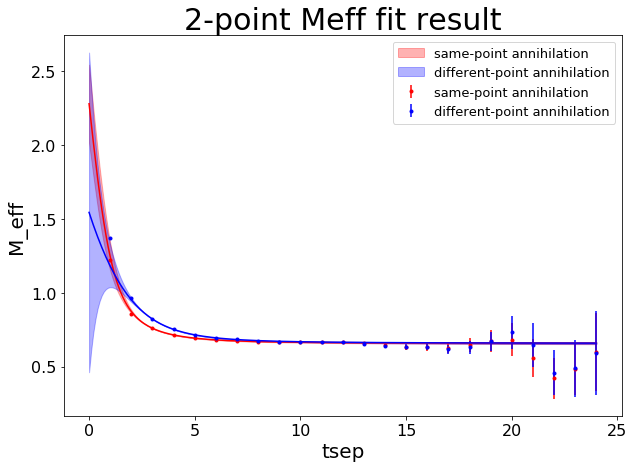

<Figure size 432x288 with 0 Axes>

In [45]:
x_raw2pt_fit = np.array([tsep_model, tsep_model])
y_raw2pt_fit_mean = np.array([C2ptSS_model_mean, C2ptPS_model_mean])
y_raw2pt_fit_upper = np.array([C2ptSS_model_upbound, C2ptPS_model_upbound])
y_raw2pt_fit_lower = np.array([C2ptSS_model_lowbound, C2ptPS_model_lowbound])

y_2ptmeff_fit_mean = np.array([SS_meff_model_mean, PS_meff_model_mean])
y_2ptmeff_fit_upper = np.array([SS_meff_model_upbound, PS_meff_model_upbound])
y_2ptmeff_fit_lower = np.array([SS_meff_model_lowbound, PS_meff_model_lowbound])

h5_dm.fit_data_plot("2-point Meff fit result", "tsep", "M_eff", x_raw2pt, y_2ptmeff_mean, x_raw2pt_fit[:,:-step_up], y_2ptmeff_fit_mean, y_2ptmeff_fit_upper, y_2ptmeff_fit_lower, ['red', 'blue'], 30, 20, 16, 13, ylim = None, nplots = 2, ydat_error = y_2ptmeff_sdev, datalabels = ["same-point annihilation", "different-point annihilation"], fitlabels = ["same-point annihilation", "different-point annihilation"])

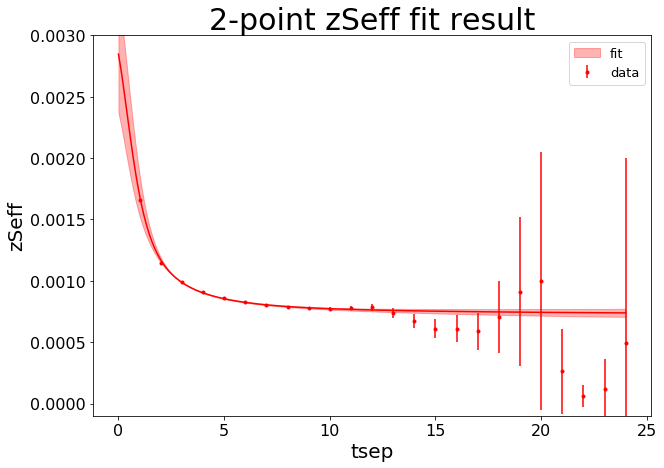

<Figure size 432x288 with 0 Axes>

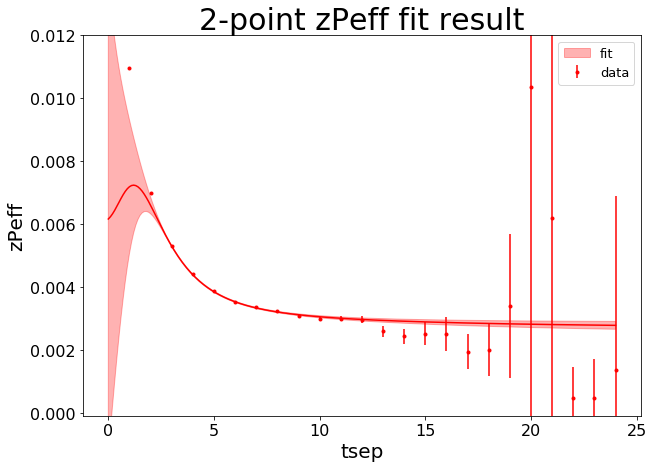

<Figure size 432x288 with 0 Axes>

In [46]:
h5_dm.fit_data_plot("2-point zSeff fit result", "tsep", "zSeff", x_raw2pt[0], [gv_avg_data['2pt_zSeff'][i].mean for i in t_plot], x_raw2pt_fit[0,:-step_up], zSeff_model_mean, zSeff_model_upbound, zSeff_model_lowbound, "red", 30, 20, 16, 13, ylim=[-0.0001, 0.003], ydat_error = [gv_avg_data['2pt_zSeff'][i].sdev for i in t_plot], datalabels = "data", fitlabels = "fit")
h5_dm.fit_data_plot("2-point zPeff fit result", "tsep", "zPeff", x_raw2pt[1], [gv_avg_data['2pt_zPeff'][i].mean for i in t_plot], x_raw2pt_fit[0,:-step_up], zPeff_model_mean, zPeff_model_upbound, zPeff_model_lowbound, "red", 30, 20, 16, 13, ylim=[-0.0001, 0.012], ydat_error = [gv_avg_data['2pt_zPeff'][i].sdev for i in t_plot], datalabels = "data", fitlabels = "fit")

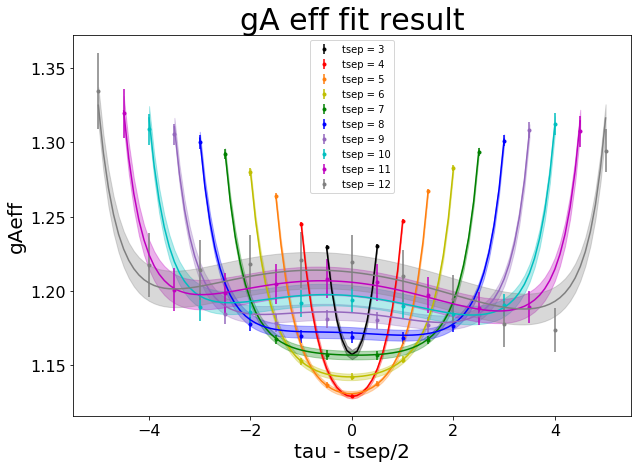

<Figure size 432x288 with 0 Axes>

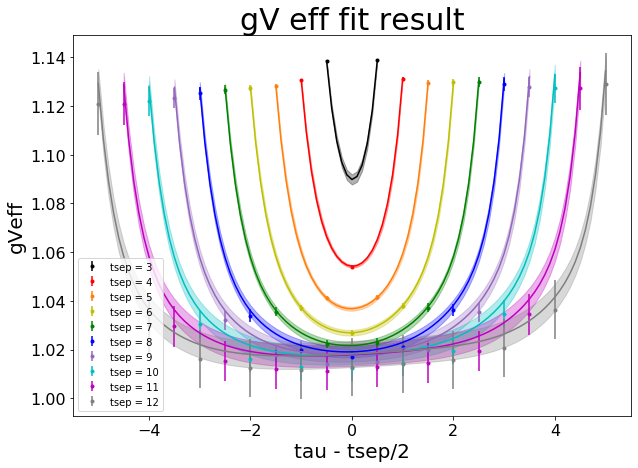

<Figure size 432x288 with 0 Axes>

In [47]:
colors_3pt = np.array(['k', 'r', 'tab:orange', 'y', 'g', 'b', 'tab:purple', 'c', 'm', 'tab:grey'])

h5_dm.fit_data_plot("gA eff fit result", "tau - tsep/2", "gAeff", x_3pt_data, y_3pt_A3, t_3pt_tseptau_diff, model_A3_ratio_2d_mean, model_A3_ratio_2d_upbound, model_A3_ratio_2d_lowbound, colors_3pt, 30, 20, 16, 13, nplots = len(gv_avg_data['C_ratio_A3']), ydat_error=y_3pt_A3_err, datalabels = legendlabels_3pt) 

h5_dm.fit_data_plot("gV eff fit result", "tau - tsep/2", "gVeff", x_3pt_data, y_3pt_V4, t_3pt_tseptau_diff, model_V4_ratio_2d_mean, model_V4_ratio_2d_upbound, model_V4_ratio_2d_lowbound, colors_3pt, 30, 20, 16, 13, nplots = len(gv_avg_data['C_ratio_V4']), ydat_error=y_3pt_V4_err, datalabels = legendlabels_3pt) 



#### Now, try the same, but with the 3-point data cut off at tau = 2

In [48]:
num_zs = 4
tau_cut_val = 2

x_2pt = np.array([l for l in range(3, 13)])
x_3pt = t_1d_array
x_all = np.append(x_2pt_mod, x_3pt, axis = 0)


y_2pt_SS = np.array([ gv_avg_data['2pt_SS'][l] for l in range(3,13)])
y_2pt_PS = np.array([ gv_avg_data['2pt_PS'][l] for l in range(3,13)])
y_2pt_all = np.transpose(np.array([[y_2pt_SS], [y_2pt_PS]]), axes=[2,0,1])
y_3pt_A3_2d = np.array([ [gv_avg_data['3pt_A3'][i][j] for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
y_3pt_A3 = convert_2dto1d(t_1d_array, t_2d_array, y_3pt_A3_2d)
y_3pt_V4_2d = np.array([ [gv_avg_data['3pt_V4'][i][j] for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
y_3pt_V4 = convert_2dto1d(t_1d_array, t_2d_array, y_3pt_V4_2d)
y_3pt = np.transpose(np.array([[y_3pt_A3], [y_3pt_V4]]), axes=[2,0,1])

# Create the dataset to be fit
x_1darray_tau2 = []
y_3pt_tau2 = []

    
for k in range(len(t_1d_array)):
    if(t_1d_array[k][0] >= 4):
        if(t_1d_array[k][1] >= tau_cut_val):
            if(t_1d_array[k][1] <= t_1d_array[k][0] - tau_cut_val):
                x_1darray_tau2.append(t_1d_array[k].tolist())
                y_3pt_tau2.append(y_3pt[k].tolist())
                            
x_1darray_tau2 = np.array(x_1darray_tau2)
y_3pt_tau2 = np.array(y_3pt_tau2)

x_all_tau2 = np.append(x_2pt_mod, x_1darray_tau2) 
y_all_tau2 = np.append(y_2pt_all, y_3pt_tau2)

x_all_dict = gv.BufferDict()
y_all_dict = gv.BufferDict()

x_all_dict['2pt'] = x_2pt
x_all_dict['3pt'] = x_1darray_tau2

y_all_dict['2pt'] = y_2pt_all
y_all_dict['3pt_combined'] = y_3pt_tau2


fit_simul_tau2 = lsqfit.nonlinear_fit(data=(x_all_dict, y_all_dict), prior=prior,fcn=all_at_once_dict,debug=True)
print(fit_simul_tau2.format(pstyle='vv'))
post_simul_tau2 = fit_simul_tau2.p

Least Square Fit:
  chi2/dof [dof] = 0.88 [110]    Q = 0.81    logGBF = 2787.5

Parameters:
             E0        0.65097 +- 0.00920345             [     0.67 +- 0.02 ]  
             Z0   0.000688335 +- 6.04686e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00255341 +- 0.000252061             [   0.003 +- 0.003 ]  
       log(dE1)         -1.86835 +- 0.376414             [  -0.97551 +- 0.9 ]  
             Z1   0.000469507 +- 9.28358e-05             [ 0.0012 +- 0.0006 ]  *
        Ztilde1    0.00219964 +- 0.000294925             [        0 +- 0.01 ]  
       log(dE2)        -0.780906 +- 0.250972             [  -0.97551 +- 0.9 ]  
             Z2   0.000414105 +- 0.000183371             [ 0.0012 +- 0.0006 ]  *
        Ztilde2     0.00492649 +- 0.00133326             [        0 +- 0.01 ]  
       log(dE3)         -0.99186 +- 0.372866             [  -0.97551 +- 0.9 ]  
             Z3    0.00110692 +- 7.57639e-05             [ 0.0012 +- 0.0006 ]  
        Ztilde3    0.00689

In [49]:
current_posterior = open('simul2pt3pt_tau2_n4_out.obj', 'wb')
pickle.dump(post_simul_tau2, current_posterior)
current_posterior.close()

### Now, plot the data against the fit

In [50]:
# Data
labels_2pt = np.array(["same-point annihilation", "different-point annihilation"])
t_plot = np.array([i for i in range(1, 25)])
x_raw2pt = np.array([t_plot, t_plot])
y_raw2pt_mean = np.array([[gv_avg_data['2pt_SS'][i].mean for i in t_plot], [gv_avg_data['2pt_PS'][i].mean for i in t_plot]])
y_raw2pt_sdev = np.array([[gv_avg_data['2pt_SS'][i].sdev for i in t_plot], [gv_avg_data['2pt_PS'][i].sdev for i in t_plot]])
y_2ptmeff_mean = np.array([[gv_avg_data['2pt_SS_meff'][i].mean for i in t_plot], [gv_avg_data['2pt_PS_meff'][i].mean for i in t_plot]])
y_2ptmeff_sdev = np.array([[gv_avg_data['2pt_SS_meff'][i].sdev for i in t_plot], [gv_avg_data['2pt_PS_meff'][i].sdev for i in t_plot]])
y_2ptZeff_mean = np.array([[gv_avg_data['2pt_zSeff'][i].mean for i in t_plot], [gv_avg_data['2pt_zPeff'][i].mean for i in t_plot]])
y_2ptZeff_sdev = np.array([[gv_avg_data['2pt_zSeff'][i].sdev for i in t_plot], [gv_avg_data['2pt_zPeff'][i].sdev for i in t_plot]])

x_3pt_data = np.array([[j - (i+3)/2. for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
y_3pt_A3 = np.array([ np.array([gv_avg_data['C_ratio_A3'][i][j].mean for j in range(len(gv_avg_data['C_ratio_A3'][i]))]) for i in range(len(tsep_vals))])
y_3pt_A3_err = np.array([ np.array([gv_avg_data['C_ratio_A3'][i][j].sdev for j in range(len(gv_avg_data['C_ratio_A3'][i]))]) for i in range(len(tsep_vals))])
y_3pt_V4 = np.array([ np.array([gv_avg_data['C_ratio_V4'][i][j].mean for j in range(len(gv_avg_data['C_ratio_V4'][i]))]) for i in range(len(tsep_vals))])
y_3pt_V4_err = np.array([ np.array([gv_avg_data['C_ratio_V4'][i][j].sdev for j in range(len(gv_avg_data['C_ratio_V4'][i]))]) for i in range(len(tsep_vals))])

x_CFH_data = np.array([i for i in tsep_vals[:-1] ])
y_CFH_A3 = np.array([gv_avg_data['C^FH_A3'][i].mean for i in range(len(tsep_vals)-1)])
y_CFH_A3_err = np.array([gv_avg_data['C^FH_A3'][i].sdev for i in range(len(tsep_vals)-1)])
y_CFH_V4 = np.array([gv_avg_data['C^FH_V4'][i].mean for i in range(len(tsep_vals)-1)])
y_CFH_V4_err = np.array([gv_avg_data['C^FH_V4'][i].sdev for i in range(len(tsep_vals)-1)])

legendlabels_3pt = np.array(["tsep = {}".format(i) for i in tsep_vals])

In [53]:
# Now, create a the fitline arrays for fit-plotting
step_up = 10
tau_step = 10
step_FH = 10
t_min = 0
t_max = 25
tsep_model = np.linspace(t_min, t_max, (t_max - t_min)*step_up +1)

t_3pt_fitresult_2d = np.array([ np.array([ [tsep, tau] for tau in np.linspace(1, tsep - 1, (tsep - 2)*step_up +1)]) for tsep in tsep_vals])
t_3pt_fitresult_tsep = np.zeros(np.sum(np.array([len(np.linspace(1, tsep - 1, (tsep - 2)*step_up +1)) for tsep in tsep_vals])))
t_3pt_fitresult_tau = np.zeros(np.sum(np.array([len(np.linspace(1, tsep - 1, (tsep - 2)*step_up +1)) for tsep in tsep_vals])))

k = 0
for tsep in tsep_vals:
    for tau in np.linspace(1, tsep - 1, (tsep - 2)*step_up +1):
        t_3pt_fitresult_tsep[k] = tsep
        t_3pt_fitresult_tau[k] = tau
        k += 1
        
t_3pt_fitresult_1d = np.transpose(np.array([t_3pt_fitresult_tsep, t_3pt_fitresult_tau]))

# Also, convert the 2-d tsep, tau array into an array of tau - tsep/2
t_3pt_tseptau_diff = np.array([ np.array([tau - tsep/2. for tau in np.linspace(1, tsep - 1, (tsep - 2)*step_up +1)]) for tsep in tsep_vals])

# Set up the Feynman-Hellman and sum-subtraction
t_FH_model = np.linspace(tsep_vals[0], tsep_vals[-1]+4, (tsep_vals[-1]+4 - tsep_vals[0])*step_FH + 1)

# Combine them all
t_all_model = np.array([tsep_model, t_3pt_fitresult_1d, t_FH_model])
C2ptSS_model = C_2pt_SS(tsep_model, post_simul_tau2)
C2ptPS_model = C_2pt_PS(tsep_model, post_simul_tau2)
model_A3_3pt_1d = C_3pt_A3(t_3pt_fitresult_1d, post_simul_tau2)
model_V4_3pt_1d = C_3pt_V4(t_3pt_fitresult_1d, post_simul_tau2)
model_A3_3pt_2d = convert_1dto2d(t_3pt_fitresult_1d, t_3pt_fitresult_2d, model_A3_3pt_1d)
model_V4_3pt_2d = convert_1dto2d(t_3pt_fitresult_1d, t_3pt_fitresult_2d, model_V4_3pt_1d)
#CFH_A3_model = C_FH_A3(t_FH_model, post_simul_tau2)
#CFH_V4_model = C_FH_V4(t_FH_model, post_simul_tau2post_simul)

SS_meff_model = np.log(np.array([C2ptSS_model[j]/C2ptSS_model[j+step_up] for j in range(len(tsep_model[:-step_up]))]))
PS_meff_model = np.log(np.array([C2ptPS_model[j]/C2ptPS_model[j+step_up] for j in range(len(tsep_model[:-step_up]))]))

zSeff_model = np.array([np.sqrt(np.exp(SS_meff_model[t]*t/step_up)*C2ptSS_model[t]) for t in range(len(tsep_model[:-step_up]))])
zPeff_model = np.array([np.exp(PS_meff_model[t]*t/step_up)*C2ptPS_model[t]/zSeff_model[t] for t in range(len(tsep_model[:-step_up]))])

# Split the models up into mean, upper-bound, and lower-bound
C2ptSS_model_mean = np.array([C2ptSS_model[i].mean for i in range(len(C2ptSS_model))])
C2ptSS_model_upbound = np.array([C2ptSS_model[i].mean + C2ptSS_model[i].sdev for i in range(len(C2ptSS_model))])
C2ptSS_model_lowbound = np.array([C2ptSS_model[i].mean - C2ptSS_model[i].sdev for i in range(len(C2ptSS_model))])
C2ptPS_model_mean = np.array([C2ptPS_model[i].mean for i in range(len(C2ptPS_model))])
C2ptPS_model_upbound = np.array([C2ptPS_model[i].mean + C2ptPS_model[i].sdev for i in range(len(C2ptPS_model))])
C2ptPS_model_lowbound = np.array([C2ptPS_model[i].mean - C2ptPS_model[i].sdev for i in range(len(C2ptPS_model))])

SS_meff_model_mean = np.array([SS_meff_model[i].mean for i in range(len(SS_meff_model))])
SS_meff_model_upbound = np.array([SS_meff_model[i].mean + SS_meff_model[i].sdev for i in range(len(SS_meff_model))])
SS_meff_model_lowbound = np.array([SS_meff_model[i].mean - SS_meff_model[i].sdev for i in range(len(SS_meff_model))])
PS_meff_model_mean = np.array([PS_meff_model[i].mean for i in range(len(PS_meff_model))])
PS_meff_model_upbound = np.array([PS_meff_model[i].mean + PS_meff_model[i].sdev for i in range(len(PS_meff_model))])
PS_meff_model_lowbound = np.array([PS_meff_model[i].mean - PS_meff_model[i].sdev for i in range(len(PS_meff_model))])

zSeff_model_mean = np.array([zSeff_model[i].mean for i in range(len(zSeff_model))]) 
zSeff_model_upbound = np.array([zSeff_model[i].mean + zSeff_model[i].sdev for i in range(len(zSeff_model))]) 
zSeff_model_lowbound = np.array([zSeff_model[i].mean - zSeff_model[i].sdev for i in range(len(zSeff_model))])
zPeff_model_mean = np.array([zPeff_model[i].mean for i in range(len(zPeff_model))]) 
zPeff_model_upbound = np.array([zPeff_model[i].mean + zPeff_model[i].sdev for i in range(len(zPeff_model))])
zPeff_model_lowbound = np.array([zPeff_model[i].mean - zPeff_model[i].sdev for i in range(len(zPeff_model))])

# Now, take the 3-point-2-point ratio, first take the respective 2-point function
model_ratio_2pt = C_2pt_SS(tsep_vals, post_simul_tau2)

model_A3_ratio_2d = np.array([ np.array([ model_A3_3pt_2d[i][j]/model_ratio_2pt[i] for j in range(len(model_A3_3pt_2d[i]))]) for i in range(len(model_A3_3pt_2d))])
model_V4_ratio_2d = np.array([ np.array([ model_V4_3pt_2d[i][j]/model_ratio_2pt[i] for j in range(len(model_V4_3pt_2d[i]))]) for i in range(len(model_V4_3pt_2d))])

# Now, to prepare for plotting, split the data into mean, upper-bound and lower-bound
model_A3_ratio_2d_mean = np.array([ [ model_A3_ratio_2d[i][j].mean for j in range(len(model_A3_ratio_2d[i]))] for i in range(len(model_A3_ratio_2d)) ])
model_A3_ratio_2d_upbound = np.array([ [ model_A3_ratio_2d[i][j].mean + model_A3_ratio_2d[i][j].sdev for j in range(len(model_A3_ratio_2d[i]))] for i in range(len(model_A3_ratio_2d)) ])
model_A3_ratio_2d_lowbound = np.array([ [ model_A3_ratio_2d[i][j].mean - model_A3_ratio_2d[i][j].sdev for j in range(len(model_A3_ratio_2d[i]))] for i in range(len(model_A3_ratio_2d)) ])

model_V4_ratio_2d_mean = np.array([ [ model_V4_ratio_2d[i][j].mean for j in range(len(model_V4_ratio_2d[i]))] for i in range(len(model_V4_ratio_2d)) ])
model_V4_ratio_2d_upbound = np.array([ [ model_V4_ratio_2d[i][j].mean + model_V4_ratio_2d[i][j].sdev for j in range(len(model_V4_ratio_2d[i]))] for i in range(len(model_V4_ratio_2d)) ])
model_V4_ratio_2d_lowbound = np.array([ [ model_V4_ratio_2d[i][j].mean - model_V4_ratio_2d[i][j].sdev for j in range(len(model_V4_ratio_2d[i]))] for i in range(len(model_V4_ratio_2d)) ])



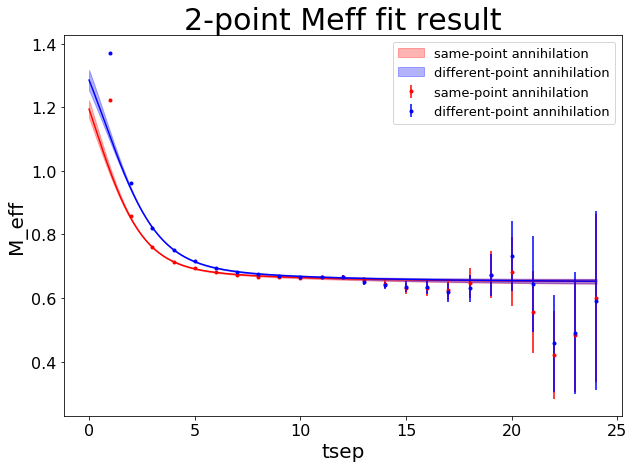

<Figure size 432x288 with 0 Axes>

In [54]:
x_raw2pt_fit = np.array([tsep_model, tsep_model])
y_raw2pt_fit_mean = np.array([C2ptSS_model_mean, C2ptPS_model_mean])
y_raw2pt_fit_upper = np.array([C2ptSS_model_upbound, C2ptPS_model_upbound])
y_raw2pt_fit_lower = np.array([C2ptSS_model_lowbound, C2ptPS_model_lowbound])

y_2ptmeff_fit_mean = np.array([SS_meff_model_mean, PS_meff_model_mean])
y_2ptmeff_fit_upper = np.array([SS_meff_model_upbound, PS_meff_model_upbound])
y_2ptmeff_fit_lower = np.array([SS_meff_model_lowbound, PS_meff_model_lowbound])

h5_dm.fit_data_plot("2-point Meff fit result", "tsep", "M_eff", x_raw2pt, y_2ptmeff_mean, x_raw2pt_fit[:,:-step_up], y_2ptmeff_fit_mean, y_2ptmeff_fit_upper, y_2ptmeff_fit_lower, ['red', 'blue'], 30, 20, 16, 13, ylim = None, nplots = 2, ydat_error = y_2ptmeff_sdev, datalabels = ["same-point annihilation", "different-point annihilation"], fitlabels = ["same-point annihilation", "different-point annihilation"])

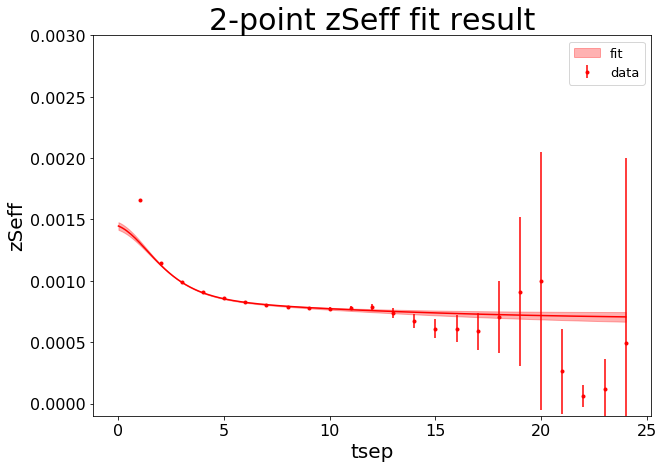

<Figure size 432x288 with 0 Axes>

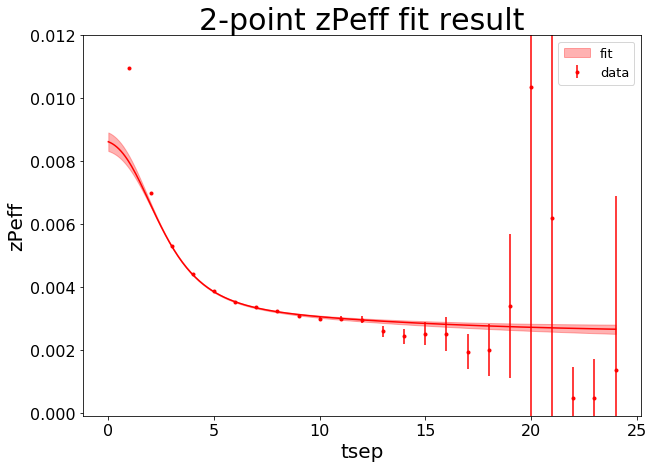

<Figure size 432x288 with 0 Axes>

In [55]:
h5_dm.fit_data_plot("2-point zSeff fit result", "tsep", "zSeff", x_raw2pt[0], [gv_avg_data['2pt_zSeff'][i].mean for i in t_plot], x_raw2pt_fit[0,:-step_up], zSeff_model_mean, zSeff_model_upbound, zSeff_model_lowbound, "red", 30, 20, 16, 13, ylim=[-0.0001, 0.003], ydat_error = [gv_avg_data['2pt_zSeff'][i].sdev for i in t_plot], datalabels = "data", fitlabels = "fit")
h5_dm.fit_data_plot("2-point zPeff fit result", "tsep", "zPeff", x_raw2pt[1], [gv_avg_data['2pt_zPeff'][i].mean for i in t_plot], x_raw2pt_fit[0,:-step_up], zPeff_model_mean, zPeff_model_upbound, zPeff_model_lowbound, "red", 30, 20, 16, 13, ylim=[-0.0001, 0.012], ydat_error = [gv_avg_data['2pt_zPeff'][i].sdev for i in t_plot], datalabels = "data", fitlabels = "fit")

[list([-0.5, 0.5]) list([-1.0, 0.0, 1.0]) list([-1.5, -0.5, 0.5, 1.5])
 list([-2.0, -1.0, 0.0, 1.0, 2.0]) list([-2.5, -1.5, -0.5, 0.5, 1.5, 2.5])
 list([-3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0])
 list([-3.5, -2.5, -1.5, -0.5, 0.5, 1.5, 2.5, 3.5])
 list([-4.0, -3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0])
 list([-4.5, -3.5, -2.5, -1.5, -0.5, 0.5, 1.5, 2.5, 3.5, 4.5])
 list([-5.0, -4.0, -3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0])]
[array([1.22948653, 1.23043176])
 array([1.24511272, 1.12911504, 1.24715104])
 array([1.26408926, 1.13658814, 1.13750236, 1.26702087])
 array([1.28008458, 1.15262906, 1.1422122 , 1.15371275, 1.28268815])
 array([1.29225314, 1.16738478, 1.15676178, 1.15649022, 1.16701901,
       1.29341666])
 array([1.30047282, 1.17765951, 1.16929791, 1.16885643, 1.16799239,
       1.17608424, 1.30111217])
 array([1.3053317 , 1.18410074, 1.17839337, 1.18089024, 1.18009565,
       1.17684057, 1.18371736, 1.30850508])
 array([1.308739  , 1.18898057, 1.18585296, 1.1915555 , 1.19360

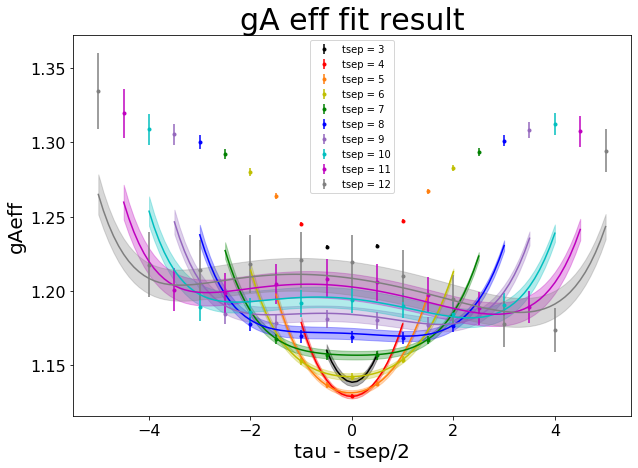

(10,)
(10,)


<Figure size 432x288 with 0 Axes>

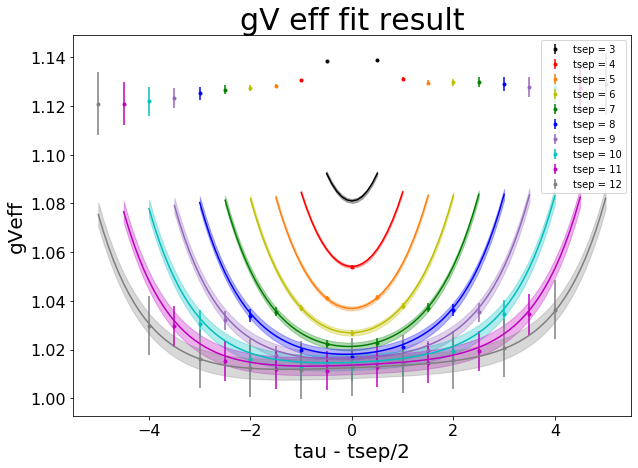

<Figure size 432x288 with 0 Axes>

In [56]:
colors_3pt = np.array(['k', 'r', 'tab:orange', 'y', 'g', 'b', 'tab:purple', 'c', 'm', 'tab:grey'])
print(x_3pt_data)
print(y_3pt_A3)

h5_dm.fit_data_plot("gA eff fit result", "tau - tsep/2", "gAeff", x_3pt_data, y_3pt_A3, t_3pt_tseptau_diff, model_A3_ratio_2d_mean, model_A3_ratio_2d_upbound, model_A3_ratio_2d_lowbound, colors_3pt, 30, 20, 16, 13, nplots = len(gv_avg_data['C_ratio_A3']), ydat_error=y_3pt_A3_err, datalabels = legendlabels_3pt) 
print(np.shape(x_3pt_data))
print(np.shape(model_A3_3pt_2d))

h5_dm.fit_data_plot("gV eff fit result", "tau - tsep/2", "gVeff", x_3pt_data, y_3pt_V4, t_3pt_tseptau_diff, model_V4_ratio_2d_mean, model_V4_ratio_2d_upbound, model_V4_ratio_2d_lowbound, colors_3pt, 30, 20, 16, 13, nplots = len(gv_avg_data['C_ratio_V4']), ydat_error=y_3pt_V4_err, datalabels = legendlabels_3pt) 


 


### Now, include the fit to the Feynman-Hellman data in the chained fit

In [57]:
num_zs = 7
num_states_FH = 2

# prior the fits
prior = gv.BufferDict()

# This is the exponent e_decay_exp such that the increment between two consecutive excited state energies decays as 1/n^e_decay_exp, where n is the order of the excited state energy 
e_decay_exp = 0

prior['E0'] = gv.gvar(0.67, 0.02)
prior['Z0'] = gv.gvar(0.0008, 0.0003)
prior['Ztilde0'] = gv.gvar(0.003, 0.003)

#prior_2ptstep['E1'] = gv.gvar(1.3, 0.23)
#prior_2ptstep['log(E1)'] = gv.gvar(np.log(1.3), np.log(1.3/(1.3 - 0.3)))
#prior_2ptstep['Z1'] = gv.gvar(0.0012, 0.0006)
#prior_2ptstep['Ztilde1'] = gv.gvar(0.006, 0.005)

# Define some constants for prioring the higher-order energies
dE0 = 2*mpi
b = 0.7

# Use constant dE to prior the energies
dE0 = 2*mpi
energyvals = np.array([None]*num_zs)
dEvals = np.array([None]*(num_zs - 1))

#E0_errbar = 0.8
energyvals[0] = gv.gvar(0.67, 0.02)
for k in range(1, num_zs):
    dEvals[k-1] = dE0/np.power(k, e_decay_exp)
    energyvals[k] = energyvals[k-1] + dEvals[k-1]

for n in range(1, num_zs):
    prior['log(dE{})'.format(n)] = gv.gvar(np.log(dEvals[n-1]), b)
    prior['Z{}'.format(n)] = gv.gvar(0.0012, 0.0006)
    prior['Ztilde{}'.format(n)] = gv.gvar(0, 0.01)
    
    # Insert priors for energy here
    #dE_next = dE0/np.power(n, e_decay_exp)
    #E_next = prior_2ptstep['E{}'.format(n-1)].mean + dE_next
    #sigma_next = np.log(E_next/(E_next - (dE_next*b)))

print(num_states_FH - 2)

for n in range(num_zs):
    prior["d_gA_ss_{}".format(n)] = gv.gvar(0,0.00001)
    prior["d_gA_ps_{}".format(n)] = gv.gvar(0,0.00001)
    prior["d_gV_ss_{}".format(n)] = gv.gvar(0,0.00001)
    prior["d_gV_ps_{}".format(n)] = gv.gvar(0,0.00001)
    for m in range(num_zs):
        
        prior['gA3_{0}{1}'.format(n, m)] = gv.gvar(0, 2)
        if n == m and n < num_zs-1:
            prior['gV4_{0}{1}'.format(n, m)] = gv.gvar(1, 0.1)
        else:
            prior['gV4_{0}{1}'.format(n, m)] = gv.gvar(0, 2)

prior['gA3_00'] = gv.gvar(1.25, 0.15)
prior['gV4_00'] = gv.gvar(1.07, 0.07)

# Set the "garbage can" for the Feynman Hellman fit, post-Lattice-QCD stage
prior['Z_FHmax'] = gv.gvar(0.0012, 0.0006)
prior['Ztilde_FHmax'] = gv.gvar(0, 0.01)
prior['log(FH_dEmax)'] = gv.gvar(np.log(dEvals[num_states_FH - 2]), b) 

for n in range(num_states_FH-1):
    prior['gA3_FHmax{}'.format(n)] = gv.gvar(0, 2)
    prior['gA3_{}FHmax'.format(n)] = gv.gvar(0, 2)
    prior['gV4_FHmax{}'.format(n)] = gv.gvar(0, 2)
    prior['gV4_{}FHmax'.format(n)] = gv.gvar(0, 2)
    
prior['gA3_FHmaxFHmax'] = gv.gvar(0, 2)
prior['gV4_FHmaxFHmax'] = gv.gvar(0, 2)

# Set the "garbage can" for the Feynman Hellman fit, Lattice-QCD stage
#prior['Z_FHdatamax'] = gv.gvar(0.0012, 0.0006)
#prior['Ztilde_FHdatamax'] = gv.gvar(0, 0.01)
#prior['log(FHdata_dEmax)'] = gv.gvar(np.log(dEvals[num_states_FH - 2]), b) 

#for n in range(num_states_FH-1):
    #prior['gA3_FHdatamax{}'.format(n)] = gv.gvar(1, 2)
    #prior['gA3_{}FHdatamax'.format(n)] = gv.gvar(1, 2)
    #prior['gV4_FHdatamax{}'.format(n)] = gv.gvar(0, 2)
    #prior['gV4_{}FHdatamax'.format(n)] = gv.gvar(0, 2)
    
#prior['gA3_FHdatamaxFHdatamax'] = gv.gvar(1, 2)
#prior['gV4_FHdatamaxFHdatamax'] = gv.gvar(0, 2)

#prior

0


In [58]:
# Repackage the data into a format that it could be fitted into
x_2pt = np.array([l for l in range(3, 13)])
x_2pt_mod = np.array([np.array([None, x_2pt_el]) for x_2pt_el in x_2pt])
x_3pt = t_1d_array
x_all = np.append(x_2pt_mod, x_3pt, axis = 0)

y_2pt_SS = np.array([ gv_avg_data['2pt_SS'][l] for l in range(3,13)])
y_2pt_PS = np.array([ gv_avg_data['2pt_PS'][l] for l in range(3,13)])
y_2pt_all = np.transpose(np.array([[y_2pt_SS], [y_2pt_PS]]), axes=[2,0,1])
y_3pt_A3_2d = np.array([ [gv_avg_data['3pt_A3'][i][j] for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
y_3pt_A3 = convert_2dto1d(t_1d_array, t_2d_array, y_3pt_A3_2d)
y_3pt_V4_2d = np.array([ [gv_avg_data['3pt_V4'][i][j] for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
y_3pt_V4 = convert_2dto1d(t_1d_array, t_2d_array, y_3pt_V4_2d)
y_3pt_all = np.transpose(np.array([[y_3pt_A3], [y_3pt_V4]]), axes=[2,0,1])
y_all = np.append(y_2pt_all, y_3pt_all, axis = 0)

# Try creating a dictionary for the dictionary-version all-at-once
x_all_dict = gv.BufferDict()
y_all_dict = gv.BufferDict()

x_all_dict['2pt'] = x_2pt
x_all_dict['3pt'] = x_3pt
x_all_dict['FH'] = tsep_vals[:-1]

y_all_dict['2pt'] = y_2pt_all
y_all_dict['3pt_combined'] = y_3pt_all
y_all_dict['FH'] = gv_avg_data['FH'][np.min(tsep_vals):np.max(tsep_vals)]

fit_simul = lsqfit.nonlinear_fit(data=(x_all_dict, y_all_dict), prior=prior,fcn=all_at_once_dict,debug=True)
print(fit_simul.format(pstyle='vv'))
post_simul = fit_simul.p
# chi2/dof [dof] = 0.85 [186]    Q = 0.94    logGBF = 3892.8
# chi2/dof [dof] = 0.83 [186]    Q = 0.96    logGBF = 3868.1
# chi2/dof [dof] = 0.8 [186]    Q = 0.98    logGBF = 3879.4

Least Square Fit:
  chi2/dof [dof] = 1.1 [186]    Q = 0.23    logGBF = 3921.5

Parameters:
             E0        0.661332 +- 0.00278957             [     0.67 +- 0.02 ]  
             Z0    0.000757632 +- 1.10451e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0      0.0028643 +- 4.78927e-05             [   0.003 +- 0.003 ]  
       log(dE1)         -0.871711 +- 0.140046             [  -0.97551 +- 0.7 ]  
             Z1    0.000594288 +- 7.85879e-05             [ 0.0012 +- 0.0006 ]  *
        Ztilde1      0.00394109 +- 0.00069789             [        0 +- 0.01 ]  
       log(dE2)         -0.601672 +- 0.264805             [  -0.97551 +- 0.7 ]  
             Z2    0.000759292 +- 0.000305534             [ 0.0012 +- 0.0006 ]  
        Ztilde2      0.00689169 +- 0.00313436             [        0 +- 0.01 ]  
       log(dE3)          -1.06184 +- 0.603472             [  -0.97551 +- 0.7 ]  
             Z3    0.000948823 +- 0.000317009             [ 0.0012 +- 0.0006 ]  
        Ztilde3  

In [59]:
current_posterior = open('simul2pt3pt_n5_withFH_out.obj', 'wb')
pickle.dump(post_simul, current_posterior)
current_posterior.close() #n=6: 3791

#### Now, try the same, but with the 3-point data cut off at tau = 2

In [60]:
num_zs = 4
tau_cut_val = 3

# Repackage the data into a format that it could be fitted into
x_2pt = np.array([l for l in range(3, 13)])
x_2pt_mod = np.array([np.array([None, x_2pt_el]) for x_2pt_el in x_2pt])
x_3pt = t_1d_array
x_all = np.append(x_2pt_mod, x_3pt, axis = 0)

y_2pt_SS = np.array([ gv_avg_data['2pt_SS'][l] for l in range(3,13)])
y_2pt_PS = np.array([ gv_avg_data['2pt_PS'][l] for l in range(3,13)])
y_2pt_all = np.transpose(np.array([[y_2pt_SS], [y_2pt_PS]]), axes=[2,0,1])
y_3pt_A3_2d = np.array([ [gv_avg_data['3pt_A3'][i][j] for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
y_3pt_A3 = convert_2dto1d(t_1d_array, t_2d_array, y_3pt_A3_2d)
y_3pt_V4_2d = np.array([ [gv_avg_data['3pt_V4'][i][j] for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
y_3pt_V4 = convert_2dto1d(t_1d_array, t_2d_array, y_3pt_V4_2d)
y_3pt_all = np.transpose(np.array([[y_3pt_A3], [y_3pt_V4]]), axes=[2,0,1])
y_all = np.append(y_2pt_all, y_3pt_all, axis = 0)

# Create the dataset to be fit
x_1darray_tau2 = []
y_3pt_tau2 = []

    
for k in range(len(t_1d_array)):
    if(t_1d_array[k][0] >= 4):
        if(t_1d_array[k][1] >= tau_cut_val):
            if(t_1d_array[k][1] <= t_1d_array[k][0] - tau_cut_val):
                x_1darray_tau2.append(t_1d_array[k].tolist())
                y_3pt_tau2.append(y_3pt_all[k].tolist())
                            
x_1darray_tau2 = np.array(x_1darray_tau2)
y_3pt_tau2 = np.array(y_3pt_tau2)

# Try creating a dictionary for the dictionary-version all-at-once
x_all_dict = gv.BufferDict()
y_all_dict = gv.BufferDict()

x_all_dict['2pt'] = x_2pt
x_all_dict['3pt'] = x_1darray_tau2
x_all_dict['FH'] = tsep_vals[:-1]

y_all_dict['2pt'] = y_2pt_all
y_all_dict['3pt_combined'] = y_3pt_tau2
y_all_dict['FH'] = gv_avg_data['FH'][np.min(tsep_vals):np.max(tsep_vals)]

fit_simul_tau2 = lsqfit.nonlinear_fit(data=(x_all_dict, y_all_dict), prior=prior,fcn=all_at_once_dict,debug=True)
print(fit_simul.format(pstyle='vv'))
post_simul_tau2 = fit_simul_tau2.p


fit_simul_tau2 = lsqfit.nonlinear_fit(data=(x_all_dict, y_all_dict), prior=prior,fcn=all_at_once_dict,debug=True)
print(fit_simul_tau2.format(pstyle='vv'))
post_simul_tau2 = fit_simul_tau2.p

Least Square Fit:
  chi2/dof [dof] = 1.1 [186]    Q = 0.23    logGBF = 3921.5

Parameters:
             E0        0.661332 +- 0.00278957             [     0.67 +- 0.02 ]  
             Z0    0.000757632 +- 1.10451e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0      0.0028643 +- 4.78927e-05             [   0.003 +- 0.003 ]  
       log(dE1)         -0.871711 +- 0.140046             [  -0.97551 +- 0.7 ]  
             Z1    0.000594288 +- 7.85879e-05             [ 0.0012 +- 0.0006 ]  *
        Ztilde1      0.00394109 +- 0.00069789             [        0 +- 0.01 ]  
       log(dE2)         -0.601672 +- 0.264805             [  -0.97551 +- 0.7 ]  
             Z2    0.000759292 +- 0.000305534             [ 0.0012 +- 0.0006 ]  
        Ztilde2      0.00689169 +- 0.00313436             [        0 +- 0.01 ]  
       log(dE3)          -1.06184 +- 0.603472             [  -0.97551 +- 0.7 ]  
             Z3    0.000948823 +- 0.000317009             [ 0.0012 +- 0.0006 ]  
        Ztilde3  

Least Square Fit:
  chi2/dof [dof] = 0.76 [112]    Q = 0.97    logGBF = 2039.3

Parameters:
             E0        0.656099 +- 0.00555407             [     0.67 +- 0.02 ]  
             Z0    0.000729802 +- 2.90117e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0     0.00274211 +- 0.000121397             [   0.003 +- 0.003 ]  
       log(dE1)            -1.3859 +- 0.37541             [  -0.97551 +- 0.7 ]  
             Z1    0.000451718 +- 0.000109857             [ 0.0012 +- 0.0006 ]  *
        Ztilde1      0.0023325 +- 0.000710808             [        0 +- 0.01 ]  
       log(dE2)         -0.892257 +- 0.315954             [  -0.97551 +- 0.7 ]  
             Z2    0.000632606 +- 0.000193904             [ 0.0012 +- 0.0006 ]  
        Ztilde2      0.00566602 +- 0.00122572             [        0 +- 0.01 ]  
       log(dE3)         -0.505682 +- 0.343949             [  -0.97551 +- 0.7 ]  
             Z3     0.00117185 +- 0.000131511             [ 0.0012 +- 0.0006 ]  
        Ztilde3 

In [61]:
current_posterior = open('simul2pt3pt_tau2_withFH_n4_out.obj', 'wb')
pickle.dump(post_simul_tau2, current_posterior)
current_posterior.close()

### Now, plot the data against the fit

In [62]:
# Data
labels_2pt = np.array(["same-point annihilation", "different-point annihilation"])
t_plot = np.array([i for i in range(1, 25)])
x_raw2pt = np.array([t_plot, t_plot])
y_raw2pt_mean = np.array([[gv_avg_data['2pt_SS'][i].mean for i in t_plot], [gv_avg_data['2pt_PS'][i].mean for i in t_plot]])
y_raw2pt_sdev = np.array([[gv_avg_data['2pt_SS'][i].sdev for i in t_plot], [gv_avg_data['2pt_PS'][i].sdev for i in t_plot]])
y_2ptmeff_mean = np.array([[gv_avg_data['2pt_SS_meff'][i].mean for i in t_plot], [gv_avg_data['2pt_PS_meff'][i].mean for i in t_plot]])
y_2ptmeff_sdev = np.array([[gv_avg_data['2pt_SS_meff'][i].sdev for i in t_plot], [gv_avg_data['2pt_PS_meff'][i].sdev for i in t_plot]])
y_2ptZeff_mean = np.array([[gv_avg_data['2pt_zSeff'][i].mean for i in t_plot], [gv_avg_data['2pt_zPeff'][i].mean for i in t_plot]])
y_2ptZeff_sdev = np.array([[gv_avg_data['2pt_zSeff'][i].sdev for i in t_plot], [gv_avg_data['2pt_zPeff'][i].sdev for i in t_plot]])

x_3pt_data = np.array([[j - (i+3)/2. for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
y_3pt_A3 = np.array([ np.array([gv_avg_data['C_ratio_A3'][i][j].mean for j in range(len(gv_avg_data['C_ratio_A3'][i]))]) for i in range(len(tsep_vals))])
y_3pt_A3_err = np.array([ np.array([gv_avg_data['C_ratio_A3'][i][j].sdev for j in range(len(gv_avg_data['C_ratio_A3'][i]))]) for i in range(len(tsep_vals))])
y_3pt_V4 = np.array([ np.array([gv_avg_data['C_ratio_V4'][i][j].mean for j in range(len(gv_avg_data['C_ratio_V4'][i]))]) for i in range(len(tsep_vals))])
y_3pt_V4_err = np.array([ np.array([gv_avg_data['C_ratio_V4'][i][j].sdev for j in range(len(gv_avg_data['C_ratio_V4'][i]))]) for i in range(len(tsep_vals))])

x_CFH_data = np.array([i for i in tsep_vals[:-1] ])
y_CFH_A3 = np.array([gv_avg_data['C^FH_A3'][i].mean for i in range(len(tsep_vals)-1)])
y_CFH_A3_err = np.array([gv_avg_data['C^FH_A3'][i].sdev for i in range(len(tsep_vals)-1)])
y_CFH_V4 = np.array([gv_avg_data['C^FH_V4'][i].mean for i in range(len(tsep_vals)-1)])
y_CFH_V4_err = np.array([gv_avg_data['C^FH_V4'][i].sdev for i in range(len(tsep_vals)-1)])

legendlabels_3pt = np.array(["tsep = {}".format(i) for i in tsep_vals])

In [63]:
# Now, create a the fitline arrays for fit-plotting
step_up = 10
tau_step = 10
step_FH = 10
t_min = 0
t_max = 25
tsep_model = np.linspace(t_min, t_max, (t_max - t_min)*step_up +1)

t_3pt_fitresult_2d = np.array([ np.array([ [tsep, tau] for tau in np.linspace(1, tsep - 1, (tsep - 2)*step_up +1)]) for tsep in tsep_vals])
t_3pt_fitresult_tsep = np.zeros(np.sum(np.array([len(np.linspace(1, tsep - 1, (tsep - 2)*step_up +1)) for tsep in tsep_vals])))
t_3pt_fitresult_tau = np.zeros(np.sum(np.array([len(np.linspace(1, tsep - 1, (tsep - 2)*step_up +1)) for tsep in tsep_vals])))

k = 0
for tsep in tsep_vals:
    for tau in np.linspace(1, tsep - 1, (tsep - 2)*step_up +1):
        t_3pt_fitresult_tsep[k] = tsep
        t_3pt_fitresult_tau[k] = tau
        k += 1
        
t_3pt_fitresult_1d = np.transpose(np.array([t_3pt_fitresult_tsep, t_3pt_fitresult_tau]))

# Also, convert the 2-d tsep, tau array into an array of tau - tsep/2
t_3pt_tseptau_diff = np.array([ np.array([tau - tsep/2. for tau in np.linspace(1, tsep - 1, (tsep - 2)*step_up +1)]) for tsep in tsep_vals])

# Set up the Feynman-Hellman and sum-subtraction
t_FH_model = np.linspace(tsep_vals[0], tsep_vals[-1]+4, (tsep_vals[-1]+4 - tsep_vals[0])*step_FH + 1)

# Combine them all
t_all_model = np.array([tsep_model, t_3pt_fitresult_1d, t_FH_model])
C2ptSS_model = C_2pt_SS(tsep_model, post_simul_tau2)
C2ptPS_model = C_2pt_PS(tsep_model, post_simul_tau2)
model_A3_3pt_1d = C_3pt_A3(t_3pt_fitresult_1d, post_simul_tau2)
model_V4_3pt_1d = C_3pt_V4(t_3pt_fitresult_1d, post_simul_tau2)
model_A3_3pt_2d = convert_1dto2d(t_3pt_fitresult_1d, t_3pt_fitresult_2d, model_A3_3pt_1d)
model_V4_3pt_2d = convert_1dto2d(t_3pt_fitresult_1d, t_3pt_fitresult_2d, model_V4_3pt_1d)
#CFH_A3_model = C_FH_A3(t_FH_model, post_simul_tau2)
#CFH_V4_model = C_FH_V4(t_FH_model, post_simul_tau2post_simul)

SS_meff_model = np.log(np.array([C2ptSS_model[j]/C2ptSS_model[j+step_up] for j in range(len(tsep_model[:-step_up]))]))
PS_meff_model = np.log(np.array([C2ptPS_model[j]/C2ptPS_model[j+step_up] for j in range(len(tsep_model[:-step_up]))]))

zSeff_model = np.array([np.sqrt(np.exp(SS_meff_model[t]*t/step_up)*C2ptSS_model[t]) for t in range(len(tsep_model[:-step_up]))])
zPeff_model = np.array([np.exp(PS_meff_model[t]*t/step_up)*C2ptPS_model[t]/zSeff_model[t] for t in range(len(tsep_model[:-step_up]))])

# Split the models up into mean, upper-bound, and lower-bound
C2ptSS_model_mean = np.array([C2ptSS_model[i].mean for i in range(len(C2ptSS_model))])
C2ptSS_model_upbound = np.array([C2ptSS_model[i].mean + C2ptSS_model[i].sdev for i in range(len(C2ptSS_model))])
C2ptSS_model_lowbound = np.array([C2ptSS_model[i].mean - C2ptSS_model[i].sdev for i in range(len(C2ptSS_model))])
C2ptPS_model_mean = np.array([C2ptPS_model[i].mean for i in range(len(C2ptPS_model))])
C2ptPS_model_upbound = np.array([C2ptPS_model[i].mean + C2ptPS_model[i].sdev for i in range(len(C2ptPS_model))])
C2ptPS_model_lowbound = np.array([C2ptPS_model[i].mean - C2ptPS_model[i].sdev for i in range(len(C2ptPS_model))])

SS_meff_model_mean = np.array([SS_meff_model[i].mean for i in range(len(SS_meff_model))])
SS_meff_model_upbound = np.array([SS_meff_model[i].mean + SS_meff_model[i].sdev for i in range(len(SS_meff_model))])
SS_meff_model_lowbound = np.array([SS_meff_model[i].mean - SS_meff_model[i].sdev for i in range(len(SS_meff_model))])
PS_meff_model_mean = np.array([PS_meff_model[i].mean for i in range(len(PS_meff_model))])
PS_meff_model_upbound = np.array([PS_meff_model[i].mean + PS_meff_model[i].sdev for i in range(len(PS_meff_model))])
PS_meff_model_lowbound = np.array([PS_meff_model[i].mean - PS_meff_model[i].sdev for i in range(len(PS_meff_model))])

zSeff_model_mean = np.array([zSeff_model[i].mean for i in range(len(zSeff_model))]) 
zSeff_model_upbound = np.array([zSeff_model[i].mean + zSeff_model[i].sdev for i in range(len(zSeff_model))]) 
zSeff_model_lowbound = np.array([zSeff_model[i].mean - zSeff_model[i].sdev for i in range(len(zSeff_model))])
zPeff_model_mean = np.array([zPeff_model[i].mean for i in range(len(zPeff_model))]) 
zPeff_model_upbound = np.array([zPeff_model[i].mean + zPeff_model[i].sdev for i in range(len(zPeff_model))])
zPeff_model_lowbound = np.array([zPeff_model[i].mean - zPeff_model[i].sdev for i in range(len(zPeff_model))])

# Now, take the 3-point-2-point ratio, first take the respective 2-point function
model_ratio_2pt = C_2pt_SS(tsep_vals, post_simul_tau2)

model_A3_ratio_2d = np.array([ np.array([ model_A3_3pt_2d[i][j]/model_ratio_2pt[i] for j in range(len(model_A3_3pt_2d[i]))]) for i in range(len(model_A3_3pt_2d))])
model_V4_ratio_2d = np.array([ np.array([ model_V4_3pt_2d[i][j]/model_ratio_2pt[i] for j in range(len(model_V4_3pt_2d[i]))]) for i in range(len(model_V4_3pt_2d))])

# Now, to prepare for plotting, split the data into mean, upper-bound and lower-bound
model_A3_ratio_2d_mean = np.array([ [ model_A3_ratio_2d[i][j].mean for j in range(len(model_A3_ratio_2d[i]))] for i in range(len(model_A3_ratio_2d)) ])
model_A3_ratio_2d_upbound = np.array([ [ model_A3_ratio_2d[i][j].mean + model_A3_ratio_2d[i][j].sdev for j in range(len(model_A3_ratio_2d[i]))] for i in range(len(model_A3_ratio_2d)) ])
model_A3_ratio_2d_lowbound = np.array([ [ model_A3_ratio_2d[i][j].mean - model_A3_ratio_2d[i][j].sdev for j in range(len(model_A3_ratio_2d[i]))] for i in range(len(model_A3_ratio_2d)) ])

model_V4_ratio_2d_mean = np.array([ [ model_V4_ratio_2d[i][j].mean for j in range(len(model_V4_ratio_2d[i]))] for i in range(len(model_V4_ratio_2d)) ])
model_V4_ratio_2d_upbound = np.array([ [ model_V4_ratio_2d[i][j].mean + model_V4_ratio_2d[i][j].sdev for j in range(len(model_V4_ratio_2d[i]))] for i in range(len(model_V4_ratio_2d)) ])
model_V4_ratio_2d_lowbound = np.array([ [ model_V4_ratio_2d[i][j].mean - model_V4_ratio_2d[i][j].sdev for j in range(len(model_V4_ratio_2d[i]))] for i in range(len(model_V4_ratio_2d)) ])



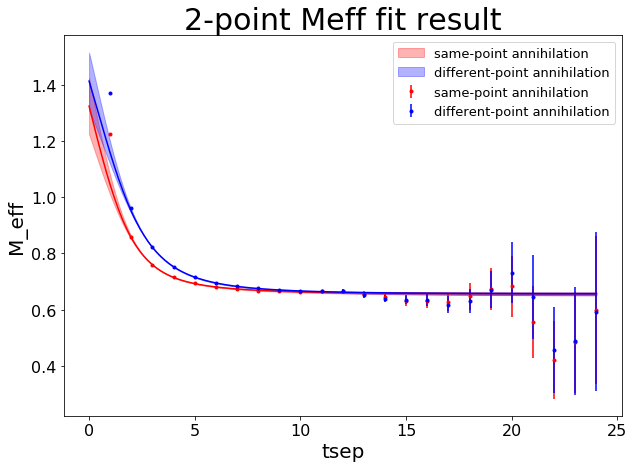

<Figure size 432x288 with 0 Axes>

In [64]:
x_raw2pt_fit = np.array([tsep_model, tsep_model])
y_raw2pt_fit_mean = np.array([C2ptSS_model_mean, C2ptPS_model_mean])
y_raw2pt_fit_upper = np.array([C2ptSS_model_upbound, C2ptPS_model_upbound])
y_raw2pt_fit_lower = np.array([C2ptSS_model_lowbound, C2ptPS_model_lowbound])

y_2ptmeff_fit_mean = np.array([SS_meff_model_mean, PS_meff_model_mean])
y_2ptmeff_fit_upper = np.array([SS_meff_model_upbound, PS_meff_model_upbound])
y_2ptmeff_fit_lower = np.array([SS_meff_model_lowbound, PS_meff_model_lowbound])

h5_dm.fit_data_plot("2-point Meff fit result", "tsep", "M_eff", x_raw2pt, y_2ptmeff_mean, x_raw2pt_fit[:,:-step_up], y_2ptmeff_fit_mean, y_2ptmeff_fit_upper, y_2ptmeff_fit_lower, ['red', 'blue'], 30, 20, 16, 13, ylim = None, nplots = 2, ydat_error = y_2ptmeff_sdev, datalabels = ["same-point annihilation", "different-point annihilation"], fitlabels = ["same-point annihilation", "different-point annihilation"])

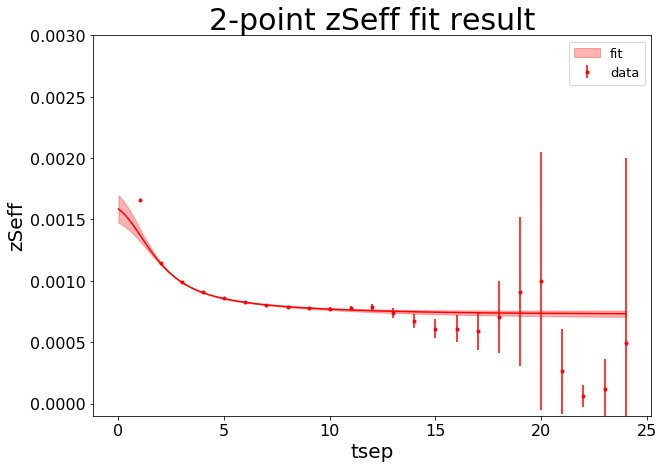

<Figure size 432x288 with 0 Axes>

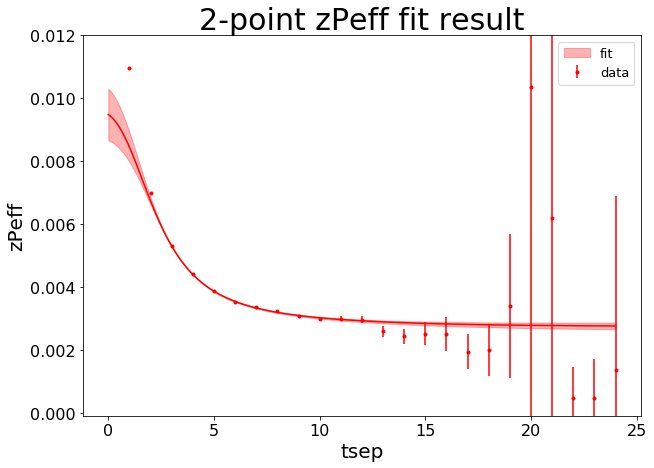

<Figure size 432x288 with 0 Axes>

In [65]:
h5_dm.fit_data_plot("2-point zSeff fit result", "tsep", "zSeff", x_raw2pt[0], [gv_avg_data['2pt_zSeff'][i].mean for i in t_plot], x_raw2pt_fit[0,:-step_up], zSeff_model_mean, zSeff_model_upbound, zSeff_model_lowbound, "red", 30, 20, 16, 13, ylim=[-0.0001, 0.003], ydat_error = [gv_avg_data['2pt_zSeff'][i].sdev for i in t_plot], datalabels = "data", fitlabels = "fit")
h5_dm.fit_data_plot("2-point zPeff fit result", "tsep", "zPeff", x_raw2pt[1], [gv_avg_data['2pt_zPeff'][i].mean for i in t_plot], x_raw2pt_fit[0,:-step_up], zPeff_model_mean, zPeff_model_upbound, zPeff_model_lowbound, "red", 30, 20, 16, 13, ylim=[-0.0001, 0.012], ydat_error = [gv_avg_data['2pt_zPeff'][i].sdev for i in t_plot], datalabels = "data", fitlabels = "fit")

[list([-0.5, 0.5]) list([-1.0, 0.0, 1.0]) list([-1.5, -0.5, 0.5, 1.5])
 list([-2.0, -1.0, 0.0, 1.0, 2.0]) list([-2.5, -1.5, -0.5, 0.5, 1.5, 2.5])
 list([-3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0])
 list([-3.5, -2.5, -1.5, -0.5, 0.5, 1.5, 2.5, 3.5])
 list([-4.0, -3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0])
 list([-4.5, -3.5, -2.5, -1.5, -0.5, 0.5, 1.5, 2.5, 3.5, 4.5])
 list([-5.0, -4.0, -3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0])]
[array([1.22948653, 1.23043176])
 array([1.24511272, 1.12911504, 1.24715104])
 array([1.26408926, 1.13658814, 1.13750236, 1.26702087])
 array([1.28008458, 1.15262906, 1.1422122 , 1.15371275, 1.28268815])
 array([1.29225314, 1.16738478, 1.15676178, 1.15649022, 1.16701901,
       1.29341666])
 array([1.30047282, 1.17765951, 1.16929791, 1.16885643, 1.16799239,
       1.17608424, 1.30111217])
 array([1.3053317 , 1.18410074, 1.17839337, 1.18089024, 1.18009565,
       1.17684057, 1.18371736, 1.30850508])
 array([1.308739  , 1.18898057, 1.18585296, 1.1915555 , 1.19360

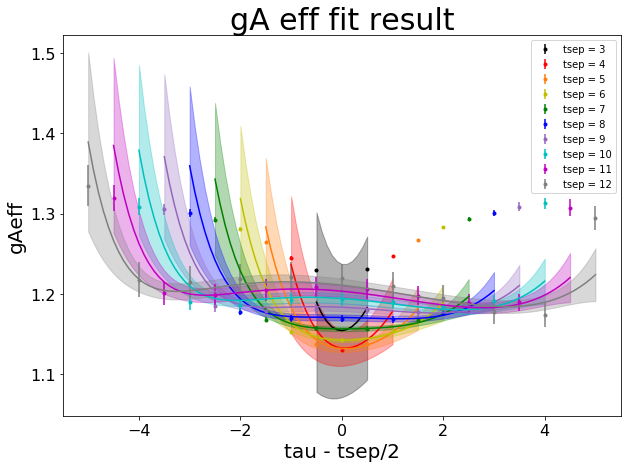

(10,)
(10,)


<Figure size 432x288 with 0 Axes>

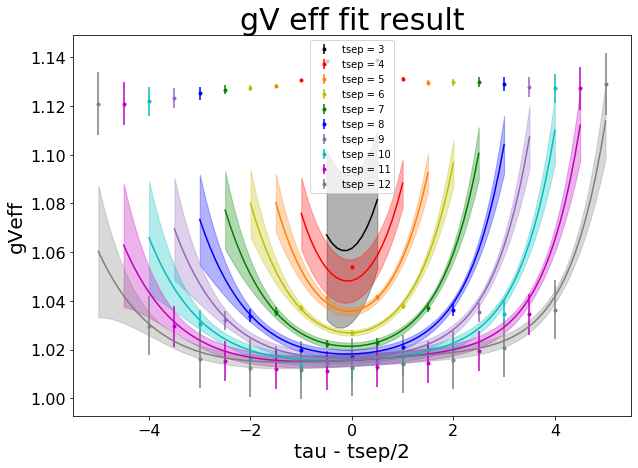

<Figure size 432x288 with 0 Axes>

In [66]:
colors_3pt = np.array(['k', 'r', 'tab:orange', 'y', 'g', 'b', 'tab:purple', 'c', 'm', 'tab:grey'])
print(x_3pt_data)
print(y_3pt_A3)

h5_dm.fit_data_plot("gA eff fit result", "tau - tsep/2", "gAeff", x_3pt_data, y_3pt_A3, t_3pt_tseptau_diff, model_A3_ratio_2d_mean, model_A3_ratio_2d_upbound, model_A3_ratio_2d_lowbound, colors_3pt, 30, 20, 16, 13, nplots = len(gv_avg_data['C_ratio_A3']), ydat_error=y_3pt_A3_err, datalabels = legendlabels_3pt) 
print(np.shape(x_3pt_data))
print(np.shape(model_A3_3pt_2d))

h5_dm.fit_data_plot("gV eff fit result", "tau - tsep/2", "gVeff", x_3pt_data, y_3pt_V4, t_3pt_tseptau_diff, model_V4_ratio_2d_mean, model_V4_ratio_2d_upbound, model_V4_ratio_2d_lowbound, colors_3pt, 30, 20, 16, 13, nplots = len(gv_avg_data['C_ratio_V4']), ydat_error=y_3pt_V4_err, datalabels = legendlabels_3pt) 


 


#### Now, vary the width of the first excited state, the tau-bounds (calculated as distance from 0 of the minimum and from tsep of the maximum

Set the arrays over which to loop over and the priors and 3-point data-sets to use at each iteration

In [67]:
# Create arrays for the parameters that will be varied
b = np.array([0.1, 0.3, 0.5, 0.7, 1.0])
#tsep_mins = np.array([3, 7, 10])
tau_cuts = np.arange(1,4,1)
n_z_vals = np.arange(3,8,1)
n_FH_vals = np.array([2, 3])

n_zFH_combined = np.arange(6, 16, 1) # these n-values are there to encode both num_zs and n_FH
zFH_splitted = 2 #The number such that n_zFH_combined/2 is num_zs and (n_zFH_combined % 2) + 2 is num_states_FH

In [68]:
# set priors for each dE-set, num-z set, and num-FH-set
priors = []
for i in range(3):
    priors.append([])
    for j in range(len(b)):
        priors[i].append([])
        for k in range(len(n_zFH_combined)):
            priors[i][j].append(gv.BufferDict())
            
            num_zs = n_zFH_combined[k]//2
            num_states_FH = n_zFH_combined[k] % 2 + 2
            e_decay_exp = i
            
            priors[i][j][k]['E0'] = gv.gvar(0.67, 0.02)
            priors[i][j][k]['Z0'] = gv.gvar(0.0008, 0.0003)
            priors[i][j][k]['Ztilde0'] = gv.gvar(0.003, 0.003)

            # Define some constants for prioring the higher-order energies
            dE0 = 2*mpi

            # Use constant dE to prior the energies
            energyvals = np.array([None]*num_zs)
            dEvals = np.array([None]*(num_zs - 1))

            #E0_errbar = 0.8
            energyvals[0] = gv.gvar(0.67, 0.02)
            for n in range(1, num_zs):
                dEvals[n-1] = dE0/np.power(n, e_decay_exp)
                energyvals[n] = energyvals[n-1] + dEvals[n-1]
            
            priors[i][j][k]['log(dE1)'] = gv.gvar(np.log(dEvals[0]), b[j])
            priors[i][j][k]['Z1'] = gv.gvar(0.0012, 0.0006)
            priors[i][j][k]['Ztilde1'] = gv.gvar(0, 0.01)
            
            for n in range(2, num_zs):
                priors[i][j][k]['log(dE{})'.format(n)] = gv.gvar(np.log(dEvals[n-1]), 0.7)
                priors[i][j][k]['Z{}'.format(n)] = gv.gvar(0.0012, 0.0006)
                priors[i][j][k]['Ztilde{}'.format(n)] = gv.gvar(0, 0.01)


            for n in range(num_zs):
                for m in range(num_zs):
        
                    priors[i][j][k]['gA3_{0}{1}'.format(n, m)] = gv.gvar(1, 2)
                    if n == m and n < num_zs-1:
                        priors[i][j][k]['gV4_{0}{1}'.format(n, m)] = gv.gvar(1, 0.1)
                    else:
                        priors[i][j][k]['gV4_{0}{1}'.format(n, m)] = gv.gvar(0, 2)

            priors[i][j][k]['gA3_00'] = gv.gvar(1.25, 0.15)
            priors[i][j][k]['gV4_00'] = gv.gvar(1.07, 0.07)

            # Set the "garbage can" for the Feynman Hellman fit
            #priors[i][j][k]['Z_FHmax'] = gv.gvar(0.0008, 0.0004)
            #if num_states_FH == 2:
                #priors[i][j][k]['log(FH_dEmax)'] = gv.gvar(np.log(dEvals[num_states_FH - 2]), b[j])
            #else:
                #priors[i][j][k]['log(FH_dEmax)'] = gv.gvar(np.log(dEvals[num_states_FH - 2]), 0.7)

            #for n in range(num_states_FH-1):
                #priors[i][j][k]['gA3_FHmax{}'.format(n)] = gv.gvar(1, 2)
                #priors[i][j][k]['gA3_{}FHmax'.format(n)] = gv.gvar(1, 2)
                #priors[i][j][k]['gV4_FHmax{}'.format(n)] = gv.gvar(0, 2)
                #priors[i][j][k]['gV4_{}FHmax'.format(n)] = gv.gvar(0, 2)
    
            #priors[i][j][k]['gA3_FHmaxFHmax'] = gv.gvar(1, 2)
            #priors[i][j][k]['gV4_FHmaxFHmax'] = gv.gvar(0, 2)
            
            

In [69]:
list_LogGBF_a0 = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_Q_a0 = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_E0_a0 = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_gA00_a0 = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_gV00_a0 = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))

list_LogGBF_a1 = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_Q_a1 = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_E0_a1 = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_gA00_a1 = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_gV00_a1 = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))

list_LogGBF_a2 = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_Q_a2 = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_E0_a2 = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_gA00_a2 = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_gV00_a2 = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))

In [70]:
# Create 3-point datasets for each tau-cut data set
tau_cut_to_min_tsep = np.array([3, 4, 6])
x_vals_3fit = []
y_vals_3fit = []
x_vals_all = []
y_vals_all = []

y_3pt_A3_2d = np.array([ [gv_avg_data['3pt_A3'][i][j] for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
y_3pt_A3 = convert_2dto1d(t_1d_array, t_2d_array, y_3pt_A3_2d)
y_3pt_V4_2d = np.array([ [gv_avg_data['3pt_V4'][i][j] for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
y_3pt_V4 = convert_2dto1d(t_1d_array, t_2d_array, y_3pt_V4_2d)

y_3pt = np.transpose(np.array([[y_3pt_A3], [y_3pt_V4]]), axes=[2,0,1])

for i in range(len(tau_cuts)):
    x_vals_3fit.append([])
    y_vals_3fit.append([])
    x_vals_all.append([])
    y_vals_all.append([])
    
    for k in range(len(t_1d_array)):
        if(t_1d_array[k][0] >= tau_cut_to_min_tsep[i]):
            if(t_1d_array[k][1] >= tau_cuts[i]):
                if(t_1d_array[k][1] <= t_1d_array[k][0] - tau_cuts[i]):
                    x_vals_3fit[i].append(t_1d_array[k].tolist())
                    y_vals_3fit[i].append(y_3pt[k].tolist())
                            
    x_vals_3fit[i] = np.array(x_vals_3fit[i])
    y_vals_3fit[i] = np.array(y_vals_3fit[i])
    
    x_vals_all[i] = np.append(x_2pt_mod, x_vals_3fit[i], axis = 0)
    y_vals_all[i] = np.append(y_2pt_all, y_vals_3fit[i], axis = 0)

Now that the priors and the data are set, do the fits

In [71]:
for i in range(len(b)):
    for j in range(len(tau_cuts)):
        for k in range(len(n_zFH_combined)):
            num_zs = n_zFH_combined[k]//2
            num_states_FH = n_zFH_combined[k] % 2 + 2
            
            fit_a0 = lsqfit.nonlinear_fit(data=(x_vals_all[j], y_vals_all[j]), prior=priors[0][i][k],fcn=all_at_once,debug=True)
            fit_a1 = lsqfit.nonlinear_fit(data=(x_vals_all[j], y_vals_all[j]), prior=priors[1][i][k],fcn=all_at_once,debug=True)
            fit_a2 = lsqfit.nonlinear_fit(data=(x_vals_all[j], y_vals_all[j]), prior=priors[2][i][k],fcn=all_at_once,debug=True)
            
            print("dE constant, lod(dE1) bound = ", b[i], " tau_cuts = ", tau_cuts[j], " num_zs = ", num_zs, " num_states_FH = ", num_states_FH)
            print(fit_a0.format(pstyle='vv'))    
            list_LogGBF_a0[i][j][k] = fit_a0.logGBF
            list_Q_a0[i][j][k] = fit_a0.Q
            list_E0_a0[i][j][k] = fit_a0.p['E0']
            list_gA00_a0[i][j][k] = fit_a0.p['gA3_00']
            list_gV00_a0[i][j][k] = fit_a0.p['gV4_00']
                
            print("dE proportional to 1/n, log(dE1) bound = ", b[i], " tau_cuts = ", tau_cuts[j], " num_zs = ", num_zs, " num_states_FH = ", num_states_FH)
            print(fit_a1.format(pstyle='vv'))
            list_LogGBF_a1[i][j][k] = fit_a1.logGBF
            list_Q_a1[i][j][k] = fit_a1.Q
            list_E0_a1[i][j][k] = fit_a1.p['E0']
            list_gA00_a1[i][j][k] = fit_a1.p['gA3_00']
            list_gV00_a1[i][j][k] = fit_a1.p['gV4_00']
                
            print("dE proportional to 1/n^2, log(dE1) bound = ", b[i], " tau_cuts = ", tau_cuts[j], " num_zs = ", num_zs, " num_states_FH = ", num_states_FH)
            print(fit_a2.format(pstyle='vv'))
            list_LogGBF_a2[i][j][k] = fit_a2.logGBF
            list_Q_a2[i][j][k] = fit_a2.Q
            list_E0_a2[i][j][k] = fit_a2.p['E0']
            list_gA00_a2[i][j][k] = fit_a2.p['gA3_00']
            list_gV00_a2[i][j][k] = fit_a2.p['gV4_00']
                


dE constant, lod(dE1) bound =  0.1  tau_cuts =  1  num_zs =  3  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 19 [150]    Q = 0    logGBF = 2542.1

Parameters:
             E0       0.67622 +- 0.000975031             [     0.67 +- 0.02 ]  
             Z0   0.000801133 +- 2.34781e-06             [ 0.0008 +- 0.0003 ]  
        Ztilde0     0.00311933 +- 1.1141e-05             [   0.003 +- 0.003 ]  
       log(dE1)     -0.0445542 +- 0.00740954             [  -0.97551 +- 0.1 ]  *****
             Z1    0.00125744 +- 1.06309e-05             [ 0.0012 +- 0.0006 ]  
        Ztilde1      0.010263 +- 0.000109845             [        0 +- 0.01 ]  *
       log(dE2)       0.911682 +- 0.00921682             [  -0.97551 +- 0.7 ]  **
             Z2    0.00619787 +- 0.000485504             [ 0.0012 +- 0.0006 ]  *****
        Ztilde2     -0.0623935 +- 0.00939679             [        0 +- 0.01 ]  *****
         gA3_00        1.08817 +- 0.00178332             [     1.25 +- 0.15 ]  *
         gV

dE constant, lod(dE1) bound =  0.1  tau_cuts =  1  num_zs =  3  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 19 [150]    Q = 0    logGBF = 2542.1

Parameters:
             E0       0.67622 +- 0.000975031             [     0.67 +- 0.02 ]  
             Z0   0.000801133 +- 2.34781e-06             [ 0.0008 +- 0.0003 ]  
        Ztilde0     0.00311933 +- 1.1141e-05             [   0.003 +- 0.003 ]  
       log(dE1)     -0.0445542 +- 0.00740954             [  -0.97551 +- 0.1 ]  *****
             Z1    0.00125744 +- 1.06309e-05             [ 0.0012 +- 0.0006 ]  
        Ztilde1      0.010263 +- 0.000109845             [        0 +- 0.01 ]  *
       log(dE2)       0.911682 +- 0.00921682             [  -0.97551 +- 0.7 ]  **
             Z2    0.00619787 +- 0.000485504             [ 0.0012 +- 0.0006 ]  *****
        Ztilde2     -0.0623935 +- 0.00939679             [        0 +- 0.01 ]  *****
         gA3_00        1.08817 +- 0.00178332             [     1.25 +- 0.15 ]  *
         gV

dE constant, lod(dE1) bound =  0.1  tau_cuts =  1  num_zs =  4  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 1.8 [150]    Q = 1.6e-09    logGBF = 3773

Parameters:
             E0       0.661897 +- 0.00196049             [     0.67 +- 0.02 ]  
             Z0   0.000758148 +- 6.62375e-06             [ 0.0008 +- 0.0003 ]  
        Ztilde0     0.0028574 +- 2.92594e-05             [   0.003 +- 0.003 ]  
       log(dE1)         -0.9181 +- 0.0471038             [  -0.97551 +- 0.1 ]  
             Z1   0.000571873 +- 2.58738e-05             [ 0.0012 +- 0.0006 ]  *
        Ztilde1    0.00398292 +- 0.000151942             [        0 +- 0.01 ]  
       log(dE2)       -0.381684 +- 0.0400107             [  -0.97551 +- 0.7 ]  
             Z2    0.00116489 +- 2.89413e-05             [ 0.0012 +- 0.0006 ]  
        Ztilde2    0.00834512 +- 0.000256186             [        0 +- 0.01 ]  
       log(dE3)         1.41901 +- 0.0676219             [  -0.97551 +- 0.7 ]  ***
             Z3    0.

dE constant, lod(dE1) bound =  0.1  tau_cuts =  1  num_zs =  4  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 1.8 [150]    Q = 1.6e-09    logGBF = 3773

Parameters:
             E0       0.661897 +- 0.00196049             [     0.67 +- 0.02 ]  
             Z0   0.000758148 +- 6.62375e-06             [ 0.0008 +- 0.0003 ]  
        Ztilde0     0.0028574 +- 2.92594e-05             [   0.003 +- 0.003 ]  
       log(dE1)         -0.9181 +- 0.0471038             [  -0.97551 +- 0.1 ]  
             Z1   0.000571873 +- 2.58738e-05             [ 0.0012 +- 0.0006 ]  *
        Ztilde1    0.00398292 +- 0.000151942             [        0 +- 0.01 ]  
       log(dE2)       -0.381684 +- 0.0400107             [  -0.97551 +- 0.7 ]  
             Z2    0.00116489 +- 2.89413e-05             [ 0.0012 +- 0.0006 ]  
        Ztilde2    0.00834512 +- 0.000256186             [        0 +- 0.01 ]  
       log(dE3)         1.41901 +- 0.0676219             [  -0.97551 +- 0.7 ]  ***
             Z3    0.

dE constant, lod(dE1) bound =  0.1  tau_cuts =  1  num_zs =  5  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 1.1 [150]    Q = 0.22    logGBF = 3789.7

Parameters:
             E0       0.657897 +- 0.00221538             [     0.67 +- 0.02 ]  
             Z0   0.000743804 +- 7.79773e-06             [ 0.0008 +- 0.0003 ]  
        Ztilde0     0.00280217 +- 3.4425e-05             [   0.003 +- 0.003 ]  
       log(dE1)       -0.842738 +- 0.0536748             [  -0.97551 +- 0.1 ]  *
             Z1   0.000712767 +- 2.77096e-05             [ 0.0012 +- 0.0006 ]  
        Ztilde1     0.0045388 +- 0.000227325             [        0 +- 0.01 ]  
       log(dE2)       0.0566056 +- 0.0899256             [  -0.97551 +- 0.7 ]  *
             Z2     0.00138043 +- 0.00012896             [ 0.0012 +- 0.0006 ]  
        Ztilde2       0.016007 +- 0.00434002             [        0 +- 0.01 ]  *
       log(dE3)        -0.202553 +- 0.396596             [  -0.97551 +- 0.7 ]  *
             Z3    0.0

dE constant, lod(dE1) bound =  0.1  tau_cuts =  1  num_zs =  5  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 1.1 [150]    Q = 0.22    logGBF = 3789.7

Parameters:
             E0       0.657897 +- 0.00221538             [     0.67 +- 0.02 ]  
             Z0   0.000743804 +- 7.79773e-06             [ 0.0008 +- 0.0003 ]  
        Ztilde0     0.00280217 +- 3.4425e-05             [   0.003 +- 0.003 ]  
       log(dE1)       -0.842738 +- 0.0536748             [  -0.97551 +- 0.1 ]  *
             Z1   0.000712767 +- 2.77096e-05             [ 0.0012 +- 0.0006 ]  
        Ztilde1     0.0045388 +- 0.000227325             [        0 +- 0.01 ]  
       log(dE2)       0.0566056 +- 0.0899256             [  -0.97551 +- 0.7 ]  *
             Z2     0.00138043 +- 0.00012896             [ 0.0012 +- 0.0006 ]  
        Ztilde2       0.016007 +- 0.00434002             [        0 +- 0.01 ]  *
       log(dE3)        -0.202553 +- 0.396596             [  -0.97551 +- 0.7 ]  *
             Z3    0.0

dE constant, lod(dE1) bound =  0.1  tau_cuts =  1  num_zs =  6  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.87 [150]    Q = 0.87    logGBF = 3792.7

Parameters:
             E0        0.659939 +- 0.00292581             [     0.67 +- 0.02 ]  
             Z0    0.000749801 +- 1.12546e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0     0.00282825 +- 4.69919e-05             [   0.003 +- 0.003 ]  
       log(dE1)        -0.977599 +- 0.0900184             [  -0.97551 +- 0.1 ]  
             Z1    0.000580693 +- 5.54519e-05             [ 0.0012 +- 0.0006 ]  *
        Ztilde1     0.00354804 +- 0.000410751             [        0 +- 0.01 ]  
       log(dE2)         -0.900703 +- 0.386093             [  -0.97551 +- 0.7 ]  
             Z2   -0.000294316 +- 0.000265098             [ 0.0012 +- 0.0006 ]  **
        Ztilde2     -0.00576537 +- 0.00379204             [        0 +- 0.01 ]  
       log(dE3)         -0.954757 +- 0.454061             [  -0.97551 +- 0.7 ]  
            

dE constant, lod(dE1) bound =  0.1  tau_cuts =  1  num_zs =  6  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.87 [150]    Q = 0.87    logGBF = 3792.7

Parameters:
             E0        0.659939 +- 0.00292581             [     0.67 +- 0.02 ]  
             Z0    0.000749801 +- 1.12546e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0     0.00282825 +- 4.69919e-05             [   0.003 +- 0.003 ]  
       log(dE1)        -0.977599 +- 0.0900184             [  -0.97551 +- 0.1 ]  
             Z1    0.000580693 +- 5.54519e-05             [ 0.0012 +- 0.0006 ]  *
        Ztilde1     0.00354804 +- 0.000410751             [        0 +- 0.01 ]  
       log(dE2)         -0.900703 +- 0.386093             [  -0.97551 +- 0.7 ]  
             Z2   -0.000294316 +- 0.000265098             [ 0.0012 +- 0.0006 ]  **
        Ztilde2     -0.00576537 +- 0.00379204             [        0 +- 0.01 ]  
       log(dE3)         -0.954757 +- 0.454061             [  -0.97551 +- 0.7 ]  
            

dE constant, lod(dE1) bound =  0.1  tau_cuts =  1  num_zs =  7  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.76 [150]    Q = 0.99    logGBF = 3772.1

Parameters:
             E0       0.661482 +- 0.00332956             [     0.67 +- 0.02 ]  
             Z0     0.000756747 +- 1.348e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00284868 +- 5.51059e-05             [   0.003 +- 0.003 ]  
       log(dE1)        -1.03553 +- 0.0949263             [  -0.97551 +- 0.1 ]  
             Z1   0.000438582 +- 0.000154128             [ 0.0012 +- 0.0006 ]  *
        Ztilde1    0.00346283 +- 0.000760339             [        0 +- 0.01 ]  
       log(dE2)         -1.40741 +- 0.498834             [  -0.97551 +- 0.7 ]  
             Z2   0.000552114 +- 0.000229466             [ 0.0012 +- 0.0006 ]  *
        Ztilde2     0.00195459 +- 0.00264147             [        0 +- 0.01 ]  
       log(dE3)        -0.825138 +- 0.428515             [  -0.97551 +- 0.7 ]  
             Z3   0.000

dE constant, lod(dE1) bound =  0.1  tau_cuts =  1  num_zs =  7  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.76 [150]    Q = 0.99    logGBF = 3772.1

Parameters:
             E0       0.661482 +- 0.00332956             [     0.67 +- 0.02 ]  
             Z0     0.000756747 +- 1.348e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00284868 +- 5.51059e-05             [   0.003 +- 0.003 ]  
       log(dE1)        -1.03553 +- 0.0949263             [  -0.97551 +- 0.1 ]  
             Z1   0.000438582 +- 0.000154128             [ 0.0012 +- 0.0006 ]  *
        Ztilde1    0.00346283 +- 0.000760339             [        0 +- 0.01 ]  
       log(dE2)         -1.40741 +- 0.498834             [  -0.97551 +- 0.7 ]  
             Z2   0.000552114 +- 0.000229466             [ 0.0012 +- 0.0006 ]  *
        Ztilde2     0.00195459 +- 0.00264147             [        0 +- 0.01 ]  
       log(dE3)        -0.825138 +- 0.428515             [  -0.97551 +- 0.7 ]  
             Z3   0.000

dE constant, lod(dE1) bound =  0.1  tau_cuts =  2  num_zs =  3  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 1.5 [110]    Q = 0.00044    logGBF = 2787.8

Parameters:
             E0       0.661313 +- 0.00205704             [     0.67 +- 0.02 ]  
             Z0   0.000756164 +- 7.08947e-06             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00284885 +- 3.17443e-05             [   0.003 +- 0.003 ]  
       log(dE1)       -0.909784 +- 0.0515158             [  -0.97551 +- 0.1 ]  
             Z1   0.000595849 +- 2.37172e-05             [ 0.0012 +- 0.0006 ]  *
        Ztilde1    0.00409555 +- 0.000163651             [        0 +- 0.01 ]  
       log(dE2)       -0.318356 +- 0.0344163             [  -0.97551 +- 0.7 ]  
             Z2    0.00119904 +- 3.06921e-05             [ 0.0012 +- 0.0006 ]  
        Ztilde2    0.00863114 +- 0.000277289             [        0 +- 0.01 ]  
         gA3_00         1.25214 +- 0.0113432             [     1.25 +- 0.15 ]  
         gV4_00       

dE constant, lod(dE1) bound =  0.1  tau_cuts =  2  num_zs =  3  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 1.5 [110]    Q = 0.00044    logGBF = 2787.8

Parameters:
             E0       0.661313 +- 0.00205704             [     0.67 +- 0.02 ]  
             Z0   0.000756164 +- 7.08947e-06             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00284885 +- 3.17443e-05             [   0.003 +- 0.003 ]  
       log(dE1)       -0.909784 +- 0.0515158             [  -0.97551 +- 0.1 ]  
             Z1   0.000595849 +- 2.37172e-05             [ 0.0012 +- 0.0006 ]  *
        Ztilde1    0.00409555 +- 0.000163651             [        0 +- 0.01 ]  
       log(dE2)       -0.318356 +- 0.0344163             [  -0.97551 +- 0.7 ]  
             Z2    0.00119904 +- 3.06921e-05             [ 0.0012 +- 0.0006 ]  
        Ztilde2    0.00863114 +- 0.000277289             [        0 +- 0.01 ]  
         gA3_00         1.25214 +- 0.0113432             [     1.25 +- 0.15 ]  
         gV4_00       

dE constant, lod(dE1) bound =  0.1  tau_cuts =  2  num_zs =  4  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.96 [110]    Q = 0.6    logGBF = 2795.7

Parameters:
             E0        0.663096 +- 0.0031394             [     0.67 +- 0.02 ]  
             Z0   0.000763392 +- 1.27266e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00287616 +- 5.15238e-05             [   0.003 +- 0.003 ]  
       log(dE1)         -1.10563 +- 0.091022             [  -0.97551 +- 0.1 ]  *
             Z1   0.000380001 +- 0.000113658             [ 0.0012 +- 0.0006 ]  *
        Ztilde1     0.0028841 +- 0.000598564             [        0 +- 0.01 ]  
       log(dE2)         -1.52845 +- 0.449098             [  -0.97551 +- 0.7 ]  
             Z2   0.000374585 +- 0.000187949             [ 0.0012 +- 0.0006 ]  *
        Ztilde2     0.00241777 +- 0.00140752             [        0 +- 0.01 ]  
       log(dE3)        -0.898645 +- 0.319825             [  -0.97551 +- 0.7 ]  
             Z3    0.00

dE constant, lod(dE1) bound =  0.1  tau_cuts =  2  num_zs =  4  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.96 [110]    Q = 0.6    logGBF = 2795.7

Parameters:
             E0        0.663096 +- 0.0031394             [     0.67 +- 0.02 ]  
             Z0   0.000763392 +- 1.27266e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00287616 +- 5.15238e-05             [   0.003 +- 0.003 ]  
       log(dE1)         -1.10563 +- 0.091022             [  -0.97551 +- 0.1 ]  *
             Z1   0.000380001 +- 0.000113658             [ 0.0012 +- 0.0006 ]  *
        Ztilde1     0.0028841 +- 0.000598564             [        0 +- 0.01 ]  
       log(dE2)         -1.52845 +- 0.449098             [  -0.97551 +- 0.7 ]  
             Z2   0.000374585 +- 0.000187949             [ 0.0012 +- 0.0006 ]  *
        Ztilde2     0.00241777 +- 0.00140752             [        0 +- 0.01 ]  
       log(dE3)        -0.898645 +- 0.319825             [  -0.97551 +- 0.7 ]  
             Z3    0.00

dE constant, lod(dE1) bound =  0.1  tau_cuts =  2  num_zs =  5  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.74 [110]    Q = 0.98    logGBF = 2785.8

Parameters:
             E0       0.660117 +- 0.00341382             [     0.67 +- 0.02 ]  
             Z0    0.000751354 +- 1.3601e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00283163 +- 5.61491e-05             [   0.003 +- 0.003 ]  
       log(dE1)        -1.00895 +- 0.0928542             [  -0.97551 +- 0.1 ]  
             Z1   0.000522794 +- 0.000108221             [ 0.0012 +- 0.0006 ]  *
        Ztilde1    0.00340052 +- 0.000545269             [        0 +- 0.01 ]  
       log(dE2)         -1.08236 +- 0.471204             [  -0.97551 +- 0.7 ]  
             Z2   0.000562282 +- 0.000242735             [ 0.0012 +- 0.0006 ]  *
        Ztilde2     0.00366594 +- 0.00234342             [        0 +- 0.01 ]  
       log(dE3)        -0.682699 +- 0.452673             [  -0.97551 +- 0.7 ]  
             Z3   0.000

dE constant, lod(dE1) bound =  0.1  tau_cuts =  2  num_zs =  5  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.74 [110]    Q = 0.98    logGBF = 2785.8

Parameters:
             E0       0.660117 +- 0.00341382             [     0.67 +- 0.02 ]  
             Z0    0.000751354 +- 1.3601e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00283163 +- 5.61491e-05             [   0.003 +- 0.003 ]  
       log(dE1)        -1.00895 +- 0.0928542             [  -0.97551 +- 0.1 ]  
             Z1   0.000522794 +- 0.000108221             [ 0.0012 +- 0.0006 ]  *
        Ztilde1    0.00340052 +- 0.000545269             [        0 +- 0.01 ]  
       log(dE2)         -1.08236 +- 0.471204             [  -0.97551 +- 0.7 ]  
             Z2   0.000562282 +- 0.000242735             [ 0.0012 +- 0.0006 ]  *
        Ztilde2     0.00366594 +- 0.00234342             [        0 +- 0.01 ]  
       log(dE3)        -0.682699 +- 0.452673             [  -0.97551 +- 0.7 ]  
             Z3   0.000

dE constant, lod(dE1) bound =  0.1  tau_cuts =  2  num_zs =  6  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.75 [110]    Q = 0.98    logGBF = 2780.9

Parameters:
             E0       0.659963 +- 0.00347856             [     0.67 +- 0.02 ]  
             Z0   0.000750935 +- 1.40073e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0     0.00282523 +- 5.7385e-05             [   0.003 +- 0.003 ]  
       log(dE1)         -1.01992 +- 0.093849             [  -0.97551 +- 0.1 ]  
             Z1   0.000503117 +- 0.000130528             [ 0.0012 +- 0.0006 ]  *
        Ztilde1    0.00363002 +- 0.000748019             [        0 +- 0.01 ]  
       log(dE2)         -1.39275 +- 0.570619             [  -0.97551 +- 0.7 ]  
             Z2   0.000469099 +- 0.000280728             [ 0.0012 +- 0.0006 ]  *
        Ztilde2     0.00104593 +- 0.00386355             [        0 +- 0.01 ]  
       log(dE3)        -0.908356 +- 0.504173             [  -0.97551 +- 0.7 ]  
             Z3   0.000

dE constant, lod(dE1) bound =  0.1  tau_cuts =  2  num_zs =  6  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.75 [110]    Q = 0.98    logGBF = 2780.9

Parameters:
             E0       0.659963 +- 0.00347856             [     0.67 +- 0.02 ]  
             Z0   0.000750935 +- 1.40073e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0     0.00282523 +- 5.7385e-05             [   0.003 +- 0.003 ]  
       log(dE1)         -1.01992 +- 0.093849             [  -0.97551 +- 0.1 ]  
             Z1   0.000503117 +- 0.000130528             [ 0.0012 +- 0.0006 ]  *
        Ztilde1    0.00363002 +- 0.000748019             [        0 +- 0.01 ]  
       log(dE2)         -1.39275 +- 0.570619             [  -0.97551 +- 0.7 ]  
             Z2   0.000469099 +- 0.000280728             [ 0.0012 +- 0.0006 ]  *
        Ztilde2     0.00104593 +- 0.00386355             [        0 +- 0.01 ]  
       log(dE3)        -0.908356 +- 0.504173             [  -0.97551 +- 0.7 ]  
             Z3   0.000

dE constant, lod(dE1) bound =  0.1  tau_cuts =  2  num_zs =  7  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.76 [110]    Q = 0.97    logGBF = 2779.9

Parameters:
             E0       0.660025 +- 0.00346481             [     0.67 +- 0.02 ]  
             Z0   0.000751214 +- 1.39274e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00282691 +- 5.70472e-05             [   0.003 +- 0.003 ]  
       log(dE1)        -1.01727 +- 0.0939174             [  -0.97551 +- 0.1 ]  
             Z1   0.000502651 +- 0.000130256             [ 0.0012 +- 0.0006 ]  *
        Ztilde1    0.00358931 +- 0.000710892             [        0 +- 0.01 ]  
       log(dE2)         -1.35956 +- 0.563192             [  -0.97551 +- 0.7 ]  
             Z2   0.000488693 +- 0.000268362             [ 0.0012 +- 0.0006 ]  *
        Ztilde2     0.00150334 +- 0.00343335             [        0 +- 0.01 ]  
       log(dE3)        -0.841246 +- 0.480051             [  -0.97551 +- 0.7 ]  
             Z3   0.000

dE constant, lod(dE1) bound =  0.1  tau_cuts =  2  num_zs =  7  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.76 [110]    Q = 0.97    logGBF = 2779.9

Parameters:
             E0       0.660025 +- 0.00346481             [     0.67 +- 0.02 ]  
             Z0   0.000751214 +- 1.39274e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00282691 +- 5.70472e-05             [   0.003 +- 0.003 ]  
       log(dE1)        -1.01727 +- 0.0939174             [  -0.97551 +- 0.1 ]  
             Z1   0.000502651 +- 0.000130256             [ 0.0012 +- 0.0006 ]  *
        Ztilde1    0.00358931 +- 0.000710892             [        0 +- 0.01 ]  
       log(dE2)         -1.35956 +- 0.563192             [  -0.97551 +- 0.7 ]  
             Z2   0.000488693 +- 0.000268362             [ 0.0012 +- 0.0006 ]  *
        Ztilde2     0.00150334 +- 0.00343335             [        0 +- 0.01 ]  
       log(dE3)        -0.841246 +- 0.480051             [  -0.97551 +- 0.7 ]  
             Z3   0.000

dE constant, lod(dE1) bound =  0.1  tau_cuts =  3  num_zs =  3  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 1.1 [76]    Q = 0.24    logGBF = 1908.6

Parameters:
             E0       0.659703 +- 0.00224706             [     0.67 +- 0.02 ]  
             Z0   0.000750763 +- 7.68646e-06             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00282979 +- 3.44712e-05             [   0.003 +- 0.003 ]  
       log(dE1)       -0.843694 +- 0.0574386             [  -0.97551 +- 0.1 ]  *
             Z1   0.000672669 +- 3.39619e-05             [ 0.0012 +- 0.0006 ]  
        Ztilde1    0.00449416 +- 0.000244097             [        0 +- 0.01 ]  
       log(dE2)       -0.162376 +- 0.0820344             [  -0.97551 +- 0.7 ]  *
             Z2    0.00127696 +- 7.25932e-05             [ 0.0012 +- 0.0006 ]  
        Ztilde2    0.00951379 +- 0.000670231             [        0 +- 0.01 ]  
         gA3_00         1.22272 +- 0.0137241             [     1.25 +- 0.15 ]  
         gV4_00        1.

dE constant, lod(dE1) bound =  0.1  tau_cuts =  3  num_zs =  3  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 1.1 [76]    Q = 0.24    logGBF = 1908.6

Parameters:
             E0       0.659703 +- 0.00224706             [     0.67 +- 0.02 ]  
             Z0   0.000750763 +- 7.68646e-06             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00282979 +- 3.44712e-05             [   0.003 +- 0.003 ]  
       log(dE1)       -0.843694 +- 0.0574386             [  -0.97551 +- 0.1 ]  *
             Z1   0.000672669 +- 3.39619e-05             [ 0.0012 +- 0.0006 ]  
        Ztilde1    0.00449416 +- 0.000244097             [        0 +- 0.01 ]  
       log(dE2)       -0.162376 +- 0.0820344             [  -0.97551 +- 0.7 ]  *
             Z2    0.00127696 +- 7.25932e-05             [ 0.0012 +- 0.0006 ]  
        Ztilde2    0.00951379 +- 0.000670231             [        0 +- 0.01 ]  
         gA3_00         1.22272 +- 0.0137241             [     1.25 +- 0.15 ]  
         gV4_00        1.

dE constant, lod(dE1) bound =  0.1  tau_cuts =  3  num_zs =  4  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.7 [76]    Q = 0.98    logGBF = 1909.9

Parameters:
             E0        0.65884 +- 0.00325286             [     0.67 +- 0.02 ]  
             Z0   0.000745876 +- 1.26126e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00281112 +- 5.30387e-05             [   0.003 +- 0.003 ]  
       log(dE1)        -1.00536 +- 0.0908222             [  -0.97551 +- 0.1 ]  
             Z1    0.000579583 +- 6.7253e-05             [ 0.0012 +- 0.0006 ]  *
        Ztilde1    0.00353523 +- 0.000390442             [        0 +- 0.01 ]  
       log(dE2)        -0.559743 +- 0.279353             [  -0.97551 +- 0.7 ]  
             Z2    0.00079486 +- 0.000271107             [ 0.0012 +- 0.0006 ]  
        Ztilde2      0.0076298 +- 0.00249036             [        0 +- 0.01 ]  
       log(dE3)         -0.61852 +- 0.548931             [  -0.97551 +- 0.7 ]  
             Z3    0.00113

dE constant, lod(dE1) bound =  0.1  tau_cuts =  3  num_zs =  4  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.7 [76]    Q = 0.98    logGBF = 1909.9

Parameters:
             E0        0.65884 +- 0.00325286             [     0.67 +- 0.02 ]  
             Z0   0.000745876 +- 1.26126e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00281112 +- 5.30387e-05             [   0.003 +- 0.003 ]  
       log(dE1)        -1.00536 +- 0.0908222             [  -0.97551 +- 0.1 ]  
             Z1    0.000579583 +- 6.7253e-05             [ 0.0012 +- 0.0006 ]  *
        Ztilde1    0.00353523 +- 0.000390442             [        0 +- 0.01 ]  
       log(dE2)        -0.559743 +- 0.279353             [  -0.97551 +- 0.7 ]  
             Z2    0.00079486 +- 0.000271107             [ 0.0012 +- 0.0006 ]  
        Ztilde2      0.0076298 +- 0.00249036             [        0 +- 0.01 ]  
       log(dE3)         -0.61852 +- 0.548931             [  -0.97551 +- 0.7 ]  
             Z3    0.00113

dE constant, lod(dE1) bound =  0.1  tau_cuts =  3  num_zs =  5  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.7 [76]    Q = 0.98    logGBF = 1903

Parameters:
             E0       0.659082 +- 0.00357955             [     0.67 +- 0.02 ]  
             Z0   0.000747554 +- 1.44422e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00281402 +- 5.93077e-05             [   0.003 +- 0.003 ]  
       log(dE1)        -1.03919 +- 0.0948958             [  -0.97551 +- 0.1 ]  
             Z1     0.0005168 +- 0.000116796             [ 0.0012 +- 0.0006 ]  *
        Ztilde1    0.00340514 +- 0.000611197             [        0 +- 0.01 ]  
       log(dE2)          -1.2474 +- 0.556667             [  -0.97551 +- 0.7 ]  
             Z2   0.000499888 +- 0.000288615             [ 0.0012 +- 0.0006 ]  *
        Ztilde2     0.00228693 +- 0.00328203             [        0 +- 0.01 ]  
       log(dE3)        -0.843508 +- 0.496951             [  -0.97551 +- 0.7 ]  
             Z3   0.0007770

dE constant, lod(dE1) bound =  0.1  tau_cuts =  3  num_zs =  5  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.7 [76]    Q = 0.98    logGBF = 1903

Parameters:
             E0       0.659082 +- 0.00357955             [     0.67 +- 0.02 ]  
             Z0   0.000747554 +- 1.44422e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00281402 +- 5.93077e-05             [   0.003 +- 0.003 ]  
       log(dE1)        -1.03919 +- 0.0948958             [  -0.97551 +- 0.1 ]  
             Z1     0.0005168 +- 0.000116796             [ 0.0012 +- 0.0006 ]  *
        Ztilde1    0.00340514 +- 0.000611197             [        0 +- 0.01 ]  
       log(dE2)          -1.2474 +- 0.556667             [  -0.97551 +- 0.7 ]  
             Z2   0.000499888 +- 0.000288615             [ 0.0012 +- 0.0006 ]  *
        Ztilde2     0.00228693 +- 0.00328203             [        0 +- 0.01 ]  
       log(dE3)        -0.843508 +- 0.496951             [  -0.97551 +- 0.7 ]  
             Z3   0.0007770

dE constant, lod(dE1) bound =  0.1  tau_cuts =  3  num_zs =  6  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.71 [76]    Q = 0.97    logGBF = 1902.8

Parameters:
             E0       0.658907 +- 0.00357404             [     0.67 +- 0.02 ]  
             Z0   0.000746905 +- 1.43824e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00281107 +- 5.90922e-05             [   0.003 +- 0.003 ]  
       log(dE1)        -1.03608 +- 0.0946394             [  -0.97551 +- 0.1 ]  
             Z1   0.000521691 +- 0.000114962             [ 0.0012 +- 0.0006 ]  *
        Ztilde1    0.00344724 +- 0.000606633             [        0 +- 0.01 ]  
       log(dE2)         -1.23412 +- 0.550729             [  -0.97551 +- 0.7 ]  
             Z2   0.000504156 +- 0.000289288             [ 0.0012 +- 0.0006 ]  *
        Ztilde2     0.00216713 +- 0.00337375             [        0 +- 0.01 ]  
       log(dE3)        -0.860858 +- 0.508531             [  -0.97551 +- 0.7 ]  
             Z3   0.0007

dE constant, lod(dE1) bound =  0.1  tau_cuts =  3  num_zs =  6  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.71 [76]    Q = 0.97    logGBF = 1902.8

Parameters:
             E0       0.658907 +- 0.00357404             [     0.67 +- 0.02 ]  
             Z0   0.000746905 +- 1.43824e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00281107 +- 5.90922e-05             [   0.003 +- 0.003 ]  
       log(dE1)        -1.03608 +- 0.0946394             [  -0.97551 +- 0.1 ]  
             Z1   0.000521691 +- 0.000114962             [ 0.0012 +- 0.0006 ]  *
        Ztilde1    0.00344724 +- 0.000606633             [        0 +- 0.01 ]  
       log(dE2)         -1.23412 +- 0.550729             [  -0.97551 +- 0.7 ]  
             Z2   0.000504156 +- 0.000289288             [ 0.0012 +- 0.0006 ]  *
        Ztilde2     0.00216713 +- 0.00337375             [        0 +- 0.01 ]  
       log(dE3)        -0.860858 +- 0.508531             [  -0.97551 +- 0.7 ]  
             Z3   0.0007

dE constant, lod(dE1) bound =  0.1  tau_cuts =  3  num_zs =  7  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.72 [76]    Q = 0.97    logGBF = 1902.8

Parameters:
             E0       0.658894 +- 0.00356696             [     0.67 +- 0.02 ]  
             Z0   0.000746878 +- 1.43338e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00281094 +- 5.88978e-05             [   0.003 +- 0.003 ]  
       log(dE1)        -1.03404 +- 0.0945824             [  -0.97551 +- 0.1 ]  
             Z1    0.000522847 +- 0.00011444             [ 0.0012 +- 0.0006 ]  *
        Ztilde1    0.00345867 +- 0.000601906             [        0 +- 0.01 ]  
       log(dE2)         -1.22092 +- 0.547563             [  -0.97551 +- 0.7 ]  
             Z2   0.000510816 +- 0.000289575             [ 0.0012 +- 0.0006 ]  *
        Ztilde2     0.00219882 +- 0.00336793             [        0 +- 0.01 ]  
       log(dE3)        -0.861297 +- 0.512489             [  -0.97551 +- 0.7 ]  
             Z3   0.0007

dE constant, lod(dE1) bound =  0.1  tau_cuts =  3  num_zs =  7  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.72 [76]    Q = 0.97    logGBF = 1902.8

Parameters:
             E0       0.658894 +- 0.00356696             [     0.67 +- 0.02 ]  
             Z0   0.000746878 +- 1.43338e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00281094 +- 5.88978e-05             [   0.003 +- 0.003 ]  
       log(dE1)        -1.03404 +- 0.0945824             [  -0.97551 +- 0.1 ]  
             Z1    0.000522847 +- 0.00011444             [ 0.0012 +- 0.0006 ]  *
        Ztilde1    0.00345867 +- 0.000601906             [        0 +- 0.01 ]  
       log(dE2)         -1.22092 +- 0.547563             [  -0.97551 +- 0.7 ]  
             Z2   0.000510816 +- 0.000289575             [ 0.0012 +- 0.0006 ]  *
        Ztilde2     0.00219882 +- 0.00336793             [        0 +- 0.01 ]  
       log(dE3)        -0.861297 +- 0.512489             [  -0.97551 +- 0.7 ]  
             Z3   0.0007

dE constant, lod(dE1) bound =  0.3  tau_cuts =  1  num_zs =  3  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 18 [150]    Q = 0    logGBF = 2579.9

Parameters:
             E0      0.676276 +- 0.000973363             [     0.67 +- 0.02 ]  
             Z0   0.000801358 +- 2.34187e-06             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00312085 +- 1.11194e-05             [   0.003 +- 0.003 ]  
       log(dE1)     -0.0403666 +- 0.00738742             [  -0.97551 +- 0.3 ]  ***
             Z1    0.00126203 +- 1.06797e-05             [ 0.0012 +- 0.0006 ]  
        Ztilde1     0.0102908 +- 0.000108951             [        0 +- 0.01 ]  *
       log(dE2)       0.916562 +- 0.00944861             [  -0.97551 +- 0.7 ]  **
             Z2    0.00625195 +- 0.000486167             [ 0.0012 +- 0.0006 ]  *****
        Ztilde2     -0.0619005 +- 0.00942677             [        0 +- 0.01 ]  *****
         gA3_00        1.08796 +- 0.00177885             [     1.25 +- 0.15 ]  *
         gV4_

dE constant, lod(dE1) bound =  0.3  tau_cuts =  1  num_zs =  3  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 18 [150]    Q = 0    logGBF = 2579.9

Parameters:
             E0      0.676276 +- 0.000973363             [     0.67 +- 0.02 ]  
             Z0   0.000801358 +- 2.34187e-06             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00312085 +- 1.11194e-05             [   0.003 +- 0.003 ]  
       log(dE1)     -0.0403666 +- 0.00738742             [  -0.97551 +- 0.3 ]  ***
             Z1    0.00126203 +- 1.06797e-05             [ 0.0012 +- 0.0006 ]  
        Ztilde1     0.0102908 +- 0.000108951             [        0 +- 0.01 ]  *
       log(dE2)       0.916562 +- 0.00944861             [  -0.97551 +- 0.7 ]  **
             Z2    0.00625195 +- 0.000486167             [ 0.0012 +- 0.0006 ]  *****
        Ztilde2     -0.0619005 +- 0.00942677             [        0 +- 0.01 ]  *****
         gA3_00        1.08796 +- 0.00177885             [     1.25 +- 0.15 ]  *
         gV4_

dE constant, lod(dE1) bound =  0.3  tau_cuts =  1  num_zs =  4  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 1.8 [150]    Q = 1.7e-09    logGBF = 3772.4

Parameters:
             E0       0.662047 +- 0.00195436             [     0.67 +- 0.02 ]  
             Z0   0.000758974 +- 6.64318e-06             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00286195 +- 2.96573e-05             [   0.003 +- 0.003 ]  
       log(dE1)       -0.903642 +- 0.0523801             [  -0.97551 +- 0.3 ]  
             Z1   0.000574884 +- 2.67458e-05             [ 0.0012 +- 0.0006 ]  *
        Ztilde1    0.00402442 +- 0.000170724             [        0 +- 0.01 ]  
       log(dE2)       -0.391988 +- 0.0438265             [  -0.97551 +- 0.7 ]  
             Z2    0.00115976 +- 3.05192e-05             [ 0.0012 +- 0.0006 ]  
        Ztilde2     0.0082821 +- 0.000278585             [        0 +- 0.01 ]  
       log(dE3)          1.41958 +- 0.067733             [  -0.97551 +- 0.7 ]  ***
             Z3    

dE constant, lod(dE1) bound =  0.3  tau_cuts =  1  num_zs =  4  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 1.8 [150]    Q = 1.7e-09    logGBF = 3772.4

Parameters:
             E0       0.662047 +- 0.00195436             [     0.67 +- 0.02 ]  
             Z0   0.000758974 +- 6.64318e-06             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00286195 +- 2.96573e-05             [   0.003 +- 0.003 ]  
       log(dE1)       -0.903642 +- 0.0523801             [  -0.97551 +- 0.3 ]  
             Z1   0.000574884 +- 2.67458e-05             [ 0.0012 +- 0.0006 ]  *
        Ztilde1    0.00402442 +- 0.000170724             [        0 +- 0.01 ]  
       log(dE2)       -0.391988 +- 0.0438265             [  -0.97551 +- 0.7 ]  
             Z2    0.00115976 +- 3.05192e-05             [ 0.0012 +- 0.0006 ]  
        Ztilde2     0.0082821 +- 0.000278585             [        0 +- 0.01 ]  
       log(dE3)          1.41958 +- 0.067733             [  -0.97551 +- 0.7 ]  ***
             Z3    

dE constant, lod(dE1) bound =  0.3  tau_cuts =  1  num_zs =  5  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 1.1 [150]    Q = 0.1    logGBF = 3796.9

Parameters:
             E0         0.660187 +- 0.0019273             [     0.67 +- 0.02 ]  
             Z0    0.000753931 +- 6.34313e-06             [ 0.0008 +- 0.0003 ]  
        Ztilde0     0.00284672 +- 2.87645e-05             [   0.003 +- 0.003 ]  
       log(dE1)         -0.752586 +- 0.047835             [  -0.97551 +- 0.3 ]  
             Z1    0.000730906 +- 3.08325e-05             [ 0.0012 +- 0.0006 ]  
        Ztilde1     0.00497613 +- 0.000229163             [        0 +- 0.01 ]  
       log(dE2)        0.0271512 +- 0.0991714             [  -0.97551 +- 0.7 ]  *
             Z2     0.00148633 +- 0.000126371             [ 0.0012 +- 0.0006 ]  
        Ztilde2        0.0116515 +- 0.0018607             [        0 +- 0.01 ]  *
       log(dE3)         -0.210456 +- 0.504464             [  -0.97551 +- 0.7 ]  *
             Z

dE constant, lod(dE1) bound =  0.3  tau_cuts =  1  num_zs =  5  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 1.1 [150]    Q = 0.1    logGBF = 3796.9

Parameters:
             E0         0.660187 +- 0.0019273             [     0.67 +- 0.02 ]  
             Z0    0.000753931 +- 6.34313e-06             [ 0.0008 +- 0.0003 ]  
        Ztilde0     0.00284672 +- 2.87645e-05             [   0.003 +- 0.003 ]  
       log(dE1)         -0.752586 +- 0.047835             [  -0.97551 +- 0.3 ]  
             Z1    0.000730906 +- 3.08325e-05             [ 0.0012 +- 0.0006 ]  
        Ztilde1     0.00497613 +- 0.000229163             [        0 +- 0.01 ]  
       log(dE2)        0.0271512 +- 0.0991714             [  -0.97551 +- 0.7 ]  *
             Z2     0.00148633 +- 0.000126371             [ 0.0012 +- 0.0006 ]  
        Ztilde2        0.0116515 +- 0.0018607             [        0 +- 0.01 ]  *
       log(dE3)         -0.210456 +- 0.504464             [  -0.97551 +- 0.7 ]  *
             Z

dE constant, lod(dE1) bound =  0.3  tau_cuts =  1  num_zs =  6  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.87 [150]    Q = 0.87    logGBF = 3792

Parameters:
             E0        0.659869 +- 0.00346546             [     0.67 +- 0.02 ]  
             Z0    0.000749435 +- 1.45933e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0     0.00282659 +- 6.24393e-05             [   0.003 +- 0.003 ]  
       log(dE1)         -0.984445 +- 0.171669             [  -0.97551 +- 0.3 ]  
             Z1    0.000578327 +- 6.92429e-05             [ 0.0012 +- 0.0006 ]  *
        Ztilde1     0.00352147 +- 0.000684825             [        0 +- 0.01 ]  
       log(dE2)         -0.898558 +- 0.389174             [  -0.97551 +- 0.7 ]  
             Z2   -0.000298228 +- 0.000269284             [ 0.0012 +- 0.0006 ]  **
        Ztilde2     -0.00579088 +- 0.00393753             [        0 +- 0.01 ]  
       log(dE3)         -0.955253 +- 0.453021             [  -0.97551 +- 0.7 ]  
             Z

dE constant, lod(dE1) bound =  0.3  tau_cuts =  1  num_zs =  6  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.87 [150]    Q = 0.87    logGBF = 3792

Parameters:
             E0        0.659869 +- 0.00346546             [     0.67 +- 0.02 ]  
             Z0    0.000749435 +- 1.45933e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0     0.00282659 +- 6.24393e-05             [   0.003 +- 0.003 ]  
       log(dE1)         -0.984445 +- 0.171669             [  -0.97551 +- 0.3 ]  
             Z1    0.000578327 +- 6.92429e-05             [ 0.0012 +- 0.0006 ]  *
        Ztilde1     0.00352147 +- 0.000684825             [        0 +- 0.01 ]  
       log(dE2)         -0.898558 +- 0.389174             [  -0.97551 +- 0.7 ]  
             Z2   -0.000298228 +- 0.000269284             [ 0.0012 +- 0.0006 ]  **
        Ztilde2     -0.00579088 +- 0.00393753             [        0 +- 0.01 ]  
       log(dE3)         -0.955253 +- 0.453021             [  -0.97551 +- 0.7 ]  
             Z

dE constant, lod(dE1) bound =  0.3  tau_cuts =  1  num_zs =  7  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.75 [150]    Q = 0.99    logGBF = 3763.5

Parameters:
             E0       0.659812 +- 0.00446813             [     0.67 +- 0.02 ]  
             Z0   0.000747959 +- 2.07499e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00280573 +- 8.56346e-05             [   0.003 +- 0.003 ]  
       log(dE1)         -1.30485 +- 0.251876             [  -0.97551 +- 0.3 ]  *
             Z1   0.000364215 +- 0.000171295             [ 0.0012 +- 0.0006 ]  *
        Ztilde1    0.00250191 +- 0.000799875             [        0 +- 0.01 ]  
       log(dE2)         -1.25298 +- 0.440632             [  -0.97551 +- 0.7 ]  
             Z2   0.000585999 +- 0.000197266             [ 0.0012 +- 0.0006 ]  *
        Ztilde2     0.00307374 +- 0.00183509             [        0 +- 0.01 ]  
       log(dE3)          -0.78544 +- 0.41712             [  -0.97551 +- 0.7 ]  
             Z3   0.00

dE constant, lod(dE1) bound =  0.3  tau_cuts =  1  num_zs =  7  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.75 [150]    Q = 0.99    logGBF = 3763.5

Parameters:
             E0       0.659812 +- 0.00446813             [     0.67 +- 0.02 ]  
             Z0   0.000747959 +- 2.07499e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00280573 +- 8.56346e-05             [   0.003 +- 0.003 ]  
       log(dE1)         -1.30485 +- 0.251876             [  -0.97551 +- 0.3 ]  *
             Z1   0.000364215 +- 0.000171295             [ 0.0012 +- 0.0006 ]  *
        Ztilde1    0.00250191 +- 0.000799875             [        0 +- 0.01 ]  
       log(dE2)         -1.25298 +- 0.440632             [  -0.97551 +- 0.7 ]  
             Z2   0.000585999 +- 0.000197266             [ 0.0012 +- 0.0006 ]  *
        Ztilde2     0.00307374 +- 0.00183509             [        0 +- 0.01 ]  
       log(dE3)          -0.78544 +- 0.41712             [  -0.97551 +- 0.7 ]  
             Z3   0.00

dE constant, lod(dE1) bound =  0.3  tau_cuts =  2  num_zs =  3  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 1.5 [110]    Q = 0.00048    logGBF = 2787.3

Parameters:
             E0       0.661609 +- 0.00206039             [     0.67 +- 0.02 ]  
             Z0   0.000757664 +- 7.17945e-06             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00285679 +- 3.26219e-05             [   0.003 +- 0.003 ]  
       log(dE1)       -0.887929 +- 0.0586748             [  -0.97551 +- 0.3 ]  
             Z1   0.000600285 +- 2.50081e-05             [ 0.0012 +- 0.0006 ]  
        Ztilde1    0.00416161 +- 0.000192919             [        0 +- 0.01 ]  
       log(dE2)        -0.332348 +- 0.039913             [  -0.97551 +- 0.7 ]  
             Z2     0.00119155 +- 3.3059e-05             [ 0.0012 +- 0.0006 ]  
        Ztilde2    0.00852845 +- 0.000317209             [        0 +- 0.01 ]  
         gA3_00         1.24848 +- 0.0119633             [     1.25 +- 0.15 ]  
         gV4_00        

dE constant, lod(dE1) bound =  0.3  tau_cuts =  2  num_zs =  3  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 1.5 [110]    Q = 0.00048    logGBF = 2787.3

Parameters:
             E0       0.661609 +- 0.00206039             [     0.67 +- 0.02 ]  
             Z0   0.000757664 +- 7.17945e-06             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00285679 +- 3.26219e-05             [   0.003 +- 0.003 ]  
       log(dE1)       -0.887929 +- 0.0586748             [  -0.97551 +- 0.3 ]  
             Z1   0.000600285 +- 2.50081e-05             [ 0.0012 +- 0.0006 ]  
        Ztilde1    0.00416161 +- 0.000192919             [        0 +- 0.01 ]  
       log(dE2)        -0.332348 +- 0.039913             [  -0.97551 +- 0.7 ]  
             Z2     0.00119155 +- 3.3059e-05             [ 0.0012 +- 0.0006 ]  
        Ztilde2    0.00852845 +- 0.000317209             [        0 +- 0.01 ]  
         gA3_00         1.24848 +- 0.0119633             [     1.25 +- 0.15 ]  
         gV4_00        

dE constant, lod(dE1) bound =  0.3  tau_cuts =  2  num_zs =  4  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.92 [110]    Q = 0.72    logGBF = 2790.1

Parameters:
             E0       0.659601 +- 0.00494185             [     0.67 +- 0.02 ]  
             Z0   0.000744619 +- 2.41578e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00279457 +- 9.90475e-05             [   0.003 +- 0.003 ]  
       log(dE1)          -1.41846 +- 0.22205             [  -0.97551 +- 0.3 ]  *
             Z1   0.000388443 +- 0.000107835             [ 0.0012 +- 0.0006 ]  *
        Ztilde1    0.00218949 +- 0.000465083             [        0 +- 0.01 ]  
       log(dE2)         -1.17878 +- 0.377019             [  -0.97551 +- 0.7 ]  
             Z2    0.000387578 +- 0.00018153             [ 0.0012 +- 0.0006 ]  *
        Ztilde2     0.0037015 +- 0.000956581             [        0 +- 0.01 ]  
       log(dE3)        -0.866563 +- 0.323787             [  -0.97551 +- 0.7 ]  
             Z3    0.0

dE constant, lod(dE1) bound =  0.3  tau_cuts =  2  num_zs =  4  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.92 [110]    Q = 0.72    logGBF = 2790.1

Parameters:
             E0       0.659601 +- 0.00494185             [     0.67 +- 0.02 ]  
             Z0   0.000744619 +- 2.41578e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00279457 +- 9.90475e-05             [   0.003 +- 0.003 ]  
       log(dE1)          -1.41846 +- 0.22205             [  -0.97551 +- 0.3 ]  *
             Z1   0.000388443 +- 0.000107835             [ 0.0012 +- 0.0006 ]  *
        Ztilde1    0.00218949 +- 0.000465083             [        0 +- 0.01 ]  
       log(dE2)         -1.17878 +- 0.377019             [  -0.97551 +- 0.7 ]  
             Z2    0.000387578 +- 0.00018153             [ 0.0012 +- 0.0006 ]  *
        Ztilde2     0.0037015 +- 0.000956581             [        0 +- 0.01 ]  
       log(dE3)        -0.866563 +- 0.323787             [  -0.97551 +- 0.7 ]  
             Z3    0.0

dE constant, lod(dE1) bound =  0.3  tau_cuts =  2  num_zs =  5  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.74 [110]    Q = 0.98    logGBF = 2782.1

Parameters:
             E0       0.659101 +- 0.00418949             [     0.67 +- 0.02 ]  
             Z0   0.000746009 +- 1.83827e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00280661 +- 7.75374e-05             [   0.003 +- 0.003 ]  
       log(dE1)         -1.13661 +- 0.221199             [  -0.97551 +- 0.3 ]  
             Z1   0.000479638 +- 0.000128545             [ 0.0012 +- 0.0006 ]  *
        Ztilde1    0.00294959 +- 0.000792081             [        0 +- 0.01 ]  
       log(dE2)        -0.996956 +- 0.443759             [  -0.97551 +- 0.7 ]  
             Z2    0.000623567 +- 0.00022349             [ 0.0012 +- 0.0006 ]  
        Ztilde2      0.00441717 +- 0.0021617             [        0 +- 0.01 ]  
       log(dE3)        -0.641712 +- 0.450587             [  -0.97551 +- 0.7 ]  
             Z3   0.0009

dE constant, lod(dE1) bound =  0.3  tau_cuts =  2  num_zs =  5  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.74 [110]    Q = 0.98    logGBF = 2782.1

Parameters:
             E0       0.659101 +- 0.00418949             [     0.67 +- 0.02 ]  
             Z0   0.000746009 +- 1.83827e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00280661 +- 7.75374e-05             [   0.003 +- 0.003 ]  
       log(dE1)         -1.13661 +- 0.221199             [  -0.97551 +- 0.3 ]  
             Z1   0.000479638 +- 0.000128545             [ 0.0012 +- 0.0006 ]  *
        Ztilde1    0.00294959 +- 0.000792081             [        0 +- 0.01 ]  
       log(dE2)        -0.996956 +- 0.443759             [  -0.97551 +- 0.7 ]  
             Z2    0.000623567 +- 0.00022349             [ 0.0012 +- 0.0006 ]  
        Ztilde2      0.00441717 +- 0.0021617             [        0 +- 0.01 ]  
       log(dE3)        -0.641712 +- 0.450587             [  -0.97551 +- 0.7 ]  
             Z3   0.0009

dE constant, lod(dE1) bound =  0.3  tau_cuts =  2  num_zs =  6  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.74 [110]    Q = 0.98    logGBF = 2773.4

Parameters:
             E0       0.658381 +- 0.00477284             [     0.67 +- 0.02 ]  
             Z0   0.000742787 +- 2.20248e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00278399 +- 9.10721e-05             [   0.003 +- 0.003 ]  
       log(dE1)         -1.25494 +- 0.253066             [  -0.97551 +- 0.3 ]  
             Z1    0.000405866 +- 0.00018403             [ 0.0012 +- 0.0006 ]  *
        Ztilde1     0.0027888 +- 0.000965183             [        0 +- 0.01 ]  
       log(dE2)         -1.37873 +- 0.543789             [  -0.97551 +- 0.7 ]  
             Z2   0.000528436 +- 0.000254882             [ 0.0012 +- 0.0006 ]  *
        Ztilde2     0.00205912 +- 0.00285451             [        0 +- 0.01 ]  
       log(dE3)        -0.963422 +- 0.525912             [  -0.97551 +- 0.7 ]  
             Z3   0.000

dE constant, lod(dE1) bound =  0.3  tau_cuts =  2  num_zs =  6  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.74 [110]    Q = 0.98    logGBF = 2773.4

Parameters:
             E0       0.658381 +- 0.00477284             [     0.67 +- 0.02 ]  
             Z0   0.000742787 +- 2.20248e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00278399 +- 9.10721e-05             [   0.003 +- 0.003 ]  
       log(dE1)         -1.25494 +- 0.253066             [  -0.97551 +- 0.3 ]  
             Z1    0.000405866 +- 0.00018403             [ 0.0012 +- 0.0006 ]  *
        Ztilde1     0.0027888 +- 0.000965183             [        0 +- 0.01 ]  
       log(dE2)         -1.37873 +- 0.543789             [  -0.97551 +- 0.7 ]  
             Z2   0.000528436 +- 0.000254882             [ 0.0012 +- 0.0006 ]  *
        Ztilde2     0.00205912 +- 0.00285451             [        0 +- 0.01 ]  
       log(dE3)        -0.963422 +- 0.525912             [  -0.97551 +- 0.7 ]  
             Z3   0.000

dE constant, lod(dE1) bound =  0.3  tau_cuts =  2  num_zs =  7  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.75 [110]    Q = 0.98    logGBF = 2772.6

Parameters:
             E0       0.658545 +- 0.00470082             [     0.67 +- 0.02 ]  
             Z0   0.000743626 +- 2.15786e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0     0.00278799 +- 8.9165e-05             [   0.003 +- 0.003 ]  
       log(dE1)         -1.24715 +- 0.252732             [  -0.97551 +- 0.3 ]  
             Z1   0.000403604 +- 0.000184956             [ 0.0012 +- 0.0006 ]  *
        Ztilde1    0.00277655 +- 0.000959866             [        0 +- 0.01 ]  
       log(dE2)         -1.35636 +- 0.532803             [  -0.97551 +- 0.7 ]  
             Z2   0.000547444 +- 0.000239897             [ 0.0012 +- 0.0006 ]  *
        Ztilde2     0.00231664 +- 0.00261919             [        0 +- 0.01 ]  
       log(dE3)        -0.904124 +- 0.508102             [  -0.97551 +- 0.7 ]  
             Z3   0.000

dE constant, lod(dE1) bound =  0.3  tau_cuts =  2  num_zs =  7  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.75 [110]    Q = 0.98    logGBF = 2772.6

Parameters:
             E0       0.658545 +- 0.00470082             [     0.67 +- 0.02 ]  
             Z0   0.000743626 +- 2.15786e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0     0.00278799 +- 8.9165e-05             [   0.003 +- 0.003 ]  
       log(dE1)         -1.24715 +- 0.252732             [  -0.97551 +- 0.3 ]  
             Z1   0.000403604 +- 0.000184956             [ 0.0012 +- 0.0006 ]  *
        Ztilde1    0.00277655 +- 0.000959866             [        0 +- 0.01 ]  
       log(dE2)         -1.35636 +- 0.532803             [  -0.97551 +- 0.7 ]  
             Z2   0.000547444 +- 0.000239897             [ 0.0012 +- 0.0006 ]  *
        Ztilde2     0.00231664 +- 0.00261919             [        0 +- 0.01 ]  
       log(dE3)        -0.904124 +- 0.508102             [  -0.97551 +- 0.7 ]  
             Z3   0.000

dE constant, lod(dE1) bound =  0.3  tau_cuts =  3  num_zs =  3  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 1.1 [76]    Q = 0.3    logGBF = 1910

Parameters:
             E0        0.66055 +- 0.00219083             [     0.67 +- 0.02 ]  
             Z0     0.00075474 +- 7.4745e-06             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00285026 +- 3.40879e-05             [   0.003 +- 0.003 ]  
       log(dE1)        -0.784519 +- 0.063981             [  -0.97551 +- 0.3 ]  
             Z1   0.000697003 +- 3.77648e-05             [ 0.0012 +- 0.0006 ]  
        Ztilde1    0.00474569 +- 0.000298198             [        0 +- 0.01 ]  
       log(dE2)       -0.146167 +- 0.0915557             [  -0.97551 +- 0.7 ]  *
             Z2     0.00128943 +- 8.4664e-05             [ 0.0012 +- 0.0006 ]  
        Ztilde2     0.00947925 +- 0.00075733             [        0 +- 0.01 ]  
         gA3_00         1.21679 +- 0.0129593             [     1.25 +- 0.15 ]  
         gV4_00        1.0153

dE constant, lod(dE1) bound =  0.3  tau_cuts =  3  num_zs =  3  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 1.1 [76]    Q = 0.3    logGBF = 1910

Parameters:
             E0        0.66055 +- 0.00219083             [     0.67 +- 0.02 ]  
             Z0     0.00075474 +- 7.4745e-06             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00285026 +- 3.40879e-05             [   0.003 +- 0.003 ]  
       log(dE1)        -0.784519 +- 0.063981             [  -0.97551 +- 0.3 ]  
             Z1   0.000697003 +- 3.77648e-05             [ 0.0012 +- 0.0006 ]  
        Ztilde1    0.00474569 +- 0.000298198             [        0 +- 0.01 ]  
       log(dE2)       -0.146167 +- 0.0915557             [  -0.97551 +- 0.7 ]  *
             Z2     0.00128943 +- 8.4664e-05             [ 0.0012 +- 0.0006 ]  
        Ztilde2     0.00947925 +- 0.00075733             [        0 +- 0.01 ]  
         gA3_00         1.21679 +- 0.0129593             [     1.25 +- 0.15 ]  
         gV4_00        1.0153

dE constant, lod(dE1) bound =  0.3  tau_cuts =  3  num_zs =  4  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.69 [76]    Q = 0.98    logGBF = 1905.9

Parameters:
             E0       0.657608 +- 0.00418356             [     0.67 +- 0.02 ]  
             Z0   0.000739272 +- 1.84746e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00278083 +- 7.92796e-05             [   0.003 +- 0.003 ]  
       log(dE1)         -1.13694 +- 0.206727             [  -0.97551 +- 0.3 ]  
             Z1    0.00053312 +- 8.71684e-05             [ 0.0012 +- 0.0006 ]  *
        Ztilde1    0.00308641 +- 0.000612575             [        0 +- 0.01 ]  
       log(dE2)        -0.647698 +- 0.288178             [  -0.97551 +- 0.7 ]  
             Z2   0.000750639 +- 0.000246836             [ 0.0012 +- 0.0006 ]  
        Ztilde2     0.00701955 +- 0.00204123             [        0 +- 0.01 ]  
       log(dE3)        -0.572563 +- 0.507575             [  -0.97551 +- 0.7 ]  
             Z3    0.0011

dE constant, lod(dE1) bound =  0.3  tau_cuts =  3  num_zs =  4  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.69 [76]    Q = 0.98    logGBF = 1905.9

Parameters:
             E0       0.657608 +- 0.00418356             [     0.67 +- 0.02 ]  
             Z0   0.000739272 +- 1.84746e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00278083 +- 7.92796e-05             [   0.003 +- 0.003 ]  
       log(dE1)         -1.13694 +- 0.206727             [  -0.97551 +- 0.3 ]  
             Z1    0.00053312 +- 8.71684e-05             [ 0.0012 +- 0.0006 ]  *
        Ztilde1    0.00308641 +- 0.000612575             [        0 +- 0.01 ]  
       log(dE2)        -0.647698 +- 0.288178             [  -0.97551 +- 0.7 ]  
             Z2   0.000750639 +- 0.000246836             [ 0.0012 +- 0.0006 ]  
        Ztilde2     0.00701955 +- 0.00204123             [        0 +- 0.01 ]  
       log(dE3)        -0.572563 +- 0.507575             [  -0.97551 +- 0.7 ]  
             Z3    0.0011

dE constant, lod(dE1) bound =  0.3  tau_cuts =  3  num_zs =  5  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.68 [76]    Q = 0.99    logGBF = 1897.1

Parameters:
             E0       0.656408 +- 0.00508872             [     0.67 +- 0.02 ]  
             Z0   0.000733596 +- 2.39844e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00275041 +- 9.91853e-05             [   0.003 +- 0.003 ]  
       log(dE1)         -1.30628 +- 0.247396             [  -0.97551 +- 0.3 ]  *
             Z1   0.000444214 +- 0.000138499             [ 0.0012 +- 0.0006 ]  *
        Ztilde1    0.00259287 +- 0.000736945             [        0 +- 0.01 ]  
       log(dE2)         -1.22099 +- 0.513847             [  -0.97551 +- 0.7 ]  
             Z2    0.00052757 +- 0.000248514             [ 0.0012 +- 0.0006 ]  *
        Ztilde2     0.00307114 +- 0.00227807             [        0 +- 0.01 ]  
       log(dE3)         -0.79013 +- 0.464564             [  -0.97551 +- 0.7 ]  
             Z3   0.000

dE constant, lod(dE1) bound =  0.3  tau_cuts =  3  num_zs =  5  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.68 [76]    Q = 0.99    logGBF = 1897.1

Parameters:
             E0       0.656408 +- 0.00508872             [     0.67 +- 0.02 ]  
             Z0   0.000733596 +- 2.39844e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00275041 +- 9.91853e-05             [   0.003 +- 0.003 ]  
       log(dE1)         -1.30628 +- 0.247396             [  -0.97551 +- 0.3 ]  *
             Z1   0.000444214 +- 0.000138499             [ 0.0012 +- 0.0006 ]  *
        Ztilde1    0.00259287 +- 0.000736945             [        0 +- 0.01 ]  
       log(dE2)         -1.22099 +- 0.513847             [  -0.97551 +- 0.7 ]  
             Z2    0.00052757 +- 0.000248514             [ 0.0012 +- 0.0006 ]  *
        Ztilde2     0.00307114 +- 0.00227807             [        0 +- 0.01 ]  
       log(dE3)         -0.79013 +- 0.464564             [  -0.97551 +- 0.7 ]  
             Z3   0.000

dE constant, lod(dE1) bound =  0.3  tau_cuts =  3  num_zs =  6  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.69 [76]    Q = 0.98    logGBF = 1897

Parameters:
             E0       0.656364 +- 0.00500596             [     0.67 +- 0.02 ]  
             Z0   0.000733653 +- 2.34266e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00275041 +- 9.70888e-05             [   0.003 +- 0.003 ]  
       log(dE1)         -1.29289 +- 0.245508             [  -0.97551 +- 0.3 ]  *
             Z1   0.000448712 +- 0.000136646             [ 0.0012 +- 0.0006 ]  *
        Ztilde1     0.0026446 +- 0.000741248             [        0 +- 0.01 ]  
       log(dE2)         -1.20673 +- 0.511579             [  -0.97551 +- 0.7 ]  
             Z2   0.000534851 +- 0.000251855             [ 0.0012 +- 0.0006 ]  *
        Ztilde2     0.00302782 +- 0.00236812             [        0 +- 0.01 ]  
       log(dE3)        -0.811471 +- 0.480268             [  -0.97551 +- 0.7 ]  
             Z3   0.00077

dE constant, lod(dE1) bound =  0.3  tau_cuts =  3  num_zs =  6  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.69 [76]    Q = 0.98    logGBF = 1897

Parameters:
             E0       0.656364 +- 0.00500596             [     0.67 +- 0.02 ]  
             Z0   0.000733653 +- 2.34266e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00275041 +- 9.70888e-05             [   0.003 +- 0.003 ]  
       log(dE1)         -1.29289 +- 0.245508             [  -0.97551 +- 0.3 ]  *
             Z1   0.000448712 +- 0.000136646             [ 0.0012 +- 0.0006 ]  *
        Ztilde1     0.0026446 +- 0.000741248             [        0 +- 0.01 ]  
       log(dE2)         -1.20673 +- 0.511579             [  -0.97551 +- 0.7 ]  
             Z2   0.000534851 +- 0.000251855             [ 0.0012 +- 0.0006 ]  *
        Ztilde2     0.00302782 +- 0.00236812             [        0 +- 0.01 ]  
       log(dE3)        -0.811471 +- 0.480268             [  -0.97551 +- 0.7 ]  
             Z3   0.00077

dE constant, lod(dE1) bound =  0.3  tau_cuts =  3  num_zs =  7  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.7 [76]    Q = 0.98    logGBF = 1897

Parameters:
             E0       0.656431 +- 0.00496169             [     0.67 +- 0.02 ]  
             Z0    0.00073406 +- 2.31462e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00275202 +- 9.59925e-05             [   0.003 +- 0.003 ]  
       log(dE1)         -1.28709 +- 0.245245             [  -0.97551 +- 0.3 ]  *
             Z1   0.000448639 +- 0.000137056             [ 0.0012 +- 0.0006 ]  *
        Ztilde1    0.00265933 +- 0.000746239             [        0 +- 0.01 ]  
       log(dE2)         -1.20105 +- 0.510647             [  -0.97551 +- 0.7 ]  
             Z2   0.000540679 +- 0.000252749             [ 0.0012 +- 0.0006 ]  *
        Ztilde2     0.00304446 +- 0.00237257             [        0 +- 0.01 ]  
       log(dE3)        -0.811514 +- 0.482346             [  -0.97551 +- 0.7 ]  
             Z3   0.000781

dE constant, lod(dE1) bound =  0.3  tau_cuts =  3  num_zs =  7  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.7 [76]    Q = 0.98    logGBF = 1897

Parameters:
             E0       0.656431 +- 0.00496169             [     0.67 +- 0.02 ]  
             Z0    0.00073406 +- 2.31462e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00275202 +- 9.59925e-05             [   0.003 +- 0.003 ]  
       log(dE1)         -1.28709 +- 0.245245             [  -0.97551 +- 0.3 ]  *
             Z1   0.000448639 +- 0.000137056             [ 0.0012 +- 0.0006 ]  *
        Ztilde1    0.00265933 +- 0.000746239             [        0 +- 0.01 ]  
       log(dE2)         -1.20105 +- 0.510647             [  -0.97551 +- 0.7 ]  
             Z2   0.000540679 +- 0.000252749             [ 0.0012 +- 0.0006 ]  *
        Ztilde2     0.00304446 +- 0.00237257             [        0 +- 0.01 ]  
       log(dE3)        -0.811514 +- 0.482346             [  -0.97551 +- 0.7 ]  
             Z3   0.000781

dE constant, lod(dE1) bound =  0.5  tau_cuts =  1  num_zs =  3  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 18 [150]    Q = 0    logGBF = 2582.5

Parameters:
             E0      0.67628 +- 0.000973231            [     0.67 +- 0.02 ]  
             Z0   0.000801375 +- 2.3414e-06            [ 0.0008 +- 0.0003 ]  
        Ztilde0   0.00312097 +- 1.11177e-05            [   0.003 +- 0.003 ]  
       log(dE1)    -0.0400307 +- 0.00738561            [  -0.97551 +- 0.5 ]  *
             Z1    0.0012624 +- 1.06835e-05            [ 0.0012 +- 0.0006 ]  
        Ztilde1     0.010293 +- 0.000108879            [        0 +- 0.01 ]  *
       log(dE2)      0.916959 +- 0.00946753            [  -0.97551 +- 0.7 ]  **
             Z2   0.00625603 +- 0.000486197            [ 0.0012 +- 0.0006 ]  *****
        Ztilde2    -0.0618601 +- 0.00942918            [        0 +- 0.01 ]  *****
         gA3_00        1.08794 +- 0.0017785            [     1.25 +- 0.15 ]  *
         gV4_00      1.00715 +- 0.0

dE constant, lod(dE1) bound =  0.5  tau_cuts =  1  num_zs =  3  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 18 [150]    Q = 0    logGBF = 2582.5

Parameters:
             E0      0.67628 +- 0.000973231            [     0.67 +- 0.02 ]  
             Z0   0.000801375 +- 2.3414e-06            [ 0.0008 +- 0.0003 ]  
        Ztilde0   0.00312097 +- 1.11177e-05            [   0.003 +- 0.003 ]  
       log(dE1)    -0.0400307 +- 0.00738561            [  -0.97551 +- 0.5 ]  *
             Z1    0.0012624 +- 1.06835e-05            [ 0.0012 +- 0.0006 ]  
        Ztilde1     0.010293 +- 0.000108879            [        0 +- 0.01 ]  *
       log(dE2)      0.916959 +- 0.00946753            [  -0.97551 +- 0.7 ]  **
             Z2   0.00625603 +- 0.000486197            [ 0.0012 +- 0.0006 ]  *****
        Ztilde2    -0.0618601 +- 0.00942918            [        0 +- 0.01 ]  *****
         gA3_00        1.08794 +- 0.0017785            [     1.25 +- 0.15 ]  *
         gV4_00      1.00715 +- 0.0

dE constant, lod(dE1) bound =  0.5  tau_cuts =  1  num_zs =  4  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 1.8 [150]    Q = 1.7e-09    logGBF = 3772

Parameters:
             E0       0.662062 +- 0.00195374             [     0.67 +- 0.02 ]  
             Z0   0.000759057 +- 6.64486e-06             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00286241 +- 2.96947e-05             [   0.003 +- 0.003 ]  
       log(dE1)       -0.902173 +- 0.0528792             [  -0.97551 +- 0.5 ]  
             Z1   0.000575194 +- 2.68383e-05             [ 0.0012 +- 0.0006 ]  *
        Ztilde1     0.00402871 +- 0.00017262             [        0 +- 0.01 ]  
       log(dE2)       -0.393054 +- 0.0442145             [  -0.97551 +- 0.7 ]  
             Z2     0.00115923 +- 3.0682e-05             [ 0.0012 +- 0.0006 ]  
        Ztilde2    0.00827558 +- 0.000280891             [        0 +- 0.01 ]  
       log(dE3)         1.41963 +- 0.0677445             [  -0.97551 +- 0.7 ]  ***
             Z3    0.

dE constant, lod(dE1) bound =  0.5  tau_cuts =  1  num_zs =  4  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 1.8 [150]    Q = 1.7e-09    logGBF = 3772

Parameters:
             E0       0.662062 +- 0.00195374             [     0.67 +- 0.02 ]  
             Z0   0.000759057 +- 6.64486e-06             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00286241 +- 2.96947e-05             [   0.003 +- 0.003 ]  
       log(dE1)       -0.902173 +- 0.0528792             [  -0.97551 +- 0.5 ]  
             Z1   0.000575194 +- 2.68383e-05             [ 0.0012 +- 0.0006 ]  *
        Ztilde1     0.00402871 +- 0.00017262             [        0 +- 0.01 ]  
       log(dE2)       -0.393054 +- 0.0442145             [  -0.97551 +- 0.7 ]  
             Z2     0.00115923 +- 3.0682e-05             [ 0.0012 +- 0.0006 ]  
        Ztilde2    0.00827558 +- 0.000280891             [        0 +- 0.01 ]  
       log(dE3)         1.41963 +- 0.0677445             [  -0.97551 +- 0.7 ]  ***
             Z3    0.

dE constant, lod(dE1) bound =  0.5  tau_cuts =  1  num_zs =  5  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 1.1 [150]    Q = 0.1    logGBF = 3796.6

Parameters:
             E0        0.660246 +- 0.00192396             [     0.67 +- 0.02 ]  
             Z0    0.000754205 +- 6.32975e-06             [ 0.0008 +- 0.0003 ]  
        Ztilde0     0.00284814 +- 2.87289e-05             [   0.003 +- 0.003 ]  
       log(dE1)         -0.748869 +- 0.048062             [  -0.97551 +- 0.5 ]  
             Z1     0.00073243 +- 3.09842e-05             [ 0.0012 +- 0.0006 ]  
        Ztilde1     0.00499259 +- 0.000231578             [        0 +- 0.01 ]  
       log(dE2)        0.0277337 +- 0.0995393             [  -0.97551 +- 0.7 ]  *
             Z2     0.00148647 +- 0.000126724             [ 0.0012 +- 0.0006 ]  
        Ztilde2       0.0116436 +- 0.00187066             [        0 +- 0.01 ]  *
       log(dE3)         -0.217967 +- 0.506439             [  -0.97551 +- 0.7 ]  *
             Z

dE constant, lod(dE1) bound =  0.5  tau_cuts =  1  num_zs =  5  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 1.1 [150]    Q = 0.1    logGBF = 3796.6

Parameters:
             E0        0.660246 +- 0.00192396             [     0.67 +- 0.02 ]  
             Z0    0.000754205 +- 6.32975e-06             [ 0.0008 +- 0.0003 ]  
        Ztilde0     0.00284814 +- 2.87289e-05             [   0.003 +- 0.003 ]  
       log(dE1)         -0.748869 +- 0.048062             [  -0.97551 +- 0.5 ]  
             Z1     0.00073243 +- 3.09842e-05             [ 0.0012 +- 0.0006 ]  
        Ztilde1     0.00499259 +- 0.000231578             [        0 +- 0.01 ]  
       log(dE2)        0.0277337 +- 0.0995393             [  -0.97551 +- 0.7 ]  *
             Z2     0.00148647 +- 0.000126724             [ 0.0012 +- 0.0006 ]  
        Ztilde2       0.0116436 +- 0.00187066             [        0 +- 0.01 ]  *
       log(dE3)         -0.217967 +- 0.506439             [  -0.97551 +- 0.7 ]  *
             Z

dE constant, lod(dE1) bound =  0.5  tau_cuts =  1  num_zs =  6  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.87 [150]    Q = 0.87    logGBF = 3791.4

Parameters:
             E0        0.659836 +- 0.00365437             [     0.67 +- 0.02 ]  
             Z0     0.00074926 +- 1.57118e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0     0.00282579 +- 6.75301e-05             [   0.003 +- 0.003 ]  
       log(dE1)         -0.987739 +- 0.194071             [  -0.97551 +- 0.5 ]  
             Z1    0.000577196 +- 7.35504e-05             [ 0.0012 +- 0.0006 ]  *
        Ztilde1      0.00350883 +- 0.00075908             [        0 +- 0.01 ]  
       log(dE2)         -0.897566 +- 0.390153             [  -0.97551 +- 0.7 ]  
             Z2   -0.000300113 +- 0.000270799             [ 0.0012 +- 0.0006 ]  **
        Ztilde2     -0.00580205 +- 0.00397542             [        0 +- 0.01 ]  
       log(dE3)           -0.955432 +- 0.4525             [  -0.97551 +- 0.7 ]  
            

dE constant, lod(dE1) bound =  0.5  tau_cuts =  1  num_zs =  6  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.87 [150]    Q = 0.87    logGBF = 3791.4

Parameters:
             E0        0.659836 +- 0.00365437             [     0.67 +- 0.02 ]  
             Z0     0.00074926 +- 1.57118e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0     0.00282579 +- 6.75301e-05             [   0.003 +- 0.003 ]  
       log(dE1)         -0.987739 +- 0.194071             [  -0.97551 +- 0.5 ]  
             Z1    0.000577196 +- 7.35504e-05             [ 0.0012 +- 0.0006 ]  *
        Ztilde1      0.00350883 +- 0.00075908             [        0 +- 0.01 ]  
       log(dE2)         -0.897566 +- 0.390153             [  -0.97551 +- 0.7 ]  
             Z2   -0.000300113 +- 0.000270799             [ 0.0012 +- 0.0006 ]  **
        Ztilde2     -0.00580205 +- 0.00397542             [        0 +- 0.01 ]  
       log(dE3)           -0.955432 +- 0.4525             [  -0.97551 +- 0.7 ]  
            

dE constant, lod(dE1) bound =  0.5  tau_cuts =  1  num_zs =  7  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.74 [150]    Q = 0.99    logGBF = 3758.4

Parameters:
             E0       0.658446 +- 0.00567298             [     0.67 +- 0.02 ]  
             Z0   0.000739412 +- 2.98279e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00276441 +- 0.000123726             [   0.003 +- 0.003 ]  
       log(dE1)         -1.55573 +- 0.394677             [  -0.97551 +- 0.5 ]  *
             Z1    0.00033281 +- 0.000175852             [ 0.0012 +- 0.0006 ]  *
        Ztilde1    0.00204722 +- 0.000714679             [        0 +- 0.01 ]  
       log(dE2)         -1.13316 +- 0.400347             [  -0.97551 +- 0.7 ]  
             Z2   0.000601371 +- 0.000177307             [ 0.0012 +- 0.0006 ]  
        Ztilde2       0.00350423 +- 0.001483             [        0 +- 0.01 ]  
       log(dE3)        -0.757583 +- 0.408432             [  -0.97551 +- 0.7 ]  
             Z3    0.00

dE constant, lod(dE1) bound =  0.5  tau_cuts =  1  num_zs =  7  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.74 [150]    Q = 0.99    logGBF = 3758.4

Parameters:
             E0       0.658446 +- 0.00567298             [     0.67 +- 0.02 ]  
             Z0   0.000739412 +- 2.98279e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00276441 +- 0.000123726             [   0.003 +- 0.003 ]  
       log(dE1)         -1.55573 +- 0.394677             [  -0.97551 +- 0.5 ]  *
             Z1    0.00033281 +- 0.000175852             [ 0.0012 +- 0.0006 ]  *
        Ztilde1    0.00204722 +- 0.000714679             [        0 +- 0.01 ]  
       log(dE2)         -1.13316 +- 0.400347             [  -0.97551 +- 0.7 ]  
             Z2   0.000601371 +- 0.000177307             [ 0.0012 +- 0.0006 ]  
        Ztilde2       0.00350423 +- 0.001483             [        0 +- 0.01 ]  
       log(dE3)        -0.757583 +- 0.408432             [  -0.97551 +- 0.7 ]  
             Z3    0.00

dE constant, lod(dE1) bound =  0.5  tau_cuts =  2  num_zs =  3  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 1.5 [110]    Q = 0.00049    logGBF = 2786.9

Parameters:
             E0       0.661641 +- 0.00206059             [     0.67 +- 0.02 ]  
             Z0   0.000757825 +- 7.18725e-06             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00285764 +- 3.27036e-05             [   0.003 +- 0.003 ]  
       log(dE1)       -0.885552 +- 0.0593784             [  -0.97551 +- 0.5 ]  
             Z1   0.000600786 +- 2.51593e-05             [ 0.0012 +- 0.0006 ]  
        Ztilde1     0.00416901 +- 0.00019608             [        0 +- 0.01 ]  
       log(dE2)       -0.333904 +- 0.0404955             [  -0.97551 +- 0.7 ]  
             Z2    0.00119072 +- 3.33218e-05             [ 0.0012 +- 0.0006 ]  
        Ztilde2    0.00851698 +- 0.000321569             [        0 +- 0.01 ]  
         gA3_00         1.24809 +- 0.0120192             [     1.25 +- 0.15 ]  
         gV4_00        

dE constant, lod(dE1) bound =  0.5  tau_cuts =  2  num_zs =  3  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 1.5 [110]    Q = 0.00049    logGBF = 2786.9

Parameters:
             E0       0.661641 +- 0.00206059             [     0.67 +- 0.02 ]  
             Z0   0.000757825 +- 7.18725e-06             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00285764 +- 3.27036e-05             [   0.003 +- 0.003 ]  
       log(dE1)       -0.885552 +- 0.0593784             [  -0.97551 +- 0.5 ]  
             Z1   0.000600786 +- 2.51593e-05             [ 0.0012 +- 0.0006 ]  
        Ztilde1     0.00416901 +- 0.00019608             [        0 +- 0.01 ]  
       log(dE2)       -0.333904 +- 0.0404955             [  -0.97551 +- 0.7 ]  
             Z2    0.00119072 +- 3.33218e-05             [ 0.0012 +- 0.0006 ]  
        Ztilde2    0.00851698 +- 0.000321569             [        0 +- 0.01 ]  
         gA3_00         1.24809 +- 0.0120192             [     1.25 +- 0.15 ]  
         gV4_00        

dE constant, lod(dE1) bound =  0.5  tau_cuts =  2  num_zs =  4  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.9 [110]    Q = 0.77    logGBF = 2787.9

Parameters:
             E0       0.657349 +- 0.00638302             [     0.67 +- 0.02 ]  
             Z0   0.000730469 +- 3.49722e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00273255 +- 0.000145219             [   0.003 +- 0.003 ]  
       log(dE1)         -1.60417 +- 0.314733             [  -0.97551 +- 0.5 ]  *
             Z1   0.000401118 +- 0.000107246             [ 0.0012 +- 0.0006 ]  *
        Ztilde1    0.00208016 +- 0.000421657             [        0 +- 0.01 ]  
       log(dE2)         -1.01226 +- 0.330874             [  -0.97551 +- 0.7 ]  
             Z2   0.000409964 +- 0.000179484             [ 0.0012 +- 0.0006 ]  *
        Ztilde2    0.00411411 +- 0.000966235             [        0 +- 0.01 ]  
       log(dE3)        -0.888208 +- 0.331421             [  -0.97551 +- 0.7 ]  
             Z3    0.00

dE constant, lod(dE1) bound =  0.5  tau_cuts =  2  num_zs =  4  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.9 [110]    Q = 0.77    logGBF = 2787.9

Parameters:
             E0       0.657349 +- 0.00638302             [     0.67 +- 0.02 ]  
             Z0   0.000730469 +- 3.49722e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00273255 +- 0.000145219             [   0.003 +- 0.003 ]  
       log(dE1)         -1.60417 +- 0.314733             [  -0.97551 +- 0.5 ]  *
             Z1   0.000401118 +- 0.000107246             [ 0.0012 +- 0.0006 ]  *
        Ztilde1    0.00208016 +- 0.000421657             [        0 +- 0.01 ]  
       log(dE2)         -1.01226 +- 0.330874             [  -0.97551 +- 0.7 ]  
             Z2   0.000409964 +- 0.000179484             [ 0.0012 +- 0.0006 ]  *
        Ztilde2    0.00411411 +- 0.000966235             [        0 +- 0.01 ]  
       log(dE3)        -0.888208 +- 0.331421             [  -0.97551 +- 0.7 ]  
             Z3    0.00

dE constant, lod(dE1) bound =  0.5  tau_cuts =  2  num_zs =  5  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.74 [110]    Q = 0.98    logGBF = 2779.6

Parameters:
             E0       0.658369 +- 0.00481956             [     0.67 +- 0.02 ]  
             Z0   0.000741839 +- 2.26125e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00278692 +- 9.63013e-05             [   0.003 +- 0.003 ]  
       log(dE1)         -1.24194 +- 0.312035             [  -0.97551 +- 0.5 ]  
             Z1   0.000450001 +- 0.000139875             [ 0.0012 +- 0.0006 ]  *
        Ztilde1    0.00266638 +- 0.000865002             [        0 +- 0.01 ]  
       log(dE2)        -0.954385 +- 0.420031             [  -0.97551 +- 0.7 ]  
             Z2   0.000657819 +- 0.000204035             [ 0.0012 +- 0.0006 ]  
        Ztilde2     0.00474061 +- 0.00195463             [        0 +- 0.01 ]  
       log(dE3)        -0.597782 +- 0.440067             [  -0.97551 +- 0.7 ]  
             Z3   0.0009

dE constant, lod(dE1) bound =  0.5  tau_cuts =  2  num_zs =  5  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.74 [110]    Q = 0.98    logGBF = 2779.6

Parameters:
             E0       0.658369 +- 0.00481956             [     0.67 +- 0.02 ]  
             Z0   0.000741839 +- 2.26125e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00278692 +- 9.63013e-05             [   0.003 +- 0.003 ]  
       log(dE1)         -1.24194 +- 0.312035             [  -0.97551 +- 0.5 ]  
             Z1   0.000450001 +- 0.000139875             [ 0.0012 +- 0.0006 ]  *
        Ztilde1    0.00266638 +- 0.000865002             [        0 +- 0.01 ]  
       log(dE2)        -0.954385 +- 0.420031             [  -0.97551 +- 0.7 ]  
             Z2   0.000657819 +- 0.000204035             [ 0.0012 +- 0.0006 ]  
        Ztilde2     0.00474061 +- 0.00195463             [        0 +- 0.01 ]  
       log(dE3)        -0.597782 +- 0.440067             [  -0.97551 +- 0.7 ]  
             Z3   0.0009

dE constant, lod(dE1) bound =  0.5  tau_cuts =  2  num_zs =  6  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.73 [110]    Q = 0.98    logGBF = 2767.9

Parameters:
             E0         0.65674 +- 0.0062948             [     0.67 +- 0.02 ]  
             Z0    0.000732983 +- 3.3134e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00273584 +- 0.000136652             [   0.003 +- 0.003 ]  
       log(dE1)         -1.53133 +- 0.404813             [  -0.97551 +- 0.5 ]  *
             Z1     0.000348254 +- 0.0002012             [ 0.0012 +- 0.0006 ]  *
        Ztilde1      0.0021846 +- 0.00084376             [        0 +- 0.01 ]  
       log(dE2)         -1.29687 +- 0.496287             [  -0.97551 +- 0.7 ]  
             Z2   0.000550564 +- 0.000223607             [ 0.0012 +- 0.0006 ]  *
        Ztilde2     0.00261729 +- 0.00211395             [        0 +- 0.01 ]  
       log(dE3)         -0.97291 +- 0.525658             [  -0.97551 +- 0.7 ]  
             Z3   0.00

dE constant, lod(dE1) bound =  0.5  tau_cuts =  2  num_zs =  6  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.73 [110]    Q = 0.98    logGBF = 2767.9

Parameters:
             E0         0.65674 +- 0.0062948             [     0.67 +- 0.02 ]  
             Z0    0.000732983 +- 3.3134e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00273584 +- 0.000136652             [   0.003 +- 0.003 ]  
       log(dE1)         -1.53133 +- 0.404813             [  -0.97551 +- 0.5 ]  *
             Z1     0.000348254 +- 0.0002012             [ 0.0012 +- 0.0006 ]  *
        Ztilde1      0.0021846 +- 0.00084376             [        0 +- 0.01 ]  
       log(dE2)         -1.29687 +- 0.496287             [  -0.97551 +- 0.7 ]  
             Z2   0.000550564 +- 0.000223607             [ 0.0012 +- 0.0006 ]  *
        Ztilde2     0.00261729 +- 0.00211395             [        0 +- 0.01 ]  
       log(dE3)         -0.97291 +- 0.525658             [  -0.97551 +- 0.7 ]  
             Z3   0.00

dE constant, lod(dE1) bound =  0.5  tau_cuts =  2  num_zs =  7  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.74 [110]    Q = 0.98    logGBF = 2767.3

Parameters:
             E0       0.657055 +- 0.00610904             [     0.67 +- 0.02 ]  
             Z0   0.000734754 +- 3.18409e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00274392 +- 0.000131322             [   0.003 +- 0.003 ]  
       log(dE1)         -1.51566 +- 0.402833             [  -0.97551 +- 0.5 ]  *
             Z1   0.000344058 +- 0.000202392             [ 0.0012 +- 0.0006 ]  *
        Ztilde1    0.00217977 +- 0.000850305             [        0 +- 0.01 ]  
       log(dE2)         -1.27338 +- 0.481565             [  -0.97551 +- 0.7 ]  
             Z2   0.000571808 +- 0.000208075             [ 0.0012 +- 0.0006 ]  *
        Ztilde2     0.00282837 +- 0.00196021             [        0 +- 0.01 ]  
       log(dE3)          -0.92027 +- 0.51116             [  -0.97551 +- 0.7 ]  
             Z3    0.0

dE constant, lod(dE1) bound =  0.5  tau_cuts =  2  num_zs =  7  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.74 [110]    Q = 0.98    logGBF = 2767.3

Parameters:
             E0       0.657055 +- 0.00610904             [     0.67 +- 0.02 ]  
             Z0   0.000734754 +- 3.18409e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00274392 +- 0.000131322             [   0.003 +- 0.003 ]  
       log(dE1)         -1.51566 +- 0.402833             [  -0.97551 +- 0.5 ]  *
             Z1   0.000344058 +- 0.000202392             [ 0.0012 +- 0.0006 ]  *
        Ztilde1    0.00217977 +- 0.000850305             [        0 +- 0.01 ]  
       log(dE2)         -1.27338 +- 0.481565             [  -0.97551 +- 0.7 ]  
             Z2   0.000571808 +- 0.000208075             [ 0.0012 +- 0.0006 ]  *
        Ztilde2     0.00282837 +- 0.00196021             [        0 +- 0.01 ]  
       log(dE3)          -0.92027 +- 0.51116             [  -0.97551 +- 0.7 ]  
             Z3    0.0

dE constant, lod(dE1) bound =  0.5  tau_cuts =  3  num_zs =  3  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 1.1 [76]    Q = 0.3    logGBF = 1909.8

Parameters:
             E0       0.660645 +- 0.00218438             [     0.67 +- 0.02 ]  
             Z0   0.000755173 +- 7.44719e-06             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00285249 +- 3.40147e-05             [   0.003 +- 0.003 ]  
       log(dE1)       -0.778136 +- 0.0644579             [  -0.97551 +- 0.5 ]  
             Z1   0.000699756 +- 3.81707e-05             [ 0.0012 +- 0.0006 ]  
        Ztilde1    0.00477437 +- 0.000303649             [        0 +- 0.01 ]  
       log(dE2)       -0.144352 +- 0.0926785             [  -0.97551 +- 0.7 ]  *
             Z2    0.00129075 +- 8.61081e-05             [ 0.0012 +- 0.0006 ]  
        Ztilde2    0.00947207 +- 0.000767585             [        0 +- 0.01 ]  
         gA3_00         1.21618 +- 0.0128729             [     1.25 +- 0.15 ]  
         gV4_00        1.01

dE constant, lod(dE1) bound =  0.5  tau_cuts =  3  num_zs =  3  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 1.1 [76]    Q = 0.3    logGBF = 1909.8

Parameters:
             E0       0.660645 +- 0.00218438             [     0.67 +- 0.02 ]  
             Z0   0.000755173 +- 7.44719e-06             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00285249 +- 3.40147e-05             [   0.003 +- 0.003 ]  
       log(dE1)       -0.778136 +- 0.0644579             [  -0.97551 +- 0.5 ]  
             Z1   0.000699756 +- 3.81707e-05             [ 0.0012 +- 0.0006 ]  
        Ztilde1    0.00477437 +- 0.000303649             [        0 +- 0.01 ]  
       log(dE2)       -0.144352 +- 0.0926785             [  -0.97551 +- 0.7 ]  *
             Z2    0.00129075 +- 8.61081e-05             [ 0.0012 +- 0.0006 ]  
        Ztilde2    0.00947207 +- 0.000767585             [        0 +- 0.01 ]  
         gA3_00         1.21618 +- 0.0128729             [     1.25 +- 0.15 ]  
         gV4_00        1.01

dE constant, lod(dE1) bound =  0.5  tau_cuts =  3  num_zs =  4  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.69 [76]    Q = 0.98    logGBF = 1902.8

Parameters:
             E0        0.65642 +- 0.00507074             [     0.67 +- 0.02 ]  
             Z0    0.000732548 +- 2.4429e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00275081 +- 0.000104813             [   0.003 +- 0.003 ]  
       log(dE1)         -1.26193 +- 0.287224             [  -0.97551 +- 0.5 ]  
             Z1   0.000500049 +- 9.37446e-05             [ 0.0012 +- 0.0006 ]  *
        Ztilde1     0.0027579 +- 0.000647804             [        0 +- 0.01 ]  
       log(dE2)        -0.706162 +- 0.285602             [  -0.97551 +- 0.7 ]  
             Z2    0.000719613 +- 0.00022689             [ 0.0012 +- 0.0006 ]  
        Ztilde2     0.00656467 +- 0.00171277             [        0 +- 0.01 ]  
       log(dE3)         -0.53999 +- 0.463988             [  -0.97551 +- 0.7 ]  
             Z3    0.0011

dE constant, lod(dE1) bound =  0.5  tau_cuts =  3  num_zs =  4  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.69 [76]    Q = 0.98    logGBF = 1902.8

Parameters:
             E0        0.65642 +- 0.00507074             [     0.67 +- 0.02 ]  
             Z0    0.000732548 +- 2.4429e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00275081 +- 0.000104813             [   0.003 +- 0.003 ]  
       log(dE1)         -1.26193 +- 0.287224             [  -0.97551 +- 0.5 ]  
             Z1   0.000500049 +- 9.37446e-05             [ 0.0012 +- 0.0006 ]  *
        Ztilde1     0.0027579 +- 0.000647804             [        0 +- 0.01 ]  
       log(dE2)        -0.706162 +- 0.285602             [  -0.97551 +- 0.7 ]  
             Z2    0.000719613 +- 0.00022689             [ 0.0012 +- 0.0006 ]  
        Ztilde2     0.00656467 +- 0.00171277             [        0 +- 0.01 ]  
       log(dE3)         -0.53999 +- 0.463988             [  -0.97551 +- 0.7 ]  
             Z3    0.0011

dE constant, lod(dE1) bound =  0.5  tau_cuts =  3  num_zs =  5  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.66 [76]    Q = 0.99    logGBF = 1894.3

Parameters:
             E0       0.654713 +- 0.00642365             [     0.67 +- 0.02 ]  
             Z0   0.000723131 +- 3.39104e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00270386 +- 0.000140584             [   0.003 +- 0.003 ]  
       log(dE1)         -1.49889 +- 0.373048             [  -0.97551 +- 0.5 ]  *
             Z1   0.000417648 +- 0.000144491             [ 0.0012 +- 0.0006 ]  *
        Ztilde1    0.00225635 +- 0.000711042             [        0 +- 0.01 ]  
       log(dE2)         -1.15517 +- 0.485536             [  -0.97551 +- 0.7 ]  
             Z2    0.000544441 +- 0.00023213             [ 0.0012 +- 0.0006 ]  *
        Ztilde2     0.00338323 +- 0.00194278             [        0 +- 0.01 ]  
       log(dE3)        -0.766495 +- 0.457646             [  -0.97551 +- 0.7 ]  
             Z3   0.000

dE constant, lod(dE1) bound =  0.5  tau_cuts =  3  num_zs =  5  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.66 [76]    Q = 0.99    logGBF = 1894.3

Parameters:
             E0       0.654713 +- 0.00642365             [     0.67 +- 0.02 ]  
             Z0   0.000723131 +- 3.39104e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00270386 +- 0.000140584             [   0.003 +- 0.003 ]  
       log(dE1)         -1.49889 +- 0.373048             [  -0.97551 +- 0.5 ]  *
             Z1   0.000417648 +- 0.000144491             [ 0.0012 +- 0.0006 ]  *
        Ztilde1    0.00225635 +- 0.000711042             [        0 +- 0.01 ]  
       log(dE2)         -1.15517 +- 0.485536             [  -0.97551 +- 0.7 ]  
             Z2    0.000544441 +- 0.00023213             [ 0.0012 +- 0.0006 ]  *
        Ztilde2     0.00338323 +- 0.00194278             [        0 +- 0.01 ]  
       log(dE3)        -0.766495 +- 0.457646             [  -0.97551 +- 0.7 ]  
             Z3   0.000

dE constant, lod(dE1) bound =  0.5  tau_cuts =  3  num_zs =  6  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.68 [76]    Q = 0.99    logGBF = 1894.2

Parameters:
             E0        0.65475 +- 0.00626745             [     0.67 +- 0.02 ]  
             Z0   0.000723751 +- 3.27696e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00270605 +- 0.000136302             [   0.003 +- 0.003 ]  
       log(dE1)         -1.48027 +- 0.369035             [  -0.97551 +- 0.5 ]  *
             Z1   0.000420144 +- 0.000142583             [ 0.0012 +- 0.0006 ]  *
        Ztilde1    0.00229867 +- 0.000717844             [        0 +- 0.01 ]  
       log(dE2)         -1.14315 +- 0.484501             [  -0.97551 +- 0.7 ]  
             Z2   0.000553422 +- 0.000235627             [ 0.0012 +- 0.0006 ]  *
        Ztilde2     0.00337196 +- 0.00201631             [        0 +- 0.01 ]  
       log(dE3)        -0.787835 +- 0.473942             [  -0.97551 +- 0.7 ]  
             Z3   0.000

dE constant, lod(dE1) bound =  0.5  tau_cuts =  3  num_zs =  6  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.68 [76]    Q = 0.99    logGBF = 1894.2

Parameters:
             E0        0.65475 +- 0.00626745             [     0.67 +- 0.02 ]  
             Z0   0.000723751 +- 3.27696e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00270605 +- 0.000136302             [   0.003 +- 0.003 ]  
       log(dE1)         -1.48027 +- 0.369035             [  -0.97551 +- 0.5 ]  *
             Z1   0.000420144 +- 0.000142583             [ 0.0012 +- 0.0006 ]  *
        Ztilde1    0.00229867 +- 0.000717844             [        0 +- 0.01 ]  
       log(dE2)         -1.14315 +- 0.484501             [  -0.97551 +- 0.7 ]  
             Z2   0.000553422 +- 0.000235627             [ 0.0012 +- 0.0006 ]  *
        Ztilde2     0.00337196 +- 0.00201631             [        0 +- 0.01 ]  
       log(dE3)        -0.787835 +- 0.473942             [  -0.97551 +- 0.7 ]  
             Z3   0.000

dE constant, lod(dE1) bound =  0.5  tau_cuts =  3  num_zs =  7  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.68 [76]    Q = 0.98    logGBF = 1894.2

Parameters:
             E0       0.654855 +- 0.00619574             [     0.67 +- 0.02 ]  
             Z0   0.000724412 +- 3.22715e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00270862 +- 0.000134366             [   0.003 +- 0.003 ]  
       log(dE1)         -1.47414 +- 0.368618             [  -0.97551 +- 0.5 ]  
             Z1   0.000418784 +- 0.000143283             [ 0.0012 +- 0.0006 ]  *
        Ztilde1    0.00230596 +- 0.000724177             [        0 +- 0.01 ]  
       log(dE2)         -1.13983 +- 0.483817             [  -0.97551 +- 0.7 ]  
             Z2   0.000559087 +- 0.000236285             [ 0.0012 +- 0.0006 ]  *
        Ztilde2      0.0033913 +- 0.00201418             [        0 +- 0.01 ]  
       log(dE3)        -0.786661 +- 0.474642             [  -0.97551 +- 0.7 ]  
             Z3    0.000

dE constant, lod(dE1) bound =  0.5  tau_cuts =  3  num_zs =  7  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.68 [76]    Q = 0.98    logGBF = 1894.2

Parameters:
             E0       0.654855 +- 0.00619574             [     0.67 +- 0.02 ]  
             Z0   0.000724412 +- 3.22715e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00270862 +- 0.000134366             [   0.003 +- 0.003 ]  
       log(dE1)         -1.47414 +- 0.368618             [  -0.97551 +- 0.5 ]  
             Z1   0.000418784 +- 0.000143283             [ 0.0012 +- 0.0006 ]  *
        Ztilde1    0.00230596 +- 0.000724177             [        0 +- 0.01 ]  
       log(dE2)         -1.13983 +- 0.483817             [  -0.97551 +- 0.7 ]  
             Z2   0.000559087 +- 0.000236285             [ 0.0012 +- 0.0006 ]  *
        Ztilde2      0.0033913 +- 0.00201418             [        0 +- 0.01 ]  
       log(dE3)        -0.786661 +- 0.474642             [  -0.97551 +- 0.7 ]  
             Z3    0.000

dE constant, lod(dE1) bound =  0.7  tau_cuts =  1  num_zs =  3  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 18 [150]    Q = 0    logGBF = 2583

Parameters:
             E0     0.676281 +- 0.000973195            [     0.67 +- 0.02 ]  
             Z0   0.00080138 +- 2.34127e-06            [ 0.0008 +- 0.0003 ]  
        Ztilde0     0.003121 +- 1.11172e-05            [   0.003 +- 0.003 ]  
       log(dE1)    -0.0399393 +- 0.00738516            [  -0.97551 +- 0.7 ]  *
             Z1    0.0012625 +- 1.06848e-05            [ 0.0012 +- 0.0006 ]  
        Ztilde1     0.0102936 +- 0.00010886            [        0 +- 0.01 ]  *
       log(dE2)      0.917068 +- 0.00947273            [  -0.97551 +- 0.7 ]  **
             Z2   0.00625749 +- 0.000486222            [ 0.0012 +- 0.0006 ]  *****
        Ztilde2     -0.0618425 +- 0.0094298            [        0 +- 0.01 ]  *****
         gA3_00        1.08793 +- 0.0017784            [     1.25 +- 0.15 ]  *
         gV4_00      1.00716 +- 0.000

dE constant, lod(dE1) bound =  0.7  tau_cuts =  1  num_zs =  3  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 18 [150]    Q = 0    logGBF = 2583

Parameters:
             E0     0.676281 +- 0.000973195            [     0.67 +- 0.02 ]  
             Z0   0.00080138 +- 2.34127e-06            [ 0.0008 +- 0.0003 ]  
        Ztilde0     0.003121 +- 1.11172e-05            [   0.003 +- 0.003 ]  
       log(dE1)    -0.0399393 +- 0.00738516            [  -0.97551 +- 0.7 ]  *
             Z1    0.0012625 +- 1.06848e-05            [ 0.0012 +- 0.0006 ]  
        Ztilde1     0.0102936 +- 0.00010886            [        0 +- 0.01 ]  *
       log(dE2)      0.917068 +- 0.00947273            [  -0.97551 +- 0.7 ]  **
             Z2   0.00625749 +- 0.000486222            [ 0.0012 +- 0.0006 ]  *****
        Ztilde2     -0.0618425 +- 0.0094298            [        0 +- 0.01 ]  *****
         gA3_00        1.08793 +- 0.0017784            [     1.25 +- 0.15 ]  *
         gV4_00      1.00716 +- 0.000

dE constant, lod(dE1) bound =  0.7  tau_cuts =  1  num_zs =  4  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 1.8 [150]    Q = 1.7e-09    logGBF = 3771.6

Parameters:
             E0       0.662066 +- 0.00195357             [     0.67 +- 0.02 ]  
             Z0   0.000759081 +- 6.64533e-06             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00286254 +- 2.97052e-05             [   0.003 +- 0.003 ]  
       log(dE1)       -0.901758 +- 0.0530191             [  -0.97551 +- 0.7 ]  
             Z1   0.000575282 +- 2.68646e-05             [ 0.0012 +- 0.0006 ]  *
        Ztilde1    0.00402992 +- 0.000173156             [        0 +- 0.01 ]  
       log(dE2)       -0.393357 +- 0.0443243             [  -0.97551 +- 0.7 ]  
             Z2    0.00115908 +- 3.07282e-05             [ 0.0012 +- 0.0006 ]  
        Ztilde2    0.00827373 +- 0.000281544             [        0 +- 0.01 ]  
       log(dE3)          1.41964 +- 0.067748             [  -0.97551 +- 0.7 ]  ***
             Z3    

dE constant, lod(dE1) bound =  0.7  tau_cuts =  1  num_zs =  4  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 1.8 [150]    Q = 1.7e-09    logGBF = 3771.6

Parameters:
             E0       0.662066 +- 0.00195357             [     0.67 +- 0.02 ]  
             Z0   0.000759081 +- 6.64533e-06             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00286254 +- 2.97052e-05             [   0.003 +- 0.003 ]  
       log(dE1)       -0.901758 +- 0.0530191             [  -0.97551 +- 0.7 ]  
             Z1   0.000575282 +- 2.68646e-05             [ 0.0012 +- 0.0006 ]  *
        Ztilde1    0.00402992 +- 0.000173156             [        0 +- 0.01 ]  
       log(dE2)       -0.393357 +- 0.0443243             [  -0.97551 +- 0.7 ]  
             Z2    0.00115908 +- 3.07282e-05             [ 0.0012 +- 0.0006 ]  
        Ztilde2    0.00827373 +- 0.000281544             [        0 +- 0.01 ]  
       log(dE3)          1.41964 +- 0.067748             [  -0.97551 +- 0.7 ]  ***
             Z3    

dE constant, lod(dE1) bound =  0.7  tau_cuts =  1  num_zs =  5  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 1.1 [150]    Q = 0.11    logGBF = 3796.3

Parameters:
             E0        0.660262 +- 0.00192303             [     0.67 +- 0.02 ]  
             Z0    0.000754281 +- 6.32601e-06             [ 0.0008 +- 0.0003 ]  
        Ztilde0     0.00284854 +- 2.87189e-05             [   0.003 +- 0.003 ]  
       log(dE1)         -0.74783 +- 0.0481243             [  -0.97551 +- 0.7 ]  
             Z1    0.000732857 +- 3.10265e-05             [ 0.0012 +- 0.0006 ]  
        Ztilde1     0.00499722 +- 0.000232253             [        0 +- 0.01 ]  
       log(dE2)        0.0278905 +- 0.0996403             [  -0.97551 +- 0.7 ]  *
             Z2      0.0014865 +- 0.000126817             [ 0.0012 +- 0.0006 ]  
        Ztilde2       0.0116412 +- 0.00187338             [        0 +- 0.01 ]  *
       log(dE3)         -0.220061 +- 0.506983             [  -0.97551 +- 0.7 ]  *
             

dE constant, lod(dE1) bound =  0.7  tau_cuts =  1  num_zs =  5  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 1.1 [150]    Q = 0.11    logGBF = 3796.3

Parameters:
             E0        0.660262 +- 0.00192303             [     0.67 +- 0.02 ]  
             Z0    0.000754281 +- 6.32601e-06             [ 0.0008 +- 0.0003 ]  
        Ztilde0     0.00284854 +- 2.87189e-05             [   0.003 +- 0.003 ]  
       log(dE1)         -0.74783 +- 0.0481243             [  -0.97551 +- 0.7 ]  
             Z1    0.000732857 +- 3.10265e-05             [ 0.0012 +- 0.0006 ]  
        Ztilde1     0.00499722 +- 0.000232253             [        0 +- 0.01 ]  
       log(dE2)        0.0278905 +- 0.0996403             [  -0.97551 +- 0.7 ]  *
             Z2      0.0014865 +- 0.000126817             [ 0.0012 +- 0.0006 ]  
        Ztilde2       0.0116412 +- 0.00187338             [        0 +- 0.01 ]  *
       log(dE3)         -0.220061 +- 0.506983             [  -0.97551 +- 0.7 ]  *
             

dE constant, lod(dE1) bound =  0.7  tau_cuts =  1  num_zs =  6  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.87 [150]    Q = 0.87    logGBF = 3791

Parameters:
             E0        0.659822 +- 0.00372578             [     0.67 +- 0.02 ]  
             Z0    0.000749186 +- 1.61305e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0     0.00282545 +- 6.94271e-05             [   0.003 +- 0.003 ]  
       log(dE1)         -0.989129 +- 0.202115             [  -0.97551 +- 0.7 ]  
             Z1    0.000576721 +- 7.51056e-05             [ 0.0012 +- 0.0006 ]  *
        Ztilde1     0.00350354 +- 0.000785164             [        0 +- 0.01 ]  
       log(dE2)         -0.897134 +- 0.390493             [  -0.97551 +- 0.7 ]  
             Z2   -0.000300911 +- 0.000271376             [ 0.0012 +- 0.0006 ]  **
        Ztilde2     -0.00580659 +- 0.00398743             [        0 +- 0.01 ]  
       log(dE3)         -0.955524 +- 0.452285             [  -0.97551 +- 0.7 ]  
             Z

dE constant, lod(dE1) bound =  0.7  tau_cuts =  1  num_zs =  6  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.87 [150]    Q = 0.87    logGBF = 3791

Parameters:
             E0        0.659822 +- 0.00372578             [     0.67 +- 0.02 ]  
             Z0    0.000749186 +- 1.61305e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0     0.00282545 +- 6.94271e-05             [   0.003 +- 0.003 ]  
       log(dE1)         -0.989129 +- 0.202115             [  -0.97551 +- 0.7 ]  
             Z1    0.000576721 +- 7.51056e-05             [ 0.0012 +- 0.0006 ]  *
        Ztilde1     0.00350354 +- 0.000785164             [        0 +- 0.01 ]  
       log(dE2)         -0.897134 +- 0.390493             [  -0.97551 +- 0.7 ]  
             Z2   -0.000300911 +- 0.000271376             [ 0.0012 +- 0.0006 ]  **
        Ztilde2     -0.00580659 +- 0.00398743             [        0 +- 0.01 ]  
       log(dE3)         -0.955524 +- 0.452285             [  -0.97551 +- 0.7 ]  
             Z

dE constant, lod(dE1) bound =  0.7  tau_cuts =  1  num_zs =  7  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.73 [150]    Q = 0.99    logGBF = 3755.5

Parameters:
             E0       0.657371 +- 0.00681459             [     0.67 +- 0.02 ]  
             Z0   0.000731324 +- 4.00539e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00272547 +- 0.000167364             [   0.003 +- 0.003 ]  
       log(dE1)          -1.76666 +- 0.53057             [  -0.97551 +- 0.7 ]  *
             Z1   0.000324172 +- 0.000178363             [ 0.0012 +- 0.0006 ]  *
        Ztilde1    0.00184863 +- 0.000644908             [        0 +- 0.01 ]  
       log(dE2)         -1.04997 +- 0.373318             [  -0.97551 +- 0.7 ]  
             Z2   0.000610642 +- 0.000165129             [ 0.0012 +- 0.0006 ]  
        Ztilde2     0.00369919 +- 0.00133785             [        0 +- 0.01 ]  
       log(dE3)        -0.741626 +- 0.403131             [  -0.97551 +- 0.7 ]  
             Z3   0.000

dE constant, lod(dE1) bound =  0.7  tau_cuts =  1  num_zs =  7  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.73 [150]    Q = 0.99    logGBF = 3755.5

Parameters:
             E0       0.657371 +- 0.00681459             [     0.67 +- 0.02 ]  
             Z0   0.000731324 +- 4.00539e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00272547 +- 0.000167364             [   0.003 +- 0.003 ]  
       log(dE1)          -1.76666 +- 0.53057             [  -0.97551 +- 0.7 ]  *
             Z1   0.000324172 +- 0.000178363             [ 0.0012 +- 0.0006 ]  *
        Ztilde1    0.00184863 +- 0.000644908             [        0 +- 0.01 ]  
       log(dE2)         -1.04997 +- 0.373318             [  -0.97551 +- 0.7 ]  
             Z2   0.000610642 +- 0.000165129             [ 0.0012 +- 0.0006 ]  
        Ztilde2     0.00369919 +- 0.00133785             [        0 +- 0.01 ]  
       log(dE3)        -0.741626 +- 0.403131             [  -0.97551 +- 0.7 ]  
             Z3   0.000

dE constant, lod(dE1) bound =  0.7  tau_cuts =  2  num_zs =  3  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 1.5 [110]    Q = 0.00049    logGBF = 2786.6

Parameters:
             E0        0.66165 +- 0.00206064             [     0.67 +- 0.02 ]  
             Z0    0.000757871 +- 7.1894e-06             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00285789 +- 3.27263e-05             [   0.003 +- 0.003 ]  
       log(dE1)       -0.884874 +- 0.0595765             [  -0.97551 +- 0.7 ]  
             Z1   0.000600929 +- 2.52027e-05             [ 0.0012 +- 0.0006 ]  
        Ztilde1    0.00417113 +- 0.000196981             [        0 +- 0.01 ]  
       log(dE2)       -0.334349 +- 0.0406611             [  -0.97551 +- 0.7 ]  
             Z2    0.00119048 +- 3.33969e-05             [ 0.0012 +- 0.0006 ]  
        Ztilde2     0.0085137 +- 0.000322813             [        0 +- 0.01 ]  
         gA3_00         1.24798 +- 0.0120348             [     1.25 +- 0.15 ]  
         gV4_00        

dE constant, lod(dE1) bound =  0.7  tau_cuts =  2  num_zs =  3  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 1.5 [110]    Q = 0.00049    logGBF = 2786.6

Parameters:
             E0        0.66165 +- 0.00206064             [     0.67 +- 0.02 ]  
             Z0    0.000757871 +- 7.1894e-06             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00285789 +- 3.27263e-05             [   0.003 +- 0.003 ]  
       log(dE1)       -0.884874 +- 0.0595765             [  -0.97551 +- 0.7 ]  
             Z1   0.000600929 +- 2.52027e-05             [ 0.0012 +- 0.0006 ]  
        Ztilde1    0.00417113 +- 0.000196981             [        0 +- 0.01 ]  
       log(dE2)       -0.334349 +- 0.0406611             [  -0.97551 +- 0.7 ]  
             Z2    0.00119048 +- 3.33969e-05             [ 0.0012 +- 0.0006 ]  
        Ztilde2     0.0085137 +- 0.000322813             [        0 +- 0.01 ]  
         gA3_00         1.24798 +- 0.0120348             [     1.25 +- 0.15 ]  
         gV4_00        

dE constant, lod(dE1) bound =  0.7  tau_cuts =  2  num_zs =  4  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.89 [110]    Q = 0.79    logGBF = 2786.7

Parameters:
             E0       0.655907 +- 0.00740197             [     0.67 +- 0.02 ]  
             Z0    0.00072045 +- 4.37045e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00268852 +- 0.000182625             [   0.003 +- 0.003 ]  
       log(dE1)          -1.71687 +- 0.37696             [  -0.97551 +- 0.7 ]  *
             Z1   0.000411225 +- 0.000108447             [ 0.0012 +- 0.0006 ]  *
        Ztilde1    0.00205674 +- 0.000402188             [        0 +- 0.01 ]  
       log(dE2)        -0.931085 +- 0.304643             [  -0.97551 +- 0.7 ]  
             Z2   0.000427416 +- 0.000177428             [ 0.0012 +- 0.0006 ]  *
        Ztilde2    0.00431201 +- 0.000981341             [        0 +- 0.01 ]  
       log(dE3)        -0.902823 +- 0.336272             [  -0.97551 +- 0.7 ]  
             Z3    0.0

dE constant, lod(dE1) bound =  0.7  tau_cuts =  2  num_zs =  4  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.89 [110]    Q = 0.79    logGBF = 2786.7

Parameters:
             E0       0.655907 +- 0.00740197             [     0.67 +- 0.02 ]  
             Z0    0.00072045 +- 4.37045e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00268852 +- 0.000182625             [   0.003 +- 0.003 ]  
       log(dE1)          -1.71687 +- 0.37696             [  -0.97551 +- 0.7 ]  *
             Z1   0.000411225 +- 0.000108447             [ 0.0012 +- 0.0006 ]  *
        Ztilde1    0.00205674 +- 0.000402188             [        0 +- 0.01 ]  
       log(dE2)        -0.931085 +- 0.304643             [  -0.97551 +- 0.7 ]  
             Z2   0.000427416 +- 0.000177428             [ 0.0012 +- 0.0006 ]  *
        Ztilde2    0.00431201 +- 0.000981341             [        0 +- 0.01 ]  
       log(dE3)        -0.902823 +- 0.336272             [  -0.97551 +- 0.7 ]  
             Z3    0.0

dE constant, lod(dE1) bound =  0.7  tau_cuts =  2  num_zs =  5  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.74 [110]    Q = 0.98    logGBF = 2777.8

Parameters:
             E0       0.657846 +- 0.00532733             [     0.67 +- 0.02 ]  
             Z0   0.000738667 +- 2.62794e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00277187 +- 0.000112503             [   0.003 +- 0.003 ]  
       log(dE1)         -1.32488 +- 0.385187             [  -0.97551 +- 0.7 ]  
             Z1   0.000429923 +- 0.000146594             [ 0.0012 +- 0.0006 ]  *
        Ztilde1    0.00248366 +- 0.000889281             [        0 +- 0.01 ]  
       log(dE2)        -0.932981 +- 0.403163             [  -0.97551 +- 0.7 ]  
             Z2   0.000675915 +- 0.000188488             [ 0.0012 +- 0.0006 ]  
        Ztilde2     0.00487252 +- 0.00179108             [        0 +- 0.01 ]  
       log(dE3)         -0.561998 +- 0.42752             [  -0.97551 +- 0.7 ]  
             Z3   0.0009

dE constant, lod(dE1) bound =  0.7  tau_cuts =  2  num_zs =  5  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.74 [110]    Q = 0.98    logGBF = 2777.8

Parameters:
             E0       0.657846 +- 0.00532733             [     0.67 +- 0.02 ]  
             Z0   0.000738667 +- 2.62794e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00277187 +- 0.000112503             [   0.003 +- 0.003 ]  
       log(dE1)         -1.32488 +- 0.385187             [  -0.97551 +- 0.7 ]  
             Z1   0.000429923 +- 0.000146594             [ 0.0012 +- 0.0006 ]  *
        Ztilde1    0.00248366 +- 0.000889281             [        0 +- 0.01 ]  
       log(dE2)        -0.932981 +- 0.403163             [  -0.97551 +- 0.7 ]  
             Z2   0.000675915 +- 0.000188488             [ 0.0012 +- 0.0006 ]  
        Ztilde2     0.00487252 +- 0.00179108             [        0 +- 0.01 ]  
       log(dE3)         -0.561998 +- 0.42752             [  -0.97551 +- 0.7 ]  
             Z3   0.0009

dE constant, lod(dE1) bound =  0.7  tau_cuts =  2  num_zs =  6  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.72 [110]    Q = 0.99    logGBF = 2764.6

Parameters:
             E0       0.655369 +- 0.00769685             [     0.67 +- 0.02 ]  
             Z0   0.000723201 +- 4.55753e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00268915 +- 0.000188331             [   0.003 +- 0.003 ]  
       log(dE1)          -1.76609 +- 0.54443             [  -0.97551 +- 0.7 ]  *
             Z1   0.000332555 +- 0.000202777             [ 0.0012 +- 0.0006 ]  *
        Ztilde1    0.00191529 +- 0.000722512             [        0 +- 0.01 ]  
       log(dE2)         -1.21775 +- 0.465099             [  -0.97551 +- 0.7 ]  
             Z2    0.00055532 +- 0.000207358             [ 0.0012 +- 0.0006 ]  *
        Ztilde2     0.00284197 +- 0.00181342             [        0 +- 0.01 ]  
       log(dE3)        -0.975954 +- 0.525054             [  -0.97551 +- 0.7 ]  
             Z3   0.00

dE constant, lod(dE1) bound =  0.7  tau_cuts =  2  num_zs =  6  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.72 [110]    Q = 0.99    logGBF = 2764.6

Parameters:
             E0       0.655369 +- 0.00769685             [     0.67 +- 0.02 ]  
             Z0   0.000723201 +- 4.55753e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00268915 +- 0.000188331             [   0.003 +- 0.003 ]  
       log(dE1)          -1.76609 +- 0.54443             [  -0.97551 +- 0.7 ]  *
             Z1   0.000332555 +- 0.000202777             [ 0.0012 +- 0.0006 ]  *
        Ztilde1    0.00191529 +- 0.000722512             [        0 +- 0.01 ]  
       log(dE2)         -1.21775 +- 0.465099             [  -0.97551 +- 0.7 ]  
             Z2    0.00055532 +- 0.000207358             [ 0.0012 +- 0.0006 ]  *
        Ztilde2     0.00284197 +- 0.00181342             [        0 +- 0.01 ]  
       log(dE3)        -0.975954 +- 0.525054             [  -0.97551 +- 0.7 ]  
             Z3   0.00

dE constant, lod(dE1) bound =  0.7  tau_cuts =  2  num_zs =  7  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.73 [110]    Q = 0.98    logGBF = 2764.2

Parameters:
             E0       0.655872 +- 0.00735406             [     0.67 +- 0.02 ]  
             Z0   0.000726347 +- 4.28096e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00270321 +- 0.000177035             [   0.003 +- 0.003 ]  
       log(dE1)         -1.73802 +- 0.539943             [  -0.97551 +- 0.7 ]  *
             Z1   0.000326064 +- 0.000204196             [ 0.0012 +- 0.0006 ]  *
        Ztilde1    0.00191121 +- 0.000736236             [        0 +- 0.01 ]  
       log(dE2)         -1.19418 +- 0.449391             [  -0.97551 +- 0.7 ]  
             Z2   0.000578875 +- 0.000191532             [ 0.0012 +- 0.0006 ]  *
        Ztilde2      0.00304403 +- 0.0016916             [        0 +- 0.01 ]  
       log(dE3)         -0.926915 +- 0.51234             [  -0.97551 +- 0.7 ]  
             Z3   0.00

dE constant, lod(dE1) bound =  0.7  tau_cuts =  2  num_zs =  7  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.73 [110]    Q = 0.98    logGBF = 2764.2

Parameters:
             E0       0.655872 +- 0.00735406             [     0.67 +- 0.02 ]  
             Z0   0.000726347 +- 4.28096e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00270321 +- 0.000177035             [   0.003 +- 0.003 ]  
       log(dE1)         -1.73802 +- 0.539943             [  -0.97551 +- 0.7 ]  *
             Z1   0.000326064 +- 0.000204196             [ 0.0012 +- 0.0006 ]  *
        Ztilde1    0.00191121 +- 0.000736236             [        0 +- 0.01 ]  
       log(dE2)         -1.19418 +- 0.449391             [  -0.97551 +- 0.7 ]  
             Z2   0.000578875 +- 0.000191532             [ 0.0012 +- 0.0006 ]  *
        Ztilde2      0.00304403 +- 0.0016916             [        0 +- 0.01 ]  
       log(dE3)         -0.926915 +- 0.51234             [  -0.97551 +- 0.7 ]  
             Z3   0.00

dE constant, lod(dE1) bound =  0.7  tau_cuts =  3  num_zs =  3  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 1.1 [76]    Q = 0.31    logGBF = 1909.5

Parameters:
             E0       0.660672 +- 0.00218254             [     0.67 +- 0.02 ]  
             Z0   0.000755295 +- 7.43931e-06             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00285313 +- 3.39929e-05             [   0.003 +- 0.003 ]  
       log(dE1)       -0.776326 +- 0.0645861             [  -0.97551 +- 0.7 ]  
             Z1   0.000700541 +- 3.82854e-05             [ 0.0012 +- 0.0006 ]  
        Ztilde1    0.00478255 +- 0.000305181             [        0 +- 0.01 ]  
       log(dE2)       -0.143836 +- 0.0930002             [  -0.97551 +- 0.7 ]  *
             Z2    0.00129112 +- 8.65226e-05             [ 0.0012 +- 0.0006 ]  
        Ztilde2    0.00946989 +- 0.000770523             [        0 +- 0.01 ]  
         gA3_00         1.21601 +- 0.0128483             [     1.25 +- 0.15 ]  
         gV4_00        1.0

dE constant, lod(dE1) bound =  0.7  tau_cuts =  3  num_zs =  3  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 1.1 [76]    Q = 0.31    logGBF = 1909.5

Parameters:
             E0       0.660672 +- 0.00218254             [     0.67 +- 0.02 ]  
             Z0   0.000755295 +- 7.43931e-06             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00285313 +- 3.39929e-05             [   0.003 +- 0.003 ]  
       log(dE1)       -0.776326 +- 0.0645861             [  -0.97551 +- 0.7 ]  
             Z1   0.000700541 +- 3.82854e-05             [ 0.0012 +- 0.0006 ]  
        Ztilde1    0.00478255 +- 0.000305181             [        0 +- 0.01 ]  
       log(dE2)       -0.143836 +- 0.0930002             [  -0.97551 +- 0.7 ]  *
             Z2    0.00129112 +- 8.65226e-05             [ 0.0012 +- 0.0006 ]  
        Ztilde2    0.00946989 +- 0.000770523             [        0 +- 0.01 ]  
         gA3_00         1.21601 +- 0.0128483             [     1.25 +- 0.15 ]  
         gV4_00        1.0

dE constant, lod(dE1) bound =  0.7  tau_cuts =  3  num_zs =  4  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.69 [76]    Q = 0.98    logGBF = 1901.1

Parameters:
             E0       0.655601 +- 0.00575153             [     0.67 +- 0.02 ]  
             Z0   0.000727653 +- 2.93379e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00272929 +- 0.000125633             [   0.003 +- 0.003 ]  
       log(dE1)          -1.34641 +- 0.34489             [  -0.97551 +- 0.7 ]  
             Z1    0.00048342 +- 9.55156e-05             [ 0.0012 +- 0.0006 ]  *
        Ztilde1     0.00258482 +- 0.00064401             [        0 +- 0.01 ]  
       log(dE2)        -0.730008 +- 0.280849             [  -0.97551 +- 0.7 ]  
             Z2   0.000705712 +- 0.000215992             [ 0.0012 +- 0.0006 ]  
        Ztilde2     0.00633832 +- 0.00155418             [        0 +- 0.01 ]  
       log(dE3)        -0.524307 +- 0.438249             [  -0.97551 +- 0.7 ]  
             Z3        0.

dE constant, lod(dE1) bound =  0.7  tau_cuts =  3  num_zs =  4  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.69 [76]    Q = 0.98    logGBF = 1901.1

Parameters:
             E0       0.655601 +- 0.00575153             [     0.67 +- 0.02 ]  
             Z0   0.000727653 +- 2.93379e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00272929 +- 0.000125633             [   0.003 +- 0.003 ]  
       log(dE1)          -1.34641 +- 0.34489             [  -0.97551 +- 0.7 ]  
             Z1    0.00048342 +- 9.55156e-05             [ 0.0012 +- 0.0006 ]  *
        Ztilde1     0.00258482 +- 0.00064401             [        0 +- 0.01 ]  
       log(dE2)        -0.730008 +- 0.280849             [  -0.97551 +- 0.7 ]  
             Z2   0.000705712 +- 0.000215992             [ 0.0012 +- 0.0006 ]  
        Ztilde2     0.00633832 +- 0.00155418             [        0 +- 0.01 ]  
       log(dE3)        -0.524307 +- 0.438249             [  -0.97551 +- 0.7 ]  
             Z3        0.

dE constant, lod(dE1) bound =  0.7  tau_cuts =  3  num_zs =  5  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.65 [76]    Q = 0.99    logGBF = 1892.9

Parameters:
             E0       0.653672 +- 0.00746331             [     0.67 +- 0.02 ]  
             Z0   0.000715774 +- 4.28209e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00267136 +- 0.000178135             [   0.003 +- 0.003 ]  
       log(dE1)         -1.62823 +- 0.479081             [  -0.97551 +- 0.7 ]  
             Z1   0.000407684 +- 0.000147246             [ 0.0012 +- 0.0006 ]  *
        Ztilde1    0.00211031 +- 0.000684345             [        0 +- 0.01 ]  
       log(dE2)         -1.10764 +- 0.467589             [  -0.97551 +- 0.7 ]  
             Z2   0.000556278 +- 0.000222707             [ 0.0012 +- 0.0006 ]  *
        Ztilde2     0.00353203 +- 0.00180927             [        0 +- 0.01 ]  
       log(dE3)        -0.752794 +- 0.455767             [  -0.97551 +- 0.7 ]  
             Z3     0.00

dE constant, lod(dE1) bound =  0.7  tau_cuts =  3  num_zs =  5  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.65 [76]    Q = 0.99    logGBF = 1892.9

Parameters:
             E0       0.653672 +- 0.00746331             [     0.67 +- 0.02 ]  
             Z0   0.000715774 +- 4.28209e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00267136 +- 0.000178135             [   0.003 +- 0.003 ]  
       log(dE1)         -1.62823 +- 0.479081             [  -0.97551 +- 0.7 ]  
             Z1   0.000407684 +- 0.000147246             [ 0.0012 +- 0.0006 ]  *
        Ztilde1    0.00211031 +- 0.000684345             [        0 +- 0.01 ]  
       log(dE2)         -1.10764 +- 0.467589             [  -0.97551 +- 0.7 ]  
             Z2   0.000556278 +- 0.000222707             [ 0.0012 +- 0.0006 ]  *
        Ztilde2     0.00353203 +- 0.00180927             [        0 +- 0.01 ]  
       log(dE3)        -0.752794 +- 0.455767             [  -0.97551 +- 0.7 ]  
             Z3     0.00

dE constant, lod(dE1) bound =  0.7  tau_cuts =  3  num_zs =  6  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.67 [76]    Q = 0.99    logGBF = 1892.8

Parameters:
             E0       0.653777 +- 0.00724098             [     0.67 +- 0.02 ]  
             Z0   0.000716924 +- 4.10428e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00267563 +- 0.000171429             [   0.003 +- 0.003 ]  
       log(dE1)         -1.60512 +- 0.472252             [  -0.97551 +- 0.7 ]  
             Z1   0.000408748 +- 0.000145234             [ 0.0012 +- 0.0006 ]  *
        Ztilde1    0.00214596 +- 0.000692293             [        0 +- 0.01 ]  
       log(dE2)         -1.09748 +- 0.467161             [  -0.97551 +- 0.7 ]  
             Z2   0.000565997 +- 0.000226308             [ 0.0012 +- 0.0006 ]  *
        Ztilde2     0.00353409 +- 0.00187501             [        0 +- 0.01 ]  
       log(dE3)        -0.773587 +- 0.472232             [  -0.97551 +- 0.7 ]  
             Z3   0.0007

dE constant, lod(dE1) bound =  0.7  tau_cuts =  3  num_zs =  6  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.67 [76]    Q = 0.99    logGBF = 1892.8

Parameters:
             E0       0.653777 +- 0.00724098             [     0.67 +- 0.02 ]  
             Z0   0.000716924 +- 4.10428e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00267563 +- 0.000171429             [   0.003 +- 0.003 ]  
       log(dE1)         -1.60512 +- 0.472252             [  -0.97551 +- 0.7 ]  
             Z1   0.000408748 +- 0.000145234             [ 0.0012 +- 0.0006 ]  *
        Ztilde1    0.00214596 +- 0.000692293             [        0 +- 0.01 ]  
       log(dE2)         -1.09748 +- 0.467161             [  -0.97551 +- 0.7 ]  
             Z2   0.000565997 +- 0.000226308             [ 0.0012 +- 0.0006 ]  *
        Ztilde2     0.00353409 +- 0.00187501             [        0 +- 0.01 ]  
       log(dE3)        -0.773587 +- 0.472232             [  -0.97551 +- 0.7 ]  
             Z3   0.0007

dE constant, lod(dE1) bound =  0.7  tau_cuts =  3  num_zs =  7  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.68 [76]    Q = 0.99    logGBF = 1892.8

Parameters:
             E0       0.653909 +- 0.00714465             [     0.67 +- 0.02 ]  
             Z0   0.000717793 +- 4.03149e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00267899 +- 0.000168604             [   0.003 +- 0.003 ]  
       log(dE1)         -1.59863 +- 0.471646             [  -0.97551 +- 0.7 ]  
             Z1   0.000406721 +- 0.000146034             [ 0.0012 +- 0.0006 ]  *
        Ztilde1    0.00214935 +- 0.000699241             [        0 +- 0.01 ]  
       log(dE2)         -1.09513 +- 0.466573             [  -0.97551 +- 0.7 ]  
             Z2    0.000571465 +- 0.00022688             [ 0.0012 +- 0.0006 ]  *
        Ztilde2      0.00355386 +- 0.0018709             [        0 +- 0.01 ]  
       log(dE3)         -0.771614 +- 0.47219             [  -0.97551 +- 0.7 ]  
             Z3   0.0007

dE constant, lod(dE1) bound =  0.7  tau_cuts =  3  num_zs =  7  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.68 [76]    Q = 0.99    logGBF = 1892.8

Parameters:
             E0       0.653909 +- 0.00714465             [     0.67 +- 0.02 ]  
             Z0   0.000717793 +- 4.03149e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00267899 +- 0.000168604             [   0.003 +- 0.003 ]  
       log(dE1)         -1.59863 +- 0.471646             [  -0.97551 +- 0.7 ]  
             Z1   0.000406721 +- 0.000146034             [ 0.0012 +- 0.0006 ]  *
        Ztilde1    0.00214935 +- 0.000699241             [        0 +- 0.01 ]  
       log(dE2)         -1.09513 +- 0.466573             [  -0.97551 +- 0.7 ]  
             Z2    0.000571465 +- 0.00022688             [ 0.0012 +- 0.0006 ]  *
        Ztilde2      0.00355386 +- 0.0018709             [        0 +- 0.01 ]  
       log(dE3)         -0.771614 +- 0.47219             [  -0.97551 +- 0.7 ]  
             Z3   0.0007

<ipython-input-30-918adbf76233>:23: RuntimeWarning: overflow encountered in exp
  result += p['Z{}'.format(n)]*p['gA3_{0}{1}'.format(n, m)]*p['Z{}'.format(m)]*np.exp(-En*tsep)*np.exp(-(Em - En)*tau)
<ipython-input-30-918adbf76233>:23: RuntimeWarning: invalid value encountered in multiply
  result += p['Z{}'.format(n)]*p['gA3_{0}{1}'.format(n, m)]*p['Z{}'.format(m)]*np.exp(-En*tsep)*np.exp(-(Em - En)*tau)
<ipython-input-30-918adbf76233>:58: RuntimeWarning: overflow encountered in exp
  result += p['Z{}'.format(n)]*p['gV4_{0}{1}'.format(n, m)]*p['Z{}'.format(m)]*np.exp(-En*tsep)*np.exp(-(Em - En)*tau)
<ipython-input-30-918adbf76233>:58: RuntimeWarning: invalid value encountered in multiply
  result += p['Z{}'.format(n)]*p['gV4_{0}{1}'.format(n, m)]*p['Z{}'.format(m)]*np.exp(-En*tsep)*np.exp(-(Em - En)*tau)


dE constant, lod(dE1) bound =  1.0  tau_cuts =  1  num_zs =  3  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 18 [150]    Q = 0    logGBF = 2583.1

Parameters:
             E0      0.676282 +- 0.000973175             [     0.67 +- 0.02 ]  
             Z0   0.000801383 +- 2.34121e-06             [ 0.0008 +- 0.0003 ]  
        Ztilde0     0.00312102 +- 1.1117e-05             [   0.003 +- 0.003 ]  
       log(dE1)      -0.0398902 +- 0.0073849             [    -0.97551 +- 1 ]  
             Z1    0.00126255 +- 1.06853e-05             [ 0.0012 +- 0.0006 ]  
        Ztilde1      0.0102939 +- 0.00010885             [        0 +- 0.01 ]  *
       log(dE2)        0.917126 +- 0.0094755             [  -0.97551 +- 0.7 ]  **
             Z2    0.00625811 +- 0.000486227             [ 0.0012 +- 0.0006 ]  *****
        Ztilde2      -0.061836 +- 0.00943015             [        0 +- 0.01 ]  *****
         gA3_00        1.08793 +- 0.00177835             [     1.25 +- 0.15 ]  *
         gV4_00 

dE constant, lod(dE1) bound =  1.0  tau_cuts =  1  num_zs =  3  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 18 [150]    Q = 0    logGBF = 2583.1

Parameters:
             E0      0.676282 +- 0.000973175             [     0.67 +- 0.02 ]  
             Z0   0.000801383 +- 2.34121e-06             [ 0.0008 +- 0.0003 ]  
        Ztilde0     0.00312102 +- 1.1117e-05             [   0.003 +- 0.003 ]  
       log(dE1)      -0.0398902 +- 0.0073849             [    -0.97551 +- 1 ]  
             Z1    0.00126255 +- 1.06853e-05             [ 0.0012 +- 0.0006 ]  
        Ztilde1      0.0102939 +- 0.00010885             [        0 +- 0.01 ]  *
       log(dE2)        0.917126 +- 0.0094755             [  -0.97551 +- 0.7 ]  **
             Z2    0.00625811 +- 0.000486227             [ 0.0012 +- 0.0006 ]  *****
        Ztilde2      -0.061836 +- 0.00943015             [        0 +- 0.01 ]  *****
         gA3_00        1.08793 +- 0.00177835             [     1.25 +- 0.15 ]  *
         gV4_00 

dE constant, lod(dE1) bound =  1.0  tau_cuts =  1  num_zs =  4  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 1.8 [150]    Q = 1.8e-09    logGBF = 3771.3

Parameters:
             E0       0.662068 +- 0.00195347             [     0.67 +- 0.02 ]  
             Z0   0.000759093 +- 6.64556e-06             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00286261 +- 2.97108e-05             [   0.003 +- 0.003 ]  
       log(dE1)       -0.901535 +- 0.0530936             [    -0.97551 +- 1 ]  
             Z1   0.000575332 +- 2.68783e-05             [ 0.0012 +- 0.0006 ]  *
        Ztilde1    0.00403058 +- 0.000173441             [        0 +- 0.01 ]  
       log(dE2)       -0.393516 +- 0.0443823             [  -0.97551 +- 0.7 ]  
             Z2      0.001159 +- 3.07529e-05             [ 0.0012 +- 0.0006 ]  
        Ztilde2    0.00827275 +- 0.000281893             [        0 +- 0.01 ]  
       log(dE3)         1.41966 +- 0.0677485             [  -0.97551 +- 0.7 ]  ***
             Z3    

dE constant, lod(dE1) bound =  1.0  tau_cuts =  1  num_zs =  4  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 1.8 [150]    Q = 1.8e-09    logGBF = 3771.3

Parameters:
             E0       0.662068 +- 0.00195347             [     0.67 +- 0.02 ]  
             Z0   0.000759093 +- 6.64556e-06             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00286261 +- 2.97108e-05             [   0.003 +- 0.003 ]  
       log(dE1)       -0.901535 +- 0.0530936             [    -0.97551 +- 1 ]  
             Z1   0.000575332 +- 2.68783e-05             [ 0.0012 +- 0.0006 ]  *
        Ztilde1    0.00403058 +- 0.000173441             [        0 +- 0.01 ]  
       log(dE2)       -0.393516 +- 0.0443823             [  -0.97551 +- 0.7 ]  
             Z2      0.001159 +- 3.07529e-05             [ 0.0012 +- 0.0006 ]  
        Ztilde2    0.00827275 +- 0.000281893             [        0 +- 0.01 ]  
       log(dE3)         1.41966 +- 0.0677485             [  -0.97551 +- 0.7 ]  ***
             Z3    

dE constant, lod(dE1) bound =  1.0  tau_cuts =  1  num_zs =  5  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 1.1 [150]    Q = 0.11    logGBF = 3796

Parameters:
             E0        0.660271 +- 0.00192253             [     0.67 +- 0.02 ]  
             Z0    0.000754322 +- 6.32402e-06             [ 0.0008 +- 0.0003 ]  
        Ztilde0     0.00284875 +- 2.87135e-05             [   0.003 +- 0.003 ]  
       log(dE1)        -0.747275 +- 0.0481573             [    -0.97551 +- 1 ]  
             Z1     0.000733085 +- 3.1049e-05             [ 0.0012 +- 0.0006 ]  
        Ztilde1     0.00499969 +- 0.000232613             [        0 +- 0.01 ]  
       log(dE2)         0.027973 +- 0.0996941             [  -0.97551 +- 0.7 ]  *
             Z2     0.00148651 +- 0.000126866             [ 0.0012 +- 0.0006 ]  
        Ztilde2       0.0116399 +- 0.00187483             [        0 +- 0.01 ]  *
       log(dE3)         -0.221168 +- 0.507271             [  -0.97551 +- 0.7 ]  *
             Z3

dE constant, lod(dE1) bound =  1.0  tau_cuts =  1  num_zs =  5  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 1.1 [150]    Q = 0.11    logGBF = 3796

Parameters:
             E0        0.660271 +- 0.00192253             [     0.67 +- 0.02 ]  
             Z0    0.000754322 +- 6.32402e-06             [ 0.0008 +- 0.0003 ]  
        Ztilde0     0.00284875 +- 2.87135e-05             [   0.003 +- 0.003 ]  
       log(dE1)        -0.747275 +- 0.0481573             [    -0.97551 +- 1 ]  
             Z1     0.000733085 +- 3.1049e-05             [ 0.0012 +- 0.0006 ]  
        Ztilde1     0.00499969 +- 0.000232613             [        0 +- 0.01 ]  
       log(dE2)         0.027973 +- 0.0996941             [  -0.97551 +- 0.7 ]  *
             Z2     0.00148651 +- 0.000126866             [ 0.0012 +- 0.0006 ]  
        Ztilde2       0.0116399 +- 0.00187483             [        0 +- 0.01 ]  *
       log(dE3)         -0.221168 +- 0.507271             [  -0.97551 +- 0.7 ]  *
             Z3

dE constant, lod(dE1) bound =  1.0  tau_cuts =  1  num_zs =  6  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.87 [150]    Q = 0.87    logGBF = 3790.7

Parameters:
             E0        0.659812 +- 0.00376896             [     0.67 +- 0.02 ]  
             Z0    0.000749138 +- 1.63827e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0     0.00282523 +- 7.05673e-05             [   0.003 +- 0.003 ]  
       log(dE1)         -0.990033 +- 0.206875             [    -0.97551 +- 1 ]  
             Z1    0.000576411 +- 7.60224e-05             [ 0.0012 +- 0.0006 ]  *
        Ztilde1      0.00350009 +- 0.00080037             [        0 +- 0.01 ]  
       log(dE2)         -0.896871 +- 0.390693             [  -0.97551 +- 0.7 ]  
             Z2   -0.000301437 +- 0.000271723             [ 0.0012 +- 0.0006 ]  **
        Ztilde2     -0.00580937 +- 0.00399348             [        0 +- 0.01 ]  
       log(dE3)         -0.955555 +- 0.452138             [  -0.97551 +- 0.7 ]  
            

dE constant, lod(dE1) bound =  1.0  tau_cuts =  1  num_zs =  6  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.87 [150]    Q = 0.87    logGBF = 3790.7

Parameters:
             E0        0.659812 +- 0.00376896             [     0.67 +- 0.02 ]  
             Z0    0.000749138 +- 1.63827e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0     0.00282523 +- 7.05673e-05             [   0.003 +- 0.003 ]  
       log(dE1)         -0.990033 +- 0.206875             [    -0.97551 +- 1 ]  
             Z1    0.000576411 +- 7.60224e-05             [ 0.0012 +- 0.0006 ]  *
        Ztilde1      0.00350009 +- 0.00080037             [        0 +- 0.01 ]  
       log(dE2)         -0.896871 +- 0.390693             [  -0.97551 +- 0.7 ]  
             Z2   -0.000301437 +- 0.000271723             [ 0.0012 +- 0.0006 ]  **
        Ztilde2     -0.00580937 +- 0.00399348             [        0 +- 0.01 ]  
       log(dE3)         -0.955555 +- 0.452138             [  -0.97551 +- 0.7 ]  
            

dE constant, lod(dE1) bound =  1.0  tau_cuts =  1  num_zs =  7  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.73 [150]    Q = 1    logGBF = 3752.7

Parameters:
             E0         0.65578 +- 0.0085823             [     0.67 +- 0.02 ]  
             Z0   0.000716882 +- 5.98897e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0     0.0026571 +- 0.000253838             [   0.003 +- 0.003 ]  
       log(dE1)         -2.05339 +- 0.725201             [    -0.97551 +- 1 ]  *
             Z1    0.000333613 +- 0.00018294             [ 0.0012 +- 0.0006 ]  *
        Ztilde1    0.00174583 +- 0.000574474             [        0 +- 0.01 ]  
       log(dE2)        -0.959329 +- 0.335297             [  -0.97551 +- 0.7 ]  
             Z2   0.000619907 +- 0.000153693             [ 0.0012 +- 0.0006 ]  
        Ztilde2     0.00385799 +- 0.00122883             [        0 +- 0.01 ]  
       log(dE3)        -0.728763 +- 0.397376             [  -0.97551 +- 0.7 ]  
             Z3   0.000785

dE constant, lod(dE1) bound =  1.0  tau_cuts =  1  num_zs =  7  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.73 [150]    Q = 1    logGBF = 3752.7

Parameters:
             E0         0.65578 +- 0.0085823             [     0.67 +- 0.02 ]  
             Z0   0.000716882 +- 5.98897e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0     0.0026571 +- 0.000253838             [   0.003 +- 0.003 ]  
       log(dE1)         -2.05339 +- 0.725201             [    -0.97551 +- 1 ]  *
             Z1    0.000333613 +- 0.00018294             [ 0.0012 +- 0.0006 ]  *
        Ztilde1    0.00174583 +- 0.000574474             [        0 +- 0.01 ]  
       log(dE2)        -0.959329 +- 0.335297             [  -0.97551 +- 0.7 ]  
             Z2   0.000619907 +- 0.000153693             [ 0.0012 +- 0.0006 ]  
        Ztilde2     0.00385799 +- 0.00122883             [        0 +- 0.01 ]  
       log(dE3)        -0.728763 +- 0.397376             [  -0.97551 +- 0.7 ]  
             Z3   0.000785

dE constant, lod(dE1) bound =  1.0  tau_cuts =  2  num_zs =  3  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 1.5 [110]    Q = 0.00049    logGBF = 2786.2

Parameters:
             E0       0.661655 +- 0.00206067             [     0.67 +- 0.02 ]  
             Z0   0.000757896 +- 7.19055e-06             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00285802 +- 3.27385e-05             [   0.003 +- 0.003 ]  
       log(dE1)        -0.88451 +- 0.0596825             [    -0.97551 +- 1 ]  
             Z1   0.000601006 +- 2.52261e-05             [ 0.0012 +- 0.0006 ]  
        Ztilde1    0.00417226 +- 0.000197465             [        0 +- 0.01 ]  
       log(dE2)       -0.334588 +- 0.0407499             [  -0.97551 +- 0.7 ]  
             Z2    0.00119036 +- 3.34373e-05             [ 0.0012 +- 0.0006 ]  
        Ztilde2    0.00851194 +- 0.000323481             [        0 +- 0.01 ]  
         gA3_00         1.24792 +- 0.0120431             [     1.25 +- 0.15 ]  
         gV4_00        

dE constant, lod(dE1) bound =  1.0  tau_cuts =  2  num_zs =  3  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 1.5 [110]    Q = 0.00049    logGBF = 2786.2

Parameters:
             E0       0.661655 +- 0.00206067             [     0.67 +- 0.02 ]  
             Z0   0.000757896 +- 7.19055e-06             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00285802 +- 3.27385e-05             [   0.003 +- 0.003 ]  
       log(dE1)        -0.88451 +- 0.0596825             [    -0.97551 +- 1 ]  
             Z1   0.000601006 +- 2.52261e-05             [ 0.0012 +- 0.0006 ]  
        Ztilde1    0.00417226 +- 0.000197465             [        0 +- 0.01 ]  
       log(dE2)       -0.334588 +- 0.0407499             [  -0.97551 +- 0.7 ]  
             Z2    0.00119036 +- 3.34373e-05             [ 0.0012 +- 0.0006 ]  
        Ztilde2    0.00851194 +- 0.000323481             [        0 +- 0.01 ]  
         gA3_00         1.24792 +- 0.0120431             [     1.25 +- 0.15 ]  
         gV4_00        

dE constant, lod(dE1) bound =  1.0  tau_cuts =  2  num_zs =  4  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.88 [110]    Q = 0.8    logGBF = 2785.8

Parameters:
             E0       0.654663 +- 0.00834614             [     0.67 +- 0.02 ]  
             Z0   0.000711088 +- 5.27171e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00264736 +- 0.000221208             [   0.003 +- 0.003 ]  
       log(dE1)         -1.81204 +- 0.433075             [    -0.97551 +- 1 ]  
             Z1   0.000420934 +- 0.000111065             [ 0.0012 +- 0.0006 ]  *
        Ztilde1    0.00205264 +- 0.000390792             [        0 +- 0.01 ]  
       log(dE2)        -0.873885 +- 0.284013             [  -0.97551 +- 0.7 ]  
             Z2   0.000443777 +- 0.000174846             [ 0.0012 +- 0.0006 ]  *
        Ztilde2    0.00445162 +- 0.000984543             [        0 +- 0.01 ]  
       log(dE3)        -0.912434 +- 0.340095             [  -0.97551 +- 0.7 ]  
             Z3    0.001

dE constant, lod(dE1) bound =  1.0  tau_cuts =  2  num_zs =  4  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.88 [110]    Q = 0.8    logGBF = 2785.8

Parameters:
             E0       0.654663 +- 0.00834614             [     0.67 +- 0.02 ]  
             Z0   0.000711088 +- 5.27171e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00264736 +- 0.000221208             [   0.003 +- 0.003 ]  
       log(dE1)         -1.81204 +- 0.433075             [    -0.97551 +- 1 ]  
             Z1   0.000420934 +- 0.000111065             [ 0.0012 +- 0.0006 ]  *
        Ztilde1    0.00205264 +- 0.000390792             [        0 +- 0.01 ]  
       log(dE2)        -0.873885 +- 0.284013             [  -0.97551 +- 0.7 ]  
             Z2   0.000443777 +- 0.000174846             [ 0.0012 +- 0.0006 ]  *
        Ztilde2    0.00445162 +- 0.000984543             [        0 +- 0.01 ]  
       log(dE3)        -0.912434 +- 0.340095             [  -0.97551 +- 0.7 ]  
             Z3    0.001

dE constant, lod(dE1) bound =  1.0  tau_cuts =  2  num_zs =  5  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.73 [110]    Q = 0.98    logGBF = 2775.9

Parameters:
             E0       0.657266 +- 0.00595225             [     0.67 +- 0.02 ]  
             Z0   0.000734922 +- 3.11389e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00275409 +- 0.000133904             [   0.003 +- 0.003 ]  
       log(dE1)         -1.42435 +- 0.475657             [    -0.97551 +- 1 ]  
             Z1   0.000409531 +- 0.000152297             [ 0.0012 +- 0.0006 ]  *
        Ztilde1     0.00230199 +- 0.00089056             [        0 +- 0.01 ]  
       log(dE2)         -0.91482 +- 0.385185             [  -0.97551 +- 0.7 ]  
             Z2   0.000690372 +- 0.000171146             [ 0.0012 +- 0.0006 ]  
        Ztilde2     0.00494758 +- 0.00161199             [        0 +- 0.01 ]  
       log(dE3)        -0.521242 +- 0.409097             [  -0.97551 +- 0.7 ]  
             Z3   0.0009

dE constant, lod(dE1) bound =  1.0  tau_cuts =  2  num_zs =  5  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.73 [110]    Q = 0.98    logGBF = 2775.9

Parameters:
             E0       0.657266 +- 0.00595225             [     0.67 +- 0.02 ]  
             Z0   0.000734922 +- 3.11389e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00275409 +- 0.000133904             [   0.003 +- 0.003 ]  
       log(dE1)         -1.42435 +- 0.475657             [    -0.97551 +- 1 ]  
             Z1   0.000409531 +- 0.000152297             [ 0.0012 +- 0.0006 ]  *
        Ztilde1     0.00230199 +- 0.00089056             [        0 +- 0.01 ]  
       log(dE2)         -0.91482 +- 0.385185             [  -0.97551 +- 0.7 ]  
             Z2   0.000690372 +- 0.000171146             [ 0.0012 +- 0.0006 ]  
        Ztilde2     0.00494758 +- 0.00161199             [        0 +- 0.01 ]  
       log(dE3)        -0.521242 +- 0.409097             [  -0.97551 +- 0.7 ]  
             Z3   0.0009

dE constant, lod(dE1) bound =  1.0  tau_cuts =  2  num_zs =  6  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.72 [110]    Q = 0.99    logGBF = 2761.4

Parameters:
             E0        0.65334 +- 0.00974937             [     0.67 +- 0.02 ]  
             Z0   0.000705739 +- 6.89731e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00260849 +- 0.000288145             [   0.003 +- 0.003 ]  
       log(dE1)         -2.07127 +- 0.743223             [    -0.97551 +- 1 ]  *
             Z1    0.00034289 +- 0.000202051             [ 0.0012 +- 0.0006 ]  *
        Ztilde1    0.00178273 +- 0.000618197             [        0 +- 0.01 ]  
       log(dE2)         -1.12782 +- 0.426443             [  -0.97551 +- 0.7 ]  
             Z2   0.000555874 +- 0.000195572             [ 0.0012 +- 0.0006 ]  *
        Ztilde2     0.00299178 +- 0.00162369             [        0 +- 0.01 ]  
       log(dE3)        -0.985329 +- 0.525797             [  -0.97551 +- 0.7 ]  
             Z3   0.00

dE constant, lod(dE1) bound =  1.0  tau_cuts =  2  num_zs =  6  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.72 [110]    Q = 0.99    logGBF = 2761.4

Parameters:
             E0        0.65334 +- 0.00974937             [     0.67 +- 0.02 ]  
             Z0   0.000705739 +- 6.89731e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00260849 +- 0.000288145             [   0.003 +- 0.003 ]  
       log(dE1)         -2.07127 +- 0.743223             [    -0.97551 +- 1 ]  *
             Z1    0.00034289 +- 0.000202051             [ 0.0012 +- 0.0006 ]  *
        Ztilde1    0.00178273 +- 0.000618197             [        0 +- 0.01 ]  
       log(dE2)         -1.12782 +- 0.426443             [  -0.97551 +- 0.7 ]  
             Z2   0.000555874 +- 0.000195572             [ 0.0012 +- 0.0006 ]  *
        Ztilde2     0.00299178 +- 0.00162369             [        0 +- 0.01 ]  
       log(dE3)        -0.985329 +- 0.525797             [  -0.97551 +- 0.7 ]  
             Z3   0.00

dE constant, lod(dE1) bound =  1.0  tau_cuts =  2  num_zs =  7  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.73 [110]    Q = 0.99    logGBF = 2761.4

Parameters:
             E0       0.654283 +- 0.00907613             [     0.67 +- 0.02 ]  
             Z0    0.000712843 +- 6.1809e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0     0.0026396 +- 0.000258592             [   0.003 +- 0.003 ]  
       log(dE1)         -2.01122 +- 0.731879             [    -0.97551 +- 1 ]  *
             Z1   0.000329866 +- 0.000203843             [ 0.0012 +- 0.0006 ]  *
        Ztilde1    0.00176596 +- 0.000633417             [        0 +- 0.01 ]  
       log(dE2)         -1.10783 +- 0.414394             [  -0.97551 +- 0.7 ]  
             Z2   0.000582143 +- 0.000179864             [ 0.0012 +- 0.0006 ]  *
        Ztilde2     0.00319181 +- 0.00152677             [        0 +- 0.01 ]  
       log(dE3)        -0.940762 +- 0.516106             [  -0.97551 +- 0.7 ]  
             Z3   0.00

dE constant, lod(dE1) bound =  1.0  tau_cuts =  2  num_zs =  7  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.73 [110]    Q = 0.99    logGBF = 2761.4

Parameters:
             E0       0.654283 +- 0.00907613             [     0.67 +- 0.02 ]  
             Z0    0.000712843 +- 6.1809e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0     0.0026396 +- 0.000258592             [   0.003 +- 0.003 ]  
       log(dE1)         -2.01122 +- 0.731879             [    -0.97551 +- 1 ]  *
             Z1   0.000329866 +- 0.000203843             [ 0.0012 +- 0.0006 ]  *
        Ztilde1    0.00176596 +- 0.000633417             [        0 +- 0.01 ]  
       log(dE2)         -1.10783 +- 0.414394             [  -0.97551 +- 0.7 ]  
             Z2   0.000582143 +- 0.000179864             [ 0.0012 +- 0.0006 ]  *
        Ztilde2     0.00319181 +- 0.00152677             [        0 +- 0.01 ]  
       log(dE3)        -0.940762 +- 0.516106             [  -0.97551 +- 0.7 ]  
             Z3   0.00

dE constant, lod(dE1) bound =  1.0  tau_cuts =  3  num_zs =  3  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 1.1 [76]    Q = 0.31    logGBF = 1909.2

Parameters:
             E0       0.660686 +- 0.00218155             [     0.67 +- 0.02 ]  
             Z0   0.000755361 +- 7.43505e-06             [ 0.0008 +- 0.0003 ]  
        Ztilde0     0.00285346 +- 3.3981e-05             [   0.003 +- 0.003 ]  
       log(dE1)       -0.775356 +- 0.0646536             [    -0.97551 +- 1 ]  
             Z1   0.000700963 +- 3.83468e-05             [ 0.0012 +- 0.0006 ]  
        Ztilde1       0.00478695 +- 0.000306             [        0 +- 0.01 ]  
       log(dE2)       -0.143559 +- 0.0931733             [  -0.97551 +- 0.7 ]  *
             Z2    0.00129132 +- 8.67457e-05             [ 0.0012 +- 0.0006 ]  
        Ztilde2    0.00946869 +- 0.000772105             [        0 +- 0.01 ]  
         gA3_00         1.21592 +- 0.0128351             [     1.25 +- 0.15 ]  
         gV4_00        1.0

dE constant, lod(dE1) bound =  1.0  tau_cuts =  3  num_zs =  3  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 1.1 [76]    Q = 0.31    logGBF = 1909.2

Parameters:
             E0       0.660686 +- 0.00218155             [     0.67 +- 0.02 ]  
             Z0   0.000755361 +- 7.43505e-06             [ 0.0008 +- 0.0003 ]  
        Ztilde0     0.00285346 +- 3.3981e-05             [   0.003 +- 0.003 ]  
       log(dE1)       -0.775356 +- 0.0646536             [    -0.97551 +- 1 ]  
             Z1   0.000700963 +- 3.83468e-05             [ 0.0012 +- 0.0006 ]  
        Ztilde1       0.00478695 +- 0.000306             [        0 +- 0.01 ]  
       log(dE2)       -0.143559 +- 0.0931733             [  -0.97551 +- 0.7 ]  *
             Z2    0.00129132 +- 8.67457e-05             [ 0.0012 +- 0.0006 ]  
        Ztilde2    0.00946869 +- 0.000772105             [        0 +- 0.01 ]  
         gA3_00         1.21592 +- 0.0128351             [     1.25 +- 0.15 ]  
         gV4_00        1.0

dE constant, lod(dE1) bound =  1.0  tau_cuts =  3  num_zs =  4  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.69 [76]    Q = 0.98    logGBF = 1899.7

Parameters:
             E0       0.654872 +- 0.00643031             [     0.67 +- 0.02 ]  
             Z0   0.000723072 +- 3.45264e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0     0.00270933 +- 0.00014751             [   0.003 +- 0.003 ]  
       log(dE1)         -1.42144 +- 0.400442             [    -0.97551 +- 1 ]  
             Z1   0.000471849 +- 9.60984e-05             [ 0.0012 +- 0.0006 ]  *
        Ztilde1    0.00245847 +- 0.000629759             [        0 +- 0.01 ]  
       log(dE2)         -0.744079 +- 0.27655             [  -0.97551 +- 0.7 ]  
             Z2   0.000696352 +- 0.000207572             [ 0.0012 +- 0.0006 ]  
        Ztilde2     0.00617101 +- 0.00144389             [        0 +- 0.01 ]  
       log(dE3)         -0.51301 +- 0.418007             [  -0.97551 +- 0.7 ]  
             Z3    0.0011

dE constant, lod(dE1) bound =  1.0  tau_cuts =  3  num_zs =  4  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.69 [76]    Q = 0.98    logGBF = 1899.7

Parameters:
             E0       0.654872 +- 0.00643031             [     0.67 +- 0.02 ]  
             Z0   0.000723072 +- 3.45264e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0     0.00270933 +- 0.00014751             [   0.003 +- 0.003 ]  
       log(dE1)         -1.42144 +- 0.400442             [    -0.97551 +- 1 ]  
             Z1   0.000471849 +- 9.60984e-05             [ 0.0012 +- 0.0006 ]  *
        Ztilde1    0.00245847 +- 0.000629759             [        0 +- 0.01 ]  
       log(dE2)         -0.744079 +- 0.27655             [  -0.97551 +- 0.7 ]  
             Z2   0.000696352 +- 0.000207572             [ 0.0012 +- 0.0006 ]  
        Ztilde2     0.00617101 +- 0.00144389             [        0 +- 0.01 ]  
       log(dE3)         -0.51301 +- 0.418007             [  -0.97551 +- 0.7 ]  
             Z3    0.0011

dE constant, lod(dE1) bound =  1.0  tau_cuts =  3  num_zs =  5  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.65 [76]    Q = 0.99    logGBF = 1891.6

Parameters:
             E0       0.652694 +- 0.00860316             [     0.67 +- 0.02 ]  
             Z0   0.000708019 +- 5.40503e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00263721 +- 0.000225884             [   0.003 +- 0.003 ]  
       log(dE1)         -1.75691 +- 0.605169             [    -0.97551 +- 1 ]  
             Z1   0.000402667 +- 0.000149883             [ 0.0012 +- 0.0006 ]  *
        Ztilde1    0.00201092 +- 0.000653708             [        0 +- 0.01 ]  
       log(dE2)          -1.06269 +- 0.44918             [  -0.97551 +- 0.7 ]  
             Z2   0.000568233 +- 0.000213757             [ 0.0012 +- 0.0006 ]  *
        Ztilde2     0.00364935 +- 0.00171114             [        0 +- 0.01 ]  
       log(dE3)        -0.739083 +- 0.454624             [  -0.97551 +- 0.7 ]  
             Z3   0.0007

dE constant, lod(dE1) bound =  1.0  tau_cuts =  3  num_zs =  5  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.65 [76]    Q = 0.99    logGBF = 1891.6

Parameters:
             E0       0.652694 +- 0.00860316             [     0.67 +- 0.02 ]  
             Z0   0.000708019 +- 5.40503e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00263721 +- 0.000225884             [   0.003 +- 0.003 ]  
       log(dE1)         -1.75691 +- 0.605169             [    -0.97551 +- 1 ]  
             Z1   0.000402667 +- 0.000149883             [ 0.0012 +- 0.0006 ]  *
        Ztilde1    0.00201092 +- 0.000653708             [        0 +- 0.01 ]  
       log(dE2)          -1.06269 +- 0.44918             [  -0.97551 +- 0.7 ]  
             Z2   0.000568233 +- 0.000213757             [ 0.0012 +- 0.0006 ]  *
        Ztilde2     0.00364935 +- 0.00171114             [        0 +- 0.01 ]  
       log(dE3)        -0.739083 +- 0.454624             [  -0.97551 +- 0.7 ]  
             Z3   0.0007

dE constant, lod(dE1) bound =  1.0  tau_cuts =  3  num_zs =  6  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.66 [76]    Q = 0.99    logGBF = 1891.6

Parameters:
             E0       0.652886 +- 0.00829107             [     0.67 +- 0.02 ]  
             Z0    0.00070994 +- 5.12207e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00264457 +- 0.000215081             [   0.003 +- 0.003 ]  
       log(dE1)         -1.72707 +- 0.593064             [    -0.97551 +- 1 ]  
             Z1   0.000402241 +- 0.000147648             [ 0.0012 +- 0.0006 ]  *
        Ztilde1    0.00204059 +- 0.000663043             [        0 +- 0.01 ]  
       log(dE2)         -1.05475 +- 0.449715             [  -0.97551 +- 0.7 ]  
             Z2     0.00057832 +- 0.00021753             [ 0.0012 +- 0.0006 ]  *
        Ztilde2     0.00366001 +- 0.00177208             [        0 +- 0.01 ]  
       log(dE3)        -0.759215 +- 0.471233             [  -0.97551 +- 0.7 ]  
             Z3   0.0007

dE constant, lod(dE1) bound =  1.0  tau_cuts =  3  num_zs =  6  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.66 [76]    Q = 0.99    logGBF = 1891.6

Parameters:
             E0       0.652886 +- 0.00829107             [     0.67 +- 0.02 ]  
             Z0    0.00070994 +- 5.12207e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00264457 +- 0.000215081             [   0.003 +- 0.003 ]  
       log(dE1)         -1.72707 +- 0.593064             [    -0.97551 +- 1 ]  
             Z1   0.000402241 +- 0.000147648             [ 0.0012 +- 0.0006 ]  *
        Ztilde1    0.00204059 +- 0.000663043             [        0 +- 0.01 ]  
       log(dE2)         -1.05475 +- 0.449715             [  -0.97551 +- 0.7 ]  
             Z2     0.00057832 +- 0.00021753             [ 0.0012 +- 0.0006 ]  *
        Ztilde2     0.00366001 +- 0.00177208             [        0 +- 0.01 ]  
       log(dE3)        -0.759215 +- 0.471233             [  -0.97551 +- 0.7 ]  
             Z3   0.0007

dE constant, lod(dE1) bound =  1.0  tau_cuts =  3  num_zs =  7  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.67 [76]    Q = 0.99    logGBF = 1891.6

Parameters:
             E0       0.653051 +- 0.00816181             [     0.67 +- 0.02 ]  
             Z0   0.000711079 +- 5.01378e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00264899 +- 0.000210874             [   0.003 +- 0.003 ]  
       log(dE1)         -1.71955 +- 0.592057             [    -0.97551 +- 1 ]  
             Z1   0.000399662 +- 0.000148455             [ 0.0012 +- 0.0006 ]  *
        Ztilde1    0.00204116 +- 0.000670783             [        0 +- 0.01 ]  
       log(dE2)         -1.05318 +- 0.449399             [  -0.97551 +- 0.7 ]  
             Z2   0.000583544 +- 0.000218077             [ 0.0012 +- 0.0006 ]  *
        Ztilde2     0.00367961 +- 0.00176746             [        0 +- 0.01 ]  
       log(dE3)        -0.756507 +- 0.470587             [  -0.97551 +- 0.7 ]  
             Z3   0.0007

dE constant, lod(dE1) bound =  1.0  tau_cuts =  3  num_zs =  7  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.67 [76]    Q = 0.99    logGBF = 1891.6

Parameters:
             E0       0.653051 +- 0.00816181             [     0.67 +- 0.02 ]  
             Z0   0.000711079 +- 5.01378e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00264899 +- 0.000210874             [   0.003 +- 0.003 ]  
       log(dE1)         -1.71955 +- 0.592057             [    -0.97551 +- 1 ]  
             Z1   0.000399662 +- 0.000148455             [ 0.0012 +- 0.0006 ]  *
        Ztilde1    0.00204116 +- 0.000670783             [        0 +- 0.01 ]  
       log(dE2)         -1.05318 +- 0.449399             [  -0.97551 +- 0.7 ]  
             Z2   0.000583544 +- 0.000218077             [ 0.0012 +- 0.0006 ]  *
        Ztilde2     0.00367961 +- 0.00176746             [        0 +- 0.01 ]  
       log(dE3)        -0.756507 +- 0.470587             [  -0.97551 +- 0.7 ]  
             Z3   0.0007

In [72]:
# Automate the read-out and read-in of the files
def dataset_to_CSV(file, dataset):
    for i in range(len(b)):
        for j in range(len(tau_cuts)):
            file.write("{}".format(dataset[i][j][0]))
            for k in range(1, len(n_zFH_combined)):
                file.write(", {}".format(dataset[i][j][k]))
                
            file.write("; ")
            
        file.write("\n")
    file.close()

def CSV_to_dataset(file):
    outdata = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
    
    i = 0
    j = 0
    for line in file:
        sublines = line.split(";")[:-1]
        for subline in sublines:
            vals = subline.split(',')
            
            for k in range(len(vals)):
                outdata[i][j][k] = float(vals[k])
                
            j += 1
            
        i += 1
        j = 0
        
    return outdata

In [73]:
# Write to file
F_logGBF_a0 = open("simul2pt3pt_logGBF_a0_data.csv","w")
F_Q_a0 = open("simul2pt3pt_Q_a0_data.csv","w")
F_E0_a0 = open("simul2pt3pt_E0_a0_data.csv","w")
F_E0_err_a0 = open("simul2pt3pt_E0_err_a0_data.csv","w")
F_gA00_a0 = open("simul2pt3pt_gA00_a0_data.csv","w")
F_gA00_err_a0 = open("simul2pt3pt_gA00_err_a0_data.csv","w")
F_gV00_a0 = open("simul2pt3pt_gV00_a0_data.csv","w")
F_gV00_err_a0 = open("simul2pt3pt_gV00_err_a0_data.csv","w")

F_logGBF_a1 = open("simul2pt3pt_logGBF_a1_data.csv","w")
F_Q_a1 = open("simul2pt3pt_Q_a1_data.csv","w")
F_E0_a1 = open("simul2pt3pt_E0_a1_data.csv","w")
F_E0_err_a1 = open("simul2pt3pt_E0_err_a1_data.csv","w")
F_gA00_a1 = open("simul2pt3pt_gA00_a1_data.csv","w")
F_gA00_err_a1 = open("simul2pt3pt_gA00_err_a1_data.csv","w")
F_gV00_a1 = open("simul2pt3pt_gV00_a1_data.csv","w")
F_gV00_err_a1 = open("simul2pt3pt_gV00_err_a1_data.csv","w")

F_logGBF_a2 = open("simul2pt3pt_logGBF_a2_data.csv","w")
F_Q_a2 = open("simul2pt3pt_Q_a2_data.csv","w")
F_E0_a2 = open("simul2pt3pt_E0_a2_data.csv","w")
F_E0_err_a2 = open("simul2pt3pt_E0_err_a2_data.csv","w")
F_gA00_a2 = open("simul2pt3pt_gA00_a2_data.csv","w")
F_gA00_err_a2 = open("simul2pt3pt_gA00_err_a2_data.csv","w")
F_gV00_a2 = open("simul2pt3pt_gV00_a2_data.csv","w")
F_gV00_err_a2 = open("simul2pt3pt_gV00_err_a2_data.csv","w")

dataset_to_CSV(F_logGBF_a0, list_LogGBF_a0)
dataset_to_CSV(F_Q_a0, list_Q_a0)
dataset_to_CSV(F_E0_a0, np.array([ [ [list_E0_a0[i][j][k].mean for k in range(len(n_zFH_combined))] for j in range(len(tau_cuts))] for i in range(len(b))]))
dataset_to_CSV(F_E0_err_a0, np.array([ [ [list_E0_a0[i][j][k].sdev for k in range(len(n_zFH_combined))] for j in range(len(tau_cuts))] for i in range(len(b))]))
dataset_to_CSV(F_gA00_a0, np.array([ [ [list_gA00_a0[i][j][k].mean for k in range(len(n_zFH_combined))] for j in range(len(tau_cuts))] for i in range(len(b))]))
dataset_to_CSV(F_gA00_err_a0, np.array([ [ [list_gA00_a0[i][j][k].sdev for k in range(len(n_zFH_combined))] for j in range(len(tau_cuts))] for i in range(len(b))]))
dataset_to_CSV(F_gV00_a0, np.array([ [ [list_gV00_a0[i][j][k].mean for k in range(len(n_zFH_combined))] for j in range(len(tau_cuts))] for i in range(len(b))]))
dataset_to_CSV(F_gV00_err_a0, np.array([ [ [list_gV00_a0[i][j][k].sdev for k in range(len(n_zFH_combined))] for j in range(len(tau_cuts))] for i in range(len(b))]))

dataset_to_CSV(F_logGBF_a1, list_LogGBF_a1)
dataset_to_CSV(F_Q_a1, list_Q_a1)
dataset_to_CSV(F_E0_a1, np.array([ [ [list_E0_a1[i][j][k].mean for k in range(len(n_zFH_combined))] for j in range(len(tau_cuts))] for i in range(len(b))]))
dataset_to_CSV(F_E0_err_a1, np.array([ [ [list_E0_a1[i][j][k].sdev for k in range(len(n_zFH_combined))] for j in range(len(tau_cuts))] for i in range(len(b))]))
dataset_to_CSV(F_gA00_a1, np.array([ [ [list_gA00_a1[i][j][k].mean for k in range(len(n_zFH_combined))] for j in range(len(tau_cuts))] for i in range(len(b))]))
dataset_to_CSV(F_gA00_err_a1, np.array([ [ [list_gA00_a1[i][j][k].sdev for k in range(len(n_zFH_combined))] for j in range(len(tau_cuts))] for i in range(len(b))]))
dataset_to_CSV(F_gV00_a1, np.array([ [ [list_gV00_a1[i][j][k].mean for k in range(len(n_zFH_combined))] for j in range(len(tau_cuts))] for i in range(len(b))]))
dataset_to_CSV(F_gV00_err_a1, np.array([ [ [list_gV00_a1[i][j][k].sdev for k in range(len(n_zFH_combined))] for j in range(len(tau_cuts))] for i in range(len(b))]))

dataset_to_CSV(F_logGBF_a2, list_LogGBF_a2)
dataset_to_CSV(F_Q_a2, list_Q_a2)
dataset_to_CSV(F_E0_a2, np.array([ [ [list_E0_a2[i][j][k].mean for k in range(len(n_zFH_combined))] for j in range(len(tau_cuts))] for i in range(len(b))]))
dataset_to_CSV(F_E0_err_a2, np.array([ [ [list_E0_a2[i][j][k].sdev for k in range(len(n_zFH_combined))] for j in range(len(tau_cuts))] for i in range(len(b))]))
dataset_to_CSV(F_gA00_a2, np.array([ [ [list_gA00_a2[i][j][k].mean for k in range(len(n_zFH_combined))] for j in range(len(tau_cuts))] for i in range(len(b))]))
dataset_to_CSV(F_gA00_err_a2, np.array([ [ [list_gA00_a2[i][j][k].sdev for k in range(len(n_zFH_combined))] for j in range(len(tau_cuts))] for i in range(len(b))]))
dataset_to_CSV(F_gV00_a2, np.array([ [ [list_gV00_a2[i][j][k].mean for k in range(len(n_zFH_combined))] for j in range(len(tau_cuts))] for i in range(len(b))]))
dataset_to_CSV(F_gV00_err_a2, np.array([ [ [list_gV00_a2[i][j][k].sdev for k in range(len(n_zFH_combined))] for j in range(len(tau_cuts))] for i in range(len(b))]))

In [74]:
F_logGBF_a0_read = open("simul2pt3pt_logGBF_a0_data.csv","r")
F_Q_a0_read = open("simul2pt3pt_Q_a0_data.csv","r")
F_E0_a0_read = open("simul2pt3pt_E0_a0_data.csv","r")
F_E0_err_a0_read = open("simul2pt3pt_E0_err_a0_data.csv","r")
F_gA00_a0_read = open("simul2pt3pt_gA00_a0_data.csv","r")
F_gA00_err_a0_read = open("simul2pt3pt_gA00_err_a0_data.csv","r")
F_gV00_a0_read = open("simul2pt3pt_gV00_a0_data.csv","r")
F_gV00_err_a0_read = open("simul2pt3pt_gV00_err_a0_data.csv","r")

F_logGBF_a1_read = open("simul2pt3pt_logGBF_a1_data.csv","r")
F_Q_a1_read = open("simul2pt3pt_Q_a1_data.csv","r")
F_E0_a1_read = open("simul2pt3pt_E0_a1_data.csv","r")
F_E0_err_a1_read = open("simul2pt3pt_E0_err_a1_data.csv","r")
F_gA00_a1_read = open("simul2pt3pt_gA00_a1_data.csv","r")
F_gA00_err_a1_read = open("simul2pt3pt_gA00_err_a1_data.csv","r")
F_gV00_a1_read = open("simul2pt3pt_gV00_a1_data.csv","r")
F_gV00_err_a1_read = open("simul2pt3pt_gV00_err_a1_data.csv","r")

F_logGBF_a2_read = open("simul2pt3pt_logGBF_a2_data.csv","r")
F_Q_a2_read = open("simul2pt3pt_Q_a2_data.csv","r")
F_E0_a2_read = open("simul2pt3pt_E0_a2_data.csv","r")
F_E0_err_a2_read = open("simul2pt3pt_E0_err_a2_data.csv","r")
F_gA00_a2_read = open("simul2pt3pt_gA00_a2_data.csv","r")
F_gA00_err_a2_read = open("simul2pt3pt_gA00_err_a2_data.csv","r")
F_gV00_a2_read = open("simul2pt3pt_gV00_a2_data.csv","r")
F_gV00_err_a2_read = open("simul2pt3pt_gV00_err_a2_data.csv","r")

list_logGBF_a0_read = CSV_to_dataset(F_logGBF_a0_read)
list_Q_a0_read = CSV_to_dataset(F_Q_a0_read)
list_E0_mean_a0_read = CSV_to_dataset(F_E0_a0_read)
list_E0_err_a0_read = CSV_to_dataset(F_E0_err_a0_read)
list_gA00_mean_a0_read = CSV_to_dataset(F_gA00_a0_read)
list_gA00_err_a0_read = CSV_to_dataset(F_gA00_err_a0_read)
list_gV00_mean_a0_read = CSV_to_dataset(F_gV00_a0_read)
list_gV00_err_a0_read = CSV_to_dataset(F_gV00_err_a0_read)

list_logGBF_a1_read = CSV_to_dataset(F_logGBF_a1_read)
list_Q_a1_read = CSV_to_dataset(F_Q_a1_read)
list_E0_mean_a1_read = CSV_to_dataset(F_E0_a1_read)
list_E0_err_a1_read = CSV_to_dataset(F_E0_err_a1_read)
list_gA00_mean_a1_read = CSV_to_dataset(F_gA00_a1_read)
list_gA00_err_a1_read = CSV_to_dataset(F_gA00_err_a1_read)
list_gV00_mean_a1_read = CSV_to_dataset(F_gV00_a1_read)
list_gV00_err_a1_read = CSV_to_dataset(F_gV00_err_a1_read)

list_logGBF_a2_read = CSV_to_dataset(F_logGBF_a2_read)
list_Q_a2_read = CSV_to_dataset(F_Q_a2_read)
list_E0_mean_a2_read = CSV_to_dataset(F_E0_a2_read)
list_E0_err_a2_read = CSV_to_dataset(F_E0_err_a2_read)
list_gA00_mean_a2_read = CSV_to_dataset(F_gA00_a2_read)
list_gA00_err_a2_read = CSV_to_dataset(F_gA00_err_a2_read)
list_gV00_mean_a2_read = CSV_to_dataset(F_gV00_a2_read)
list_gV00_err_a2_read = CSV_to_dataset(F_gV00_err_a2_read)

list_E0_a0_read = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_gA00_a0_read = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_gV00_a0_read = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))

list_E0_a1_read = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_gA00_a1_read = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_gV00_a1_read = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))

list_E0_a2_read = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_gA00_a2_read = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_gV00_a2_read = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))



for i in range(len(b)):
    for j in range(len(tau_cuts)):
        for k in range(len(n_zFH_combined)):
            list_E0_a0_read[i][j][k] = gv.gvar(list_E0_mean_a0_read[i][j][k], list_E0_err_a0_read[i][j][k])
            list_gA00_a0_read[i][j][k] = gv.gvar(list_gA00_mean_a0_read[i][j][k], list_gA00_err_a0_read[i][j][k])
            list_gV00_a0_read[i][j][k] = gv.gvar(list_gV00_mean_a0_read[i][j][k], list_gV00_err_a0_read[i][j][k])
            
            list_E0_a1_read[i][j][k] = gv.gvar(list_E0_mean_a1_read[i][j][k], list_E0_err_a1_read[i][j][k])
            list_gA00_a1_read[i][j][k] = gv.gvar(list_gA00_mean_a1_read[i][j][k], list_gA00_err_a1_read[i][j][k])
            list_gV00_a1_read[i][j][k] = gv.gvar(list_gV00_mean_a1_read[i][j][k], list_gV00_err_a1_read[i][j][k])
            
            list_E0_a2_read[i][j][k] = gv.gvar(list_E0_mean_a2_read[i][j][k], list_E0_err_a2_read[i][j][k])
            list_gA00_a2_read[i][j][k] = gv.gvar(list_gA00_mean_a2_read[i][j][k], list_gA00_err_a2_read[i][j][k])
            list_gV00_a2_read[i][j][k] = gv.gvar(list_gV00_mean_a2_read[i][j][k], list_gV00_err_a2_read[i][j][k])




Now that the storage is taken care of, re-arrange the results from a 3-d array of {log(dE1) width; tau cuts; [num_zs, num_states_FH]} into a 2-d array of {[log(dE1) width, tau cuts]; [num_zs, num_states_FH]} and calculate Bayes factors.

In [75]:
# First, create a max logGBF array over tau cuts to calculate the Bayes factor
log_GBF_max_a0 = np.array([np.max(list_logGBF_a0_read[:,i,:]) for i in range(len(tau_cuts))])

log_GBF_max_a1 = np.array([np.max(list_logGBF_a1_read[:,i,:]) for i in range(len(tau_cuts))])

log_GBF_max_a2 = np.array([np.max(list_logGBF_a2_read[:,i,:]) for i in range(len(tau_cuts))])

log_GBF_max = np.array([np.max(np.array([log_GBF_max_a0[i], log_GBF_max_a1[i], log_GBF_max_a2[i]])) for i in range(len(tau_cuts))])

In [76]:
# Now, calculate the Bayes factor
list_BF_a0_read = np.exp(np.array([ [ [list_logGBF_a0_read[i][j][k] - log_GBF_max[j] for k in range(len(n_zFH_combined)) ] for j in range(len(tau_cuts)) ] for i in range(len(b)) ]))
list_BF_a1_read = np.exp(np.array([ [ [list_logGBF_a1_read[i][j][k] - log_GBF_max[j] for k in range(len(n_zFH_combined)) ] for j in range(len(tau_cuts)) ] for i in range(len(b)) ]))
list_BF_a2_read = np.exp(np.array([ [ [list_logGBF_a2_read[i][j][k] - log_GBF_max[j] for k in range(len(n_zFH_combined)) ] for j in range(len(tau_cuts)) ] for i in range(len(b)) ]))

In [77]:
# Define a function to reshape the arrays
def shape3d_to_2d(arr_in):
    arr_out = np.array([[ None for j in range(len(arr_in[0][0])) ] for i in range(len(arr_in)*len(arr_in[0]))])
    
    for i in range(len(arr_in)):
        for j in range(len(arr_in[0])):
            for k in range(len(arr_in[0][0])):
                arr_out[len(arr_in)*j + i][k] = arr_in[i][j][k]
    
    return arr_out



In [78]:
# Now, flatten the arrays
Q_a0_graph = shape3d_to_2d(list_Q_a0_read)
BF_a0_graph = shape3d_to_2d(list_BF_a0_read)
E0_a0_graph = shape3d_to_2d(list_E0_a0_read)
gA00_a0_graph = shape3d_to_2d(list_gA00_a0_read)
gV00_a0_graph = shape3d_to_2d(list_gV00_a0_read)

Q_a1_graph = shape3d_to_2d(list_Q_a1_read)
BF_a1_graph = shape3d_to_2d(list_BF_a1_read)
E0_a1_graph = shape3d_to_2d(list_E0_a1_read)
gA00_a1_graph = shape3d_to_2d(list_gA00_a1_read)
gV00_a1_graph = shape3d_to_2d(list_gV00_a1_read)

Q_a2_graph = shape3d_to_2d(list_Q_a2_read)
BF_a2_graph = shape3d_to_2d(list_BF_a2_read)
E0_a2_graph = shape3d_to_2d(list_E0_a2_read)
gA00_a2_graph = shape3d_to_2d(list_gA00_a2_read)
gV00_a2_graph = shape3d_to_2d(list_gV00_a2_read)

### Now, create a graph of E0, gA00, gV00, Bayes Factor, and Q

Do it for dE constant, dE 1/n, dE 1/n^2

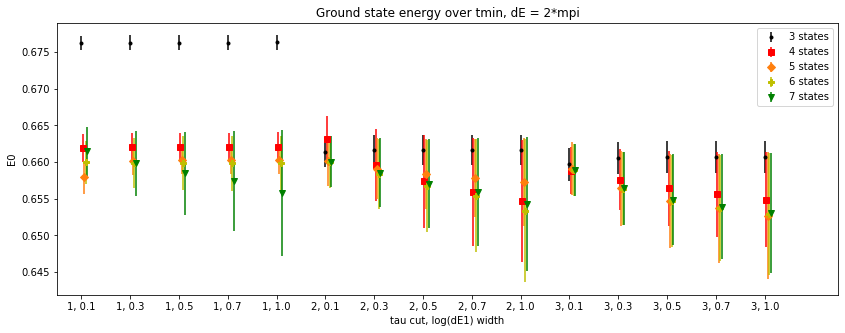

<Figure size 432x288 with 0 Axes>

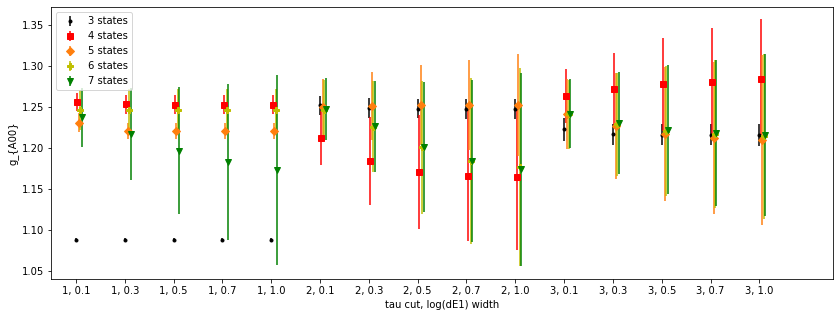

<Figure size 432x288 with 0 Axes>

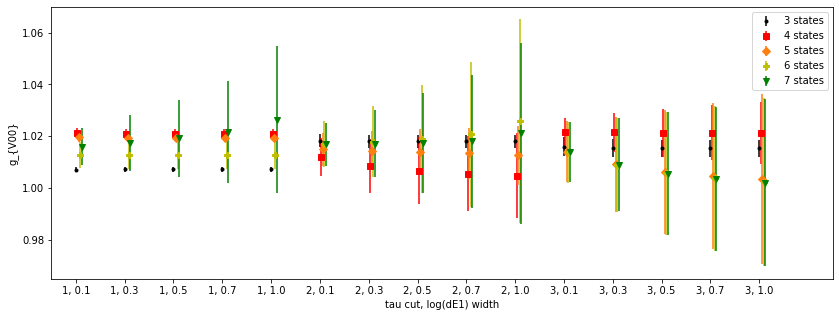

<Figure size 432x288 with 0 Axes>

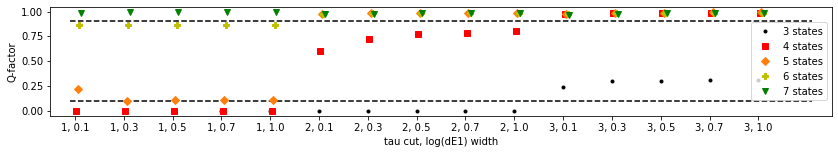

<Figure size 432x288 with 0 Axes>

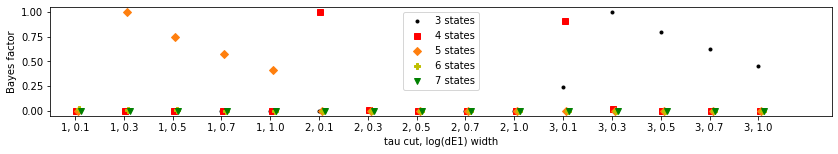

<Figure size 432x288 with 0 Axes>

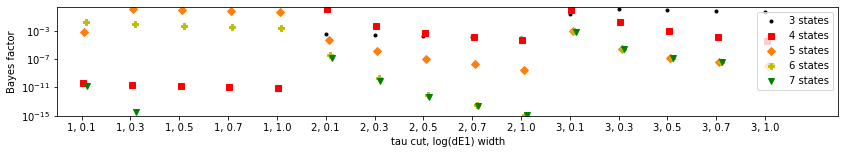

In [79]:
# First, define colors, markers, and legend labels to be used for each number of states
ax_markers = np.array(['.', 's', 'D', 'P', 'v', 'h', 'X', '^'])
ax_colors = np.array(['k', 'r', 'tab:orange', 'y', 'g', 'b', 'tab:purple', 'c'])
ax_labels = np.array(["3 states", "4 states", "5 states", "6 states", "7 states"])





# Set an x-array to map the results to the graph
ax_ensemble_to_x_map = np.arange(0, 15, 1)
xticlocs = np.arange(0, 15, 1)
xticklabels = np.array(["1, 0.1", \
                        "1, 0.3", \
                        "1, 0.5", \
                        "1, 0.7", \
                        "1, 1.0", \
                        "2, 0.1", \
                        "2, 0.3", \
                        "2, 0.5", \
                        "2, 0.7", \
                        "2, 1.0", \
                        "3, 0.1", \
                        "3, 0.3", \
                        "3, 0.5", \
                        "3, 0.7", \
                        "3, 1.0"])



# Now create an "upper bound" and "lower bound" plot on Q
samp_line = np.linspace(-0.1,15.1,500)
Q_01_line = np.linspace(0.1,0.1,500)
Q_09_line = np.linspace(0.9,0.9,500)

# Next, create the figure
#E0
plt.figure(figsize = (14,5))
plt.xlim([-0.5, 15.5])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

# Now loop over the number of states used in 3-point
for k in range(len(n_z_vals)):
    plt.errorbar(ax_ensemble_to_x_map + k*0.03, [E0_a0_graph[i][k*2].mean for i in range(len(ax_ensemble_to_x_map))], yerr = [E0_a0_graph[i][k*2].sdev for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])
    
plt.title("Ground state energy over tmin, dE = 2*mpi")
plt.ylabel("E0")

plt.legend()
plt.show()

plt.clf()

# Next, create the figure
#gA00
plt.figure(figsize = (14,5))
plt.xlim([-0.5, 15.5])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

for k in range(len(n_z_vals)):
    plt.errorbar(ax_ensemble_to_x_map + k*0.03, [gA00_a0_graph[i][k*2].mean for i in range(len(ax_ensemble_to_x_map))], yerr = [gA00_a0_graph[i][k*2].sdev for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])
    
plt.legend()
plt.ylabel("g_{A00}")
plt.show()

plt.clf()

# Next, create the figure
#gV00
plt.figure(figsize = (14,5))
plt.xlim([-0.5, 15.5])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

for k in range(len(n_z_vals)):
    plt.errorbar(ax_ensemble_to_x_map + k*0.03, [gV00_a0_graph[i][k*2].mean for i in range(len(ax_ensemble_to_x_map))], yerr = [gV00_a0_graph[i][k*2].sdev for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])
    
plt.legend()
plt.ylabel("g_{V00}")
plt.show()

plt.clf()

# Next, create the figure
#Q-factor
plt.figure(figsize = (14,2))
plt.xlim([-0.5, 15.5])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

for k in range(len(n_z_vals)):
    plt.errorbar(ax_ensemble_to_x_map + k*0.03, [Q_a0_graph[i][k*2] for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])
plt.plot(samp_line, Q_01_line, "k--")
plt.plot(samp_line, Q_09_line, "k--")
    
plt.legend()
plt.ylabel("Q-factor")
plt.show()

plt.clf()

# Next, create the figure
#Q-factor
plt.figure(figsize = (14,2))
plt.xlim([-0.5, 15.5])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

for k in range(len(n_z_vals)):
    plt.errorbar(ax_ensemble_to_x_map + k*0.03, [BF_a0_graph[i][k*2] for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])

    
plt.legend()
plt.ylabel("Bayes factor")
plt.show()

plt.clf()

plt.figure(figsize = (14,2))
plt.xlim([-0.5, 15.5])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

for k in range(len(n_z_vals)):
    plt.semilogy(ax_ensemble_to_x_map + k*0.03, [BF_a0_graph[i][k*2] for i in range(len(ax_ensemble_to_x_map))], '.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])

    
plt.ylim([1e-15, 2])
plt.legend(loc = 'upper right')
plt.ylabel("Bayes factor")
plt.show()

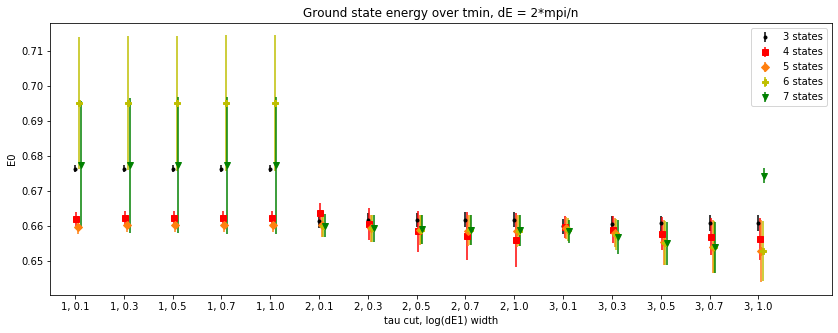

<Figure size 432x288 with 0 Axes>

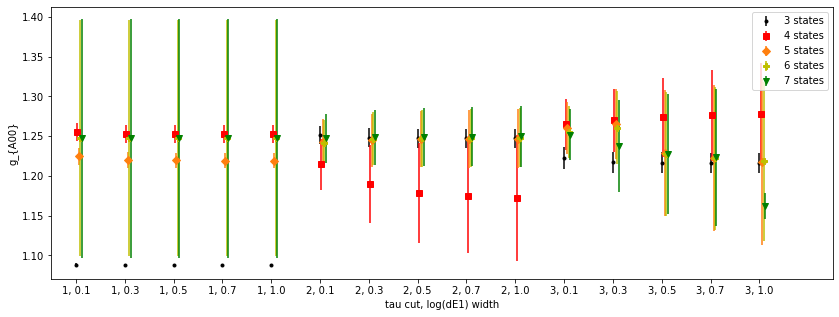

<Figure size 432x288 with 0 Axes>

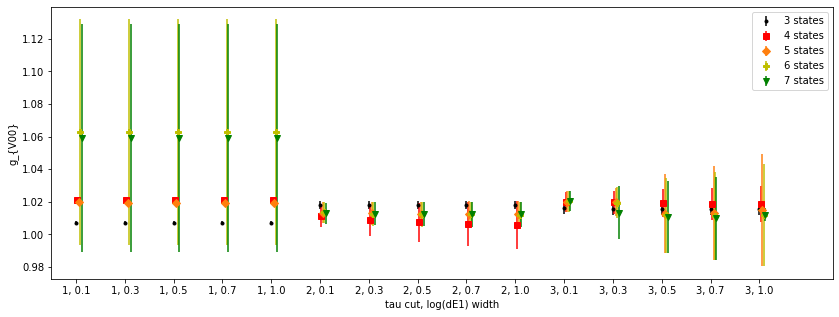

<Figure size 432x288 with 0 Axes>

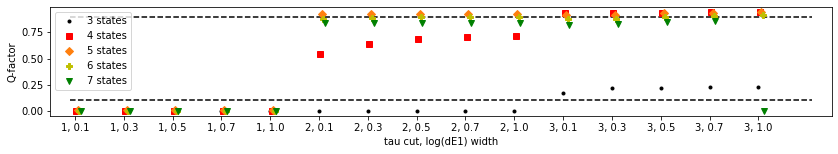

<Figure size 432x288 with 0 Axes>

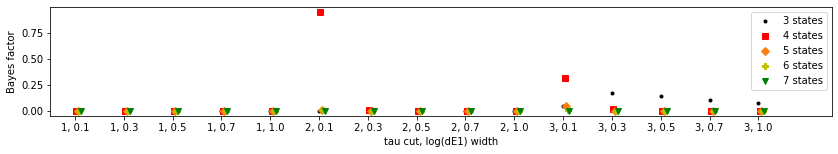

<Figure size 432x288 with 0 Axes>

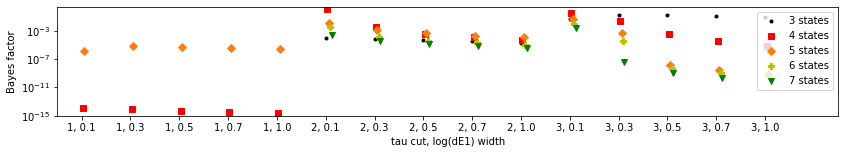

In [80]:
# Now, 1/n
# Next, create the figure
#E0
plt.figure(figsize = (14,5))
plt.xlim([-0.5, 15.5])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

# Now loop over the number of states used in 3-point
for k in range(len(n_z_vals)):
    plt.errorbar(ax_ensemble_to_x_map + k*0.03, [E0_a1_graph[i][k*2].mean for i in range(len(ax_ensemble_to_x_map))], yerr = [E0_a1_graph[i][k*2].sdev for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])
    
plt.title("Ground state energy over tmin, dE = 2*mpi/n")
plt.ylabel("E0")

plt.legend()
plt.show()

plt.clf()

# Next, create the figure
#gA00
plt.figure(figsize = (14,5))
plt.xlim([-0.5, 15.5])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

for k in range(len(n_z_vals)):
    plt.errorbar(ax_ensemble_to_x_map + k*0.03, [gA00_a1_graph[i][k*2].mean for i in range(len(ax_ensemble_to_x_map))], yerr = [gA00_a1_graph[i][k*2].sdev for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])
    
plt.legend()
plt.ylabel("g_{A00}")
plt.show()

plt.clf()

# Next, create the figure
#gV00
plt.figure(figsize = (14,5))
plt.xlim([-0.5, 15.5])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

for k in range(len(n_z_vals)):
    plt.errorbar(ax_ensemble_to_x_map + k*0.03, [gV00_a1_graph[i][k*2].mean for i in range(len(ax_ensemble_to_x_map))], yerr = [gV00_a1_graph[i][k*2].sdev for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])
    
plt.legend()
plt.ylabel("g_{V00}")
plt.show()

plt.clf()

# Next, create the figure
#Q-factor
plt.figure(figsize = (14,2))
plt.xlim([-0.5, 15.5])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

for k in range(len(n_z_vals)):
    plt.errorbar(ax_ensemble_to_x_map + k*0.03, [Q_a1_graph[i][k*2] for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])
plt.plot(samp_line, Q_01_line, "k--")
plt.plot(samp_line, Q_09_line, "k--")
    
plt.legend()
plt.ylabel("Q-factor")
plt.show()

plt.clf()

# Next, create the figure
#Q-factor
plt.figure(figsize = (14,2))
plt.xlim([-0.5, 15.5])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

for k in range(len(n_z_vals)):
    plt.errorbar(ax_ensemble_to_x_map + k*0.03, [BF_a1_graph[i][k*2] for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])

    
plt.legend()
plt.ylabel("Bayes factor")
plt.show()

plt.clf()

plt.figure(figsize = (14,2))
plt.xlim([-0.5, 15.5])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

for k in range(len(n_z_vals)):
    plt.semilogy(ax_ensemble_to_x_map + k*0.03, [BF_a1_graph[i][k*2] for i in range(len(ax_ensemble_to_x_map))], '.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])

    
plt.ylim([1e-15, 2])
plt.legend(loc = 'upper right')
plt.ylabel("Bayes factor")
plt.show()

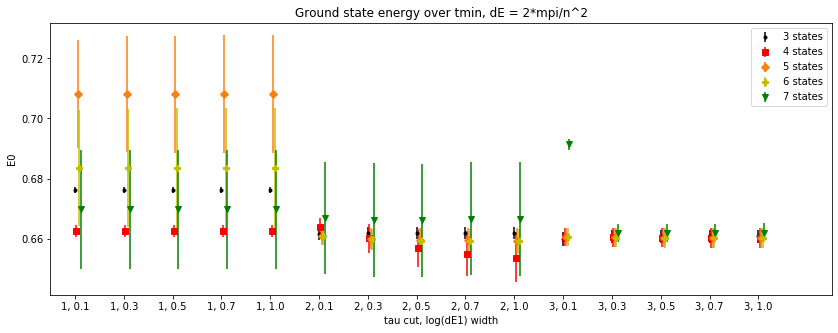

<Figure size 432x288 with 0 Axes>

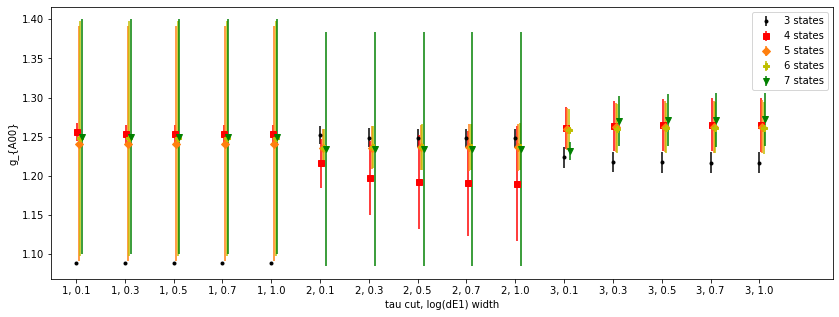

<Figure size 432x288 with 0 Axes>

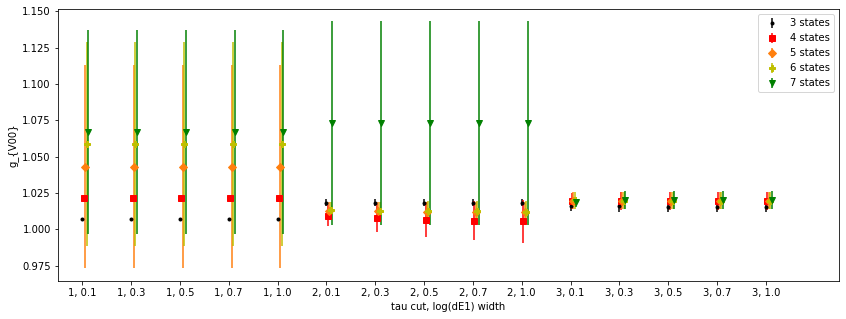

<Figure size 432x288 with 0 Axes>

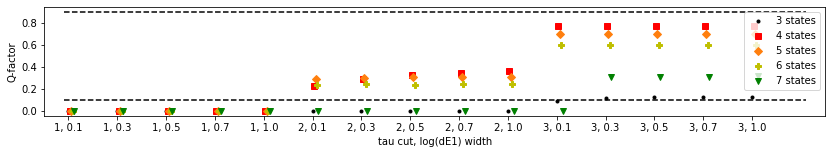

<Figure size 432x288 with 0 Axes>

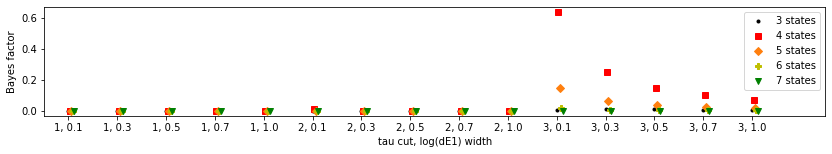

<Figure size 432x288 with 0 Axes>

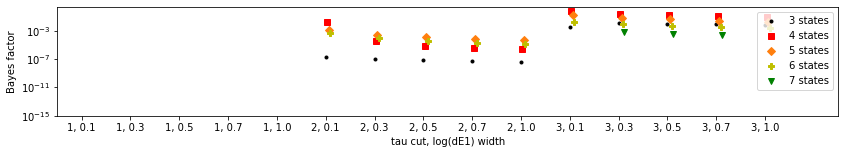

In [81]:
# Now, 1/n^2
# Next, create the figure
#E0
plt.figure(figsize = (14,5))
plt.xlim([-0.5, 15.5])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

# Now loop over the number of states used in 3-point
for k in range(len(n_z_vals)):
    plt.errorbar(ax_ensemble_to_x_map + k*0.03, [E0_a2_graph[i][k*2].mean for i in range(len(ax_ensemble_to_x_map))], yerr = [E0_a2_graph[i][k*2].sdev for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])
    
plt.title("Ground state energy over tmin, dE = 2*mpi/n^2")
plt.ylabel("E0")

plt.legend()
plt.show()

plt.clf()

# Next, create the figure
#gA00
plt.figure(figsize = (14,5))
plt.xlim([-0.5, 15.5])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

for k in range(len(n_z_vals)):
    plt.errorbar(ax_ensemble_to_x_map + k*0.03, [gA00_a2_graph[i][k*2].mean for i in range(len(ax_ensemble_to_x_map))], yerr = [gA00_a2_graph[i][k*2].sdev for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])
    
plt.legend()
plt.ylabel("g_{A00}")
plt.show()

plt.clf()

# Next, create the figure
#gV00
plt.figure(figsize = (14,5))
plt.xlim([-0.5, 15.5])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

for k in range(len(n_z_vals)):
    plt.errorbar(ax_ensemble_to_x_map + k*0.03, [gV00_a2_graph[i][k*2].mean for i in range(len(ax_ensemble_to_x_map))], yerr = [gV00_a2_graph[i][k*2].sdev for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])
    
plt.legend()
plt.ylabel("g_{V00}")
plt.show()

plt.clf()

# Next, create the figure
#Q-factor
plt.figure(figsize = (14,2))
plt.xlim([-0.5, 15.5])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

for k in range(len(n_z_vals)):
    plt.errorbar(ax_ensemble_to_x_map + k*0.03, [Q_a2_graph[i][k*2] for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])
plt.plot(samp_line, Q_01_line, "k--")
plt.plot(samp_line, Q_09_line, "k--")
    
plt.legend(loc = 'upper right')
plt.ylabel("Q-factor")
plt.show()

plt.clf()

# Next, create the figure
#Q-factor
plt.figure(figsize = (14,2))
plt.xlim([-0.5, 15.5])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

for k in range(len(n_z_vals)):
    plt.errorbar(ax_ensemble_to_x_map + k*0.03, [BF_a2_graph[i][k*2] for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])

    
plt.legend(loc = 'upper right')
plt.ylabel("Bayes factor")
plt.show()

plt.clf()

plt.figure(figsize = (14,2))
plt.xlim([-0.5, 15.5])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

for k in range(len(n_z_vals)):
    plt.semilogy(ax_ensemble_to_x_map + k*0.03, [BF_a2_graph[i][k*2] for i in range(len(ax_ensemble_to_x_map))], '.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])

    
plt.ylim([1e-15, 2])
plt.legend(loc = 'upper right')
plt.ylabel("Bayes factor")
plt.show()